# AdaHessian with Native Fastai Optimizer and No Callback
- With Imagenette and ImageWoof

In [1]:
%load_ext autoreload
%autoreload 2

from fastai.vision.all import *
from fastai.callback.all import *

#from AdahessianFastai import adahessian

In [2]:
import ipdb 

In [3]:
def get_path(woof=True):
    if woof: path = untar_data(URLs.IMAGEWOOF_160)
    else: path = untar_data(URLs.IMAGENETTE_160)
    return path

path = get_path(woof=False)
size = 224
bs = 32

In [4]:
def get_dls(size=128):
    dls = ImageDataLoaders.from_folder(path, valid='val', bs=bs, 
        item_tfms=[RandomResizedCrop(size, min_scale=0.35),FlipItem(p=0.5)],  # Resize(size)
        batch_tfms=Normalize.from_stats(*imagenet_stats)) 
    return dls

dls = get_dls(size=size)

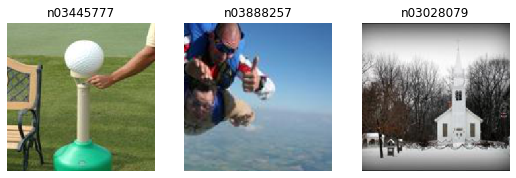

In [5]:
dls.show_batch(max_n=3)

## AdaHessian

@article{yao2020adahessian,
  title={ADAHESSIAN: An Adaptive Second Order Optimizer for Machine Learning},
  author={Yao, Zhewei and Gholami, Amir and Shen, Sheng and Keutzer, Kurt and Mahoney, Michael W},
  journal={arXiv preprint arXiv:2006.00719},
  year={2020}
}

In [6]:
from torch.cuda.amp import GradScaler, autocast

class BatchNormFP32(nn.BatchNorm2d):
    def __init__(self, *args, **kwargs): super().__init__(*args, **kwargs)
    def forward(self, x): return super().forward(x.float())

def swap_batch_norm(model, layer_type_old, layer_type_new, copy_data=True):
    # core logic based on https://forums.fast.ai/t/change-activation-function-in-resnet-model/78456/3
    conversion_count = 0
    #TODO :  make sure device is correct
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = swap_batch_norm(module, layer_type_old, layer_type_new)

        if type(module) == layer_type_old:
            nf = getattr(module, 'num_features')
            eps = getattr(module, 'eps')
            mom = getattr(module, 'momentum')
            aff = getattr(module, 'affine')
            track = getattr(module, 'track_running_stats')
            layer_old = module
            
            layer_new = layer_type_new(nf, eps=eps, momentum=mom, 
                                             affine=aff, track_running_stats=track).cuda()
            if copy_data:
                # COPY WEIGHTS AND BIASES IN CASE IT'S PRETRAINED OR WE'VE DONE 
                # SOME FANCY INITIALISATION
                layer_new.weight.data = layer_old.weight.data
                layer_new.bias.data = layer_old.bias.data
                model._modules[name] = layer_new
    return model

from enum import Enum
class OptState(Enum):
    READY = 0
    UNSCALED = 1
    STEPPED = 2

class NativeMixedPrecisionAdaHessian(Callback):
    "Mixed precision training using Pytorch's `autocast` and `GradScaler`"
    @delegates(GradScaler.__init__)
    def __init__(self, **kwargs): 
        self.scaler_kwargs,self.autocast = kwargs,autocast()

    def before_fit(self):
        self.learn.scaler = GradScaler(**self.scaler_kwargs)
        self.learn._step,self.learn._backward = self._step,self._backward
        self.learn.opt._step_supports_amp_scaling = True  # M ADDED
        self.learn.model = swap_batch_norm(self.learn.model, nn.BatchNorm2d, BatchNormFP32)
        
    def before_batch(self): self.autocast.__enter__()
    def after_loss(self): self.autocast.__exit__()
    def after_step(self): 
        no_found_inf = torch.full((1,), 0.0, dtype=torch.float32, device=self.learn.scaler._scale.device)
        self.learn.scaler._per_optimizer_states[id(self.learn.opt.opt)]['found_inf_per_device'] = {'dummy':no_found_inf}
        self.learn.scaler.update()
    #def _backward(self): self.scaler.scale(self.loss).backward()  # M MODIFIED
    def _step(self): self.scaler.step(self.opt)

# Cell
@delegates(GradScaler.__init__)
@patch
def to_fp16_adahessian(self:Learner, **kwargs):
    self.add_cb(NativeMixedPrecisionAdaHessian(**kwargs))
    self.fp16_adahessian = True   # M ADDED
    return self

In [7]:
def average_sqr_diag_hessian(p, sqr_mom, dampening=True, sqr_avg_diag_hessian=None, hutchinson_trace=None, **kwargs):
    if sqr_avg_diag_hessian is None: sqr_avg_diag_hessian = torch.zeros_like(p.grad.data)
    damp = 1-sqr_mom if dampening else 1.
    sqr_avg_diag_hessian.mul_(sqr_mom).addcmul_(hutchinson_trace, hutchinson_trace, value=damp)
    return {'sqr_avg_diag_hessian': sqr_avg_diag_hessian}

def adahessian_step(p, lr, mom, step, sqr_mom, grad_avg, sqr_avg_diag_hessian, hessian_power, eps, **kwargs):
    "Step for AdaHessian with `lr` on `p`"
    debias1 = debias(mom,     1-mom,     step)
    debias2 = debias(sqr_mom, 1-sqr_mom, step)
    if hessian_power < 1:
        p.data.addcdiv_(grad_avg, ((sqr_avg_diag_hessian/debias2).sqrt() ** hessian_power) + eps, value = -lr / debias1)  
    else:
        p.data.addcdiv_(grad_avg, (sqr_avg_diag_hessian/debias2).sqrt() + eps, value = -lr / debias1)    
    return p

@log_args(to_return=True, but_as=Optimizer.__init__)
def AdaHessian(params, lr=0.15, hessian_power=1., hutchinson_trace=None, mom=0.9, sqr_mom=0.999, eps=1e-4, wd=1e-4, decouple_wd=True):
    "A `Optimizer` for AdaHessian"
    cbs = [weight_decay] if decouple_wd else [l2_reg]
    cbs += [partial(average_grad, dampening=True), average_sqr_diag_hessian, step_stat, adahessian_step]
    return Optimizer(params, cbs, lr=lr, mom=mom, sqr_mom=sqr_mom, hessian_power=hessian_power, eps=eps, wd=wd)

In [8]:
def _test_overflow(x):
    s = float(x.float().sum())
    return (s == float('inf') or s == float('-inf') or s != s)

def _my_grad_overflow(gradsH):
    for g in gradsH: 
        if g is not None and _test_overflow(g.data): return True
    return False

def _overflow_cancel_batch(self):
    self.model.zero_grad()
    self.scaler.unscale_(self.opt)
    self.scaler._per_optimizer_states[id(self.opt.opt)]['stage'] = OptState.UNSCALED

    # ADD FOUND 1 inf
    # NEED found_inf_combined > 0 IN torch._amp_update_scale in update() to get reduction in scale
    # NEED TO INSERT INFS INTO _per_optimizer_states to get update to trigger downscale
    found_inf = torch.full((1,), 1.0, dtype=torch.float32, device=self.scaler._scale.device)
    self.scaler._per_optimizer_states[id(self.opt.opt)]['found_inf_per_device'] = {'dummy':found_inf}
    self.scaler.update()
    raise CancelBatchException() 

In [9]:
import subprocess

def get_gpu_memory_map():
    """Get the current gpu usage.

    Returns
    -------
    usage: dict
        Keys are device ids as integers.
        Values are memory usage as integers in MB.
    """
    result = subprocess.check_output(
        [
            'nvidia-smi', '--query-gpu=memory.used',
            '--format=csv,nounits,noheader'
        ], encoding='utf-8')
    # Convert lines into a dictionary
    gpu_memory = [int(x) for x in result.strip().split('\n')]
    gpu_memory_map = dict(zip(range(len(gpu_memory)), gpu_memory))
    return gpu_memory_map

In [10]:
@log_args(but='opt')
class AdaHessianWrapper(Optimizer, GetAttr):
    "Wrap `opt` in a AdaHessian Wrapper"
    _default='opt'
    def __init__(self, opt, block_length=32, n_acc=1):
        store_attr('opt,block_length,n_acc')
        self.accum_count=0
        self.hvs, self.v = [],[]

        @patch
        def _backward(self:Learner):  
            print(f'before backward: {get_gpu_memory_map()}')
            
            if hasattr(self, 'fp16_adahessian') and self.fp16_adahessian: 
                self.scaler.scale(self.loss).backward(create_graph=True)
            else: self.loss.backward(create_graph=True)
        
            params, gradsH = self.opt._get_params_grads(learn=self)
                        
            # UNSCALE GRADS, TEST FOR GRADS OVERFLOW AND EXIT IF NEEDED
            if hasattr(self, 'fp16_adahessian') and self.fp16_adahessian:                 
                if _my_grad_overflow(gradsH): 
                    print('Gradient overflow, exiting batch \n')
                    _overflow_cancel_batch(self)
                
                inv_scale = 1./self.scaler.get_scale()
                gradsH = [g * inv_scale for g in gradsH]
            
            print(f'in backward, before hessian calc: {get_gpu_memory_map()}')
            # CALCULATE HESSIAN
            hvs, v = self.opt._get_hessian(params, gradsH)
            print(f'in backward, after hessian calc: {get_gpu_memory_map()}')
            
            # TEST HVS OVERFLOW 
            if hasattr(self, 'fp16_adahessian') and self.fp16_adahessian: 
                for hv in hvs:
                    if test_overflow(hv): 
                        print('Hvs overflow, exiting batch \n')
                        _overflow_cancel_batch(self)
                            
            # SET hvs and v
            self.opt.hvs = hvs
            self.opt.v = v



#             for g in gradsH: 
#                 if g.grad is not None: print('HAS GRAD!')
                
#                 if g.grad_fn is not None:
#                     g.detach_()
#                 else:
#                     g.requires_grad_(False)
#                 g.zero_()
                
#             for g in params: 
#                 if g.grad is not None: print('HAS GRAD!')
                
#                 if g.grad.grad_fn is not None:
#                     g.grad.detach_()
#                 else:
#                     g.grad.requires_grad_(False)
#                 g.grad.zero_()

#             if p.grad is not None:
#                 if set_to_none:
#                     p.grad = None
#                 else:
#                     if p.grad.grad_fn is not None:
#                         p.grad.detach_()
#                     else:
#                         p.grad.requires_grad_(False)
#                     p.grad.zero_()
            
            print(f'after backward: {get_gpu_memory_map()} \n')
            
    def step(self, grad_scaler=None):
        # ACCUMULATE GRADIENTS IF NEEDED
        self._accumulate_grads()
        
        # CALC HUTCHINSON TRACE
#         with autocast(enabled = grad_scaler is not None):
#             hutchinson_trace = self._get_trace(self.hvs, self.v)
        hutchinson_trace = self._get_trace(self.hvs, self.v)
        
        self.hvs, self.v = [],[]
        
        for i, (p,pg,state,hyper) in enumerate(self.opt.all_params(with_grad=True)):
            if grad_scaler is not None: p.grad.div_(grad_scaler.get_scale())    # UNSCALE OPT GRADS
            state['hutchinson_trace'] = hutchinson_trace[i]
            for cb in self.opt.cbs: state = self._update(state, cb(p, **{**state, **hyper}))
            self.opt.state[p] = state
            
    def zero_grad(self):
        self.opt.zero_grad()
            
    def clear_state(self):
        self.opt.clear_state()

    def state_dict(self):
        state = self.opt.state_dict()
        
    def clear_state(self):
        self.opt.clear_state()
    
    def load_state_dict(self, sd):
        self.opt.load_state_dict(sd)

    def _get_params_grads(self, learn):
        params, gradsH = [], []
        for p,*_ in learn.opt.opt.all_params(with_grad=True):
            params.append(p)
            gradsH.append(0. if p.grad is None else p.grad + 0.)
        return params, gradsH

    def _get_hessian(self, params, gradsH):
        device = params[0].device
        print(f'in hessian, before v calc: {get_gpu_memory_map()}')
        v = [torch.randint_like(p, high=2, device=device) for p in params]
        print(f'in hessian, after v calc: {get_gpu_memory_map()}')
        for v_i in v: v_i[v_i == 0] = -1
        print(f'in hessian, after v modification: {get_gpu_memory_map()}')
        
        gsize = 0
        for g in gradsH:
            gsize += g.element_size() * g.nelement()
        psize = 0
        for p in params:
            psize += p.element_size() * p.nelement()
        
        print(f'in hessian, before hessian, param size: {psize}, gradsH size: {gsize}')
        
        hvs = torch.autograd.grad(gradsH, params, grad_outputs=v, only_inputs=True, create_graph=False, retain_graph=False)
        
        hsize = 0
        for h in hvs:
            hsize += h.element_size() * h.nelement()
        print(f'in hessian, before hessian, hvs size: {hsize}')
        print(f'in hessian, after after hessian: {get_gpu_memory_map()}')
        return hvs, v
  
    def _get_trace(self, hvs, v):
        hutchinson_trace = []
        for hv, vi in zip(hvs, v):
            param_size = hv.size()

            if len(param_size) <= 1:  
                # For 1D tensor, e.g.,, bias, BatchNorm, LayerNorm etc.
                # Usually, you do not need to set spatial aveging for it, i.e., Hessian diagonal block size is 1 here.
                tmp_output = torch.abs(hv * vi)
                hutchinson_trace.append(tmp_output)

                # Of course, you can also use the same way as 2D tensor does to average your 1D tensor. 
                # tmp_output1 = torch.abs((hv * vi + 0.)).view(-1, self.block_length) # faltten to the N times self.block_length
                # tmp_output2 = torch.abs(torch.sum(tmp_output1, dim=[1])).view(-1) / float(self.block_length)
                # tmp_output3 = tmp_output2.repeat_interleave(self.block_length).view(param_size)
                # hutchinson_trace.append(tmp_output3)

            elif len(param_size) == 2: 
                # For 2D tensor, e.g., the matrix in the fully-connected layer.
                # This is a normal case for MLP, Transformer models. 
                # Usually, a spatial averaging needs to be used here to get the best result.
                # If you are not looking for the absolute best config, you may set it to be 1.
                # In all of our experiments, we sill get pretty good performance.
                tmp_output1 = torch.abs((hv * vi + 0.)).view(-1, self.block_length) # faltten to the N times self.block_length
                tmp_output2 = torch.abs(torch.sum(tmp_output1, dim=[1])).view(-1) / float(self.block_length)
                tmp_output3 = tmp_output2.repeat_interleave(self.block_length).view(param_size)
                hutchinson_trace.append(tmp_output3)
            elif len(param_size) == 3:
                # For 3D tensor, e.g., the 1D Conv layer.
                # This layer is usually used for Char-LM.

                # First Way:
                # Usually, you can set it to be the conv kernel size: in more details, for instance, your input/output channels are 20 and your kernel size is 5, 
                # then the 1D Conv kernel is in size 20x20x5, you can average along the final dim, i.e., the block_length = 5
                tmp_output = torch.abs(torch.sum(torch.abs(
                    hv * vi), dim=[2], keepdim=True)) / vi[0, 1].numel() # torch.sum() reduces the dim 2， i.e. the size 5

                # Second way:
                # Of course, you can also use the same self.block_length to average the spatival Hessian of 3D kernel.
                # tmp_output1 = torch.abs((hv * vi + 0.)).view(-1, self.block_length) # faltten to the N times self.block_length
                # tmp_output2 = torch.abs(torch.sum(tmp_output1, dim=[1])).view(-1) / float(self.block_length)
                # tmp_output3 = tmp_output2.repeat_interleave(self.block_length).view(param_size)
                # hutchinson_trace.append(tmp_output3)

            elif len(param_size) == 4:  
                # For 4D tensor, e.g, the 2D Conv layer
                # This layer is usually used for CV tasks.

                # First Way:
                # Usually, you can set it to be the conv kernel size: in more details, for instance, your input/output channels are 256 and your kernel size is 3x3, 
                # then the 2D Conv kernel is in size 20x20x3x3, you can average along the last two dims, , i.e., the block_length = 9
                if vi.size()[1] == 1:
                    vi_div = vi[0, 0]
                else:
                    vi_div = vi[0, 1]
                tmp_output = torch.abs(torch.sum(torch.abs(
                    hv * vi), dim=[2, 3], keepdim=True)) / vi_div.numel() # torch.sum() reduces the dim 2/3.
                hutchinson_trace.append(tmp_output)

                # Second way:
                # Of course, you can also use the same self.block_length to average the spatival Hessian of 4D kernel.
                # tmp_output1 = torch.abs((hv * vi + 0.)).view(-1, self.block_length) # faltten to the N times self.block_length
                # tmp_output2 = torch.abs(torch.sum(tmp_output1, dim=[1])).view(-1) / float(self.block_length)
                # tmp_output3 = tmp_output2.repeat_interleave(self.block_length).view(param_size)
                # hutchinson_trace.append(tmp_output3)
        return hutchinson_trace
    
    def _update(self, state, new=None):
        if new is None: return state
        if isinstance(new, dict): state.update(new)
        return state

    def _accumulate_grads(self):
        self.accum_count += 1
        if self.accum_count < self.n_acc: 
            raise CancelBatchException() #skip weight update
        else: self.accum_count=0
    
@delegates(AdaHessian)
def adahessian(p, lr=0.15, n_acc=1, block_length=32, hessian_power=1., mom=0.9, sqr_mom=0.999, 
               eps=1e-4, wd=1e-4, **kwargs):
    "Convenience method for `AdaHessianWrapper` with `Adahessian`"
    return AdaHessianWrapper(AdaHessian(p, lr=lr, **kwargs), n_acc=n_acc, block_length=block_length)


## MixedPrecision

Questions:

- No copying of model like in fastai fp16
- No gradient clipping
- What to do about gradient accumulation

See examples: https://pytorch.org/docs/stable/notes/amp_examples.html#amp-examples


## Learn

In [11]:
learn = Learner(dls, resnet18(), metrics=accuracy, opt_func=adahessian, 
                loss_func=LabelSmoothingCrossEntropy()).to_fp16_adahessian() 

before backward: {0: 3139}
in backward, before hessian calc: {0: 3165}
in hessian, before v calc: {0: 3165}
in hessian, after v calc: {0: 3165}
in hessian, after v modification: {0: 3167}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 3983}
in backward, after hessian calc: {0: 3983}
after backward: {0: 3983} 

before backward: {0: 3983}
in backward, before hessian calc: {0: 3989}
in hessian, before v calc: {0: 3989}
in hessian, after v calc: {0: 3989}
in hessian, after v modification: {0: 3991}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 3995}
in backward, after hessian calc: {0: 3995}
after backward: {0: 3995} 

before backward: {0: 3995}
in backward, before hessian calc: {0: 3995}
in hessian, before v calc: {0: 3995}
in hessian, after v calc: {0: 3995}
in hessian, af

in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 3997}
in backward, after hessian calc: {0: 3997}
after backward: {0: 3997} 

before backward: {0: 3997}
in backward, before hessian calc: {0: 3997}
in hessian, before v calc: {0: 3997}
in hessian, after v calc: {0: 3997}
in hessian, after v modification: {0: 3997}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 3997}
in backward, after hessian calc: {0: 3997}
after backward: {0: 3997} 

before backward: {0: 3997}
in backward, before hessian calc: {0: 3997}
in hessian, before v calc: {0: 3997}
in hessian, after v calc: {0: 3997}
in hessian, after v modification: {0: 3997}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 3997}
in backward, after hessian calc: {0: 3997}
after backward: {0: 3997}

in hessian, before v calc: {0: 4803}
in hessian, after v calc: {0: 4803}
in hessian, after v modification: {0: 4803}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4803}
in backward, after hessian calc: {0: 4803}
after backward: {0: 4803} 

before backward: {0: 4803}
in backward, before hessian calc: {0: 4803}
in hessian, before v calc: {0: 4803}
in hessian, after v calc: {0: 4803}
in hessian, after v modification: {0: 4803}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4803}
in backward, after hessian calc: {0: 4803}
after backward: {0: 4803} 

before backward: {0: 4803}
in backward, before hessian calc: {0: 4803}
in hessian, before v calc: {0: 4803}
in hessian, after v calc: {0: 4803}
in hessian, after v modification: {0: 4803}
in hessian, before hessian, param size: 4

in hessian, after after hessian: {0: 4803}
in backward, after hessian calc: {0: 4803}
after backward: {0: 4803} 

before backward: {0: 4803}
in backward, before hessian calc: {0: 4803}
in hessian, before v calc: {0: 4803}
in hessian, after v calc: {0: 4803}
in hessian, after v modification: {0: 4803}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4803}
in backward, after hessian calc: {0: 4803}
after backward: {0: 4803} 

before backward: {0: 4803}
in backward, before hessian calc: {0: 4803}
in hessian, before v calc: {0: 4803}
in hessian, after v calc: {0: 4803}
in hessian, after v modification: {0: 4803}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4803}
in backward, after hessian calc: {0: 4803}
after backward: {0: 4803} 

before backward: {0: 4803}
in backward, befo

in backward, before hessian calc: {0: 4803}
in hessian, before v calc: {0: 4803}
in hessian, after v calc: {0: 4803}
in hessian, after v modification: {0: 4803}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4803}
in backward, after hessian calc: {0: 4803}
after backward: {0: 4803} 

before backward: {0: 4802}
Gradient overflow, exiting batch 

before backward: {0: 4802}
in backward, before hessian calc: {0: 4802}
in hessian, before v calc: {0: 4802}
in hessian, after v calc: {0: 4802}
in hessian, after v modification: {0: 4802}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4802}
in backward, after hessian calc: {0: 4802}
after backward: {0: 4802} 

before backward: {0: 4802}
in backward, before hessian calc: {0: 4802}
in hessian, before v calc: {0: 4802}
in hessian, aft

in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4802}
in backward, after hessian calc: {0: 4802}
after backward: {0: 4802} 



SuggestedLRs(lr_min=0.6456542491912842, lr_steep=0.03162277489900589)

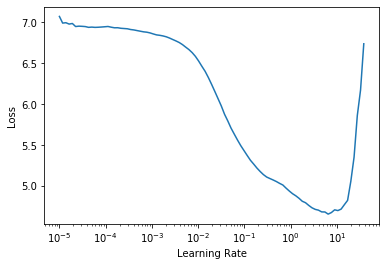

In [12]:
learn.lr_find(start_lr=1e-05, end_lr=100)

In [12]:
learn.fit_one_cycle(5, 4e-2)

before backward: {0: 3139}
in backward, before hessian calc: {0: 3165}
in hessian, before v calc: {0: 3165}
in hessian, after v calc: {0: 3165}
in hessian, after v modification: {0: 3167}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 3983}
in backward, after hessian calc: {0: 3983}
after backward: {0: 3983} 

before backward: {0: 3983}
in backward, before hessian calc: {0: 3989}
in hessian, before v calc: {0: 3989}
in hessian, after v calc: {0: 3989}
in hessian, after v modification: {0: 3991}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 3995}
in backward, after hessian calc: {0: 3995}
after backward: {0: 3995} 

before backward: {0: 3995}
in backward, before hessian calc: {0: 3995}
in hessian, before v calc: {0: 3995}
in hessian, after v calc: {0: 3995}
in hessian, af

in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 3997}
in backward, after hessian calc: {0: 3997}
after backward: {0: 3997} 

before backward: {0: 3997}
in backward, before hessian calc: {0: 3997}
in hessian, before v calc: {0: 3997}
in hessian, after v calc: {0: 3997}
in hessian, after v modification: {0: 3997}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 3997}
in backward, after hessian calc: {0: 3997}
after backward: {0: 3997} 

before backward: {0: 3997}
in backward, before hessian calc: {0: 3997}
in hessian, before v calc: {0: 3997}
in hessian, after v calc: {0: 3997}
in hessian, after v modification: {0: 3997}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 3997}
in backward, after hessian calc: {0: 3997}
after backward: {0: 3997}

in hessian, after v calc: {0: 4803}
in hessian, after v modification: {0: 4803}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4803}
in backward, after hessian calc: {0: 4803}
after backward: {0: 4803} 

before backward: {0: 4803}
in backward, before hessian calc: {0: 4803}
in hessian, before v calc: {0: 4803}
in hessian, after v calc: {0: 4803}
in hessian, after v modification: {0: 4803}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4803}
in backward, after hessian calc: {0: 4803}
after backward: {0: 4803} 

before backward: {0: 4803}
in backward, before hessian calc: {0: 4803}
in hessian, before v calc: {0: 4803}
in hessian, after v calc: {0: 4803}
in hessian, after v modification: {0: 4803}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hes

in hessian, after after hessian: {0: 4803}
in backward, after hessian calc: {0: 4803}
after backward: {0: 4803} 

before backward: {0: 4803}
in backward, before hessian calc: {0: 4803}
in hessian, before v calc: {0: 4803}
in hessian, after v calc: {0: 4803}
in hessian, after v modification: {0: 4803}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4803}
in backward, after hessian calc: {0: 4803}
after backward: {0: 4803} 

before backward: {0: 4803}
in backward, before hessian calc: {0: 4803}
in hessian, before v calc: {0: 4803}
in hessian, after v calc: {0: 4803}
in hessian, after v modification: {0: 4803}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4803}
in backward, after hessian calc: {0: 4803}
after backward: {0: 4803} 

before backward: {0: 4803}
in backward, befo

in hessian, after v calc: {0: 4803}
in hessian, after v modification: {0: 4803}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4803}
in backward, after hessian calc: {0: 4803}
after backward: {0: 4803} 

before backward: {0: 4803}
in backward, before hessian calc: {0: 4803}
in hessian, before v calc: {0: 4803}
in hessian, after v calc: {0: 4803}
in hessian, after v modification: {0: 4803}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4803}
in backward, after hessian calc: {0: 4803}
after backward: {0: 4803} 

before backward: {0: 4803}
in backward, before hessian calc: {0: 4803}
in hessian, before v calc: {0: 4803}
in hessian, after v calc: {0: 4803}
in hessian, after v modification: {0: 4803}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hes

in hessian, after after hessian: {0: 4803}
in backward, after hessian calc: {0: 4803}
after backward: {0: 4803} 

before backward: {0: 4803}
in backward, before hessian calc: {0: 4803}
in hessian, before v calc: {0: 4803}
in hessian, after v calc: {0: 4803}
in hessian, after v modification: {0: 4803}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4803}
in backward, after hessian calc: {0: 4803}
after backward: {0: 4803} 

before backward: {0: 4803}
in backward, before hessian calc: {0: 4803}
in hessian, before v calc: {0: 4803}
in hessian, after v calc: {0: 4803}
in hessian, after v modification: {0: 4803}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4803}
in backward, after hessian calc: {0: 4803}
after backward: {0: 4803} 

before backward: {0: 4803}
in backward, befo

in hessian, after v calc: {0: 4803}
in hessian, after v modification: {0: 4803}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4803}
in backward, after hessian calc: {0: 4803}
after backward: {0: 4803} 

before backward: {0: 4803}
in backward, before hessian calc: {0: 4803}
in hessian, before v calc: {0: 4803}
in hessian, after v calc: {0: 4803}
in hessian, after v modification: {0: 4803}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4803}
in backward, after hessian calc: {0: 4803}
after backward: {0: 4803} 

before backward: {0: 4803}
in backward, before hessian calc: {0: 4803}
in hessian, before v calc: {0: 4803}
in hessian, after v calc: {0: 4803}
in hessian, after v modification: {0: 4802}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hes

in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4802}
in backward, after hessian calc: {0: 4802}
after backward: {0: 4802} 

before backward: {0: 4802}
in backward, before hessian calc: {0: 4802}
in hessian, before v calc: {0: 4802}
in hessian, after v calc: {0: 4802}
in hessian, after v modification: {0: 4802}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4802}
in backward, after hessian calc: {0: 4802}
after backward: {0: 4802} 

before backward: {0: 4802}
in backward, before hessian calc: {0: 4802}
in hessian, before v calc: {0: 4802}
in hessian, after v calc: {0: 4802}
in hessian, after v modification: {0: 4802}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4802}
in backward, after hessian calc: {0: 4802}
after backward: {0: 4802}

in hessian, after v calc: {0: 4802}
in hessian, after v modification: {0: 4802}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4802}
in backward, after hessian calc: {0: 4802}
after backward: {0: 4802} 

before backward: {0: 4802}
in backward, before hessian calc: {0: 4802}
in hessian, before v calc: {0: 4802}
in hessian, after v calc: {0: 4802}
in hessian, after v modification: {0: 4802}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4802}
in backward, after hessian calc: {0: 4802}
after backward: {0: 4802} 

before backward: {0: 4802}
in backward, before hessian calc: {0: 4802}
in hessian, before v calc: {0: 4802}
in hessian, after v calc: {0: 4802}
in hessian, after v modification: {0: 4802}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hes

in hessian, after after hessian: {0: 4802}
in backward, after hessian calc: {0: 4802}
after backward: {0: 4802} 

before backward: {0: 4802}
in backward, before hessian calc: {0: 4802}
in hessian, before v calc: {0: 4802}
in hessian, after v calc: {0: 4802}
in hessian, after v modification: {0: 4802}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4802}
in backward, after hessian calc: {0: 4802}
after backward: {0: 4802} 

before backward: {0: 4802}
in backward, before hessian calc: {0: 4802}
in hessian, before v calc: {0: 4802}
in hessian, after v calc: {0: 4802}
in hessian, after v modification: {0: 4802}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4802}
in backward, after hessian calc: {0: 4802}
after backward: {0: 4802} 

before backward: {0: 4802}
in backward, befo

in hessian, after v calc: {0: 4802}
in hessian, after v modification: {0: 4802}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4802}
in backward, after hessian calc: {0: 4802}
after backward: {0: 4802} 

before backward: {0: 4802}
in backward, before hessian calc: {0: 4802}
in hessian, before v calc: {0: 4802}
in hessian, after v calc: {0: 4802}
in hessian, after v modification: {0: 4802}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4802}
in backward, after hessian calc: {0: 4802}
after backward: {0: 4802} 

before backward: {0: 4802}
in backward, before hessian calc: {0: 4802}
in hessian, before v calc: {0: 4802}
in hessian, after v calc: {0: 4802}
in hessian, after v modification: {0: 4802}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hes

in hessian, after after hessian: {0: 4802}
in backward, after hessian calc: {0: 4802}
after backward: {0: 4802} 

before backward: {0: 4802}
in backward, before hessian calc: {0: 4802}
in hessian, before v calc: {0: 4802}
in hessian, after v calc: {0: 4802}
in hessian, after v modification: {0: 4802}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4802}
in backward, after hessian calc: {0: 4802}
after backward: {0: 4802} 

before backward: {0: 4802}
in backward, before hessian calc: {0: 4802}
in hessian, before v calc: {0: 4802}
in hessian, after v calc: {0: 4802}
in hessian, after v modification: {0: 4802}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4802}
in backward, after hessian calc: {0: 4802}
after backward: {0: 4802} 

before backward: {0: 4802}
in backward, befo

in hessian, after v calc: {0: 4802}
in hessian, after v modification: {0: 4802}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4802}
in backward, after hessian calc: {0: 4802}
after backward: {0: 4802} 

before backward: {0: 4802}
in backward, before hessian calc: {0: 4802}
in hessian, before v calc: {0: 4802}
in hessian, after v calc: {0: 4802}
in hessian, after v modification: {0: 4802}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4802}
in backward, after hessian calc: {0: 4802}
after backward: {0: 4802} 

before backward: {0: 4802}
in backward, before hessian calc: {0: 4802}
in hessian, before v calc: {0: 4802}
in hessian, after v calc: {0: 4802}
in hessian, after v modification: {0: 4802}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hes

in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4802}
in backward, after hessian calc: {0: 4802}
after backward: {0: 4802} 

before backward: {0: 4802}
in backward, before hessian calc: {0: 4802}
in hessian, before v calc: {0: 4802}
in hessian, after v calc: {0: 4802}
in hessian, after v modification: {0: 4802}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4802}
in backward, after hessian calc: {0: 4802}
after backward: {0: 4802} 

before backward: {0: 4802}
in backward, before hessian calc: {0: 4802}
in hessian, before v calc: {0: 4802}
in hessian, after v calc: {0: 4802}
in hessian, after v modification: {0: 4802}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4802}
in backward, after hessian calc: {0: 4802}
after backward: {0: 4802}

in hessian, after v calc: {0: 4803}
in hessian, after v modification: {0: 4803}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4803}
in backward, after hessian calc: {0: 4803}
after backward: {0: 4803} 

before backward: {0: 4803}
in backward, before hessian calc: {0: 4803}
in hessian, before v calc: {0: 4803}
in hessian, after v calc: {0: 4803}
in hessian, after v modification: {0: 4803}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4803}
in backward, after hessian calc: {0: 4803}
after backward: {0: 4803} 

before backward: {0: 4803}
in backward, before hessian calc: {0: 4803}
in hessian, before v calc: {0: 4803}
in hessian, after v calc: {0: 4803}
in hessian, after v modification: {0: 4803}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hes

in hessian, after after hessian: {0: 4803}
in backward, after hessian calc: {0: 4803}
after backward: {0: 4803} 

before backward: {0: 2907}
in backward, before hessian calc: {0: 2907}
in hessian, before v calc: {0: 2907}
in hessian, after v calc: {0: 2907}
in hessian, after v modification: {0: 2907}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4403}
in backward, after hessian calc: {0: 4403}
after backward: {0: 4403} 

before backward: {0: 4403}
in backward, before hessian calc: {0: 4403}
in hessian, before v calc: {0: 4403}
in hessian, after v calc: {0: 4403}
in hessian, after v modification: {0: 4403}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4403}
in backward, after hessian calc: {0: 4403}
after backward: {0: 4403} 

before backward: {0: 4403}
in backward, befo

in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hes

in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, befo

in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hes

in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, befo

in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hes

in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, befo

in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hes

in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, befo

in hessian, after v calc: {0: 4404}
in hessian, after v modification: {0: 4404}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4404}
in backward, after hessian calc: {0: 4404}
after backward: {0: 4404} 

before backward: {0: 4404}
in backward, before hessian calc: {0: 4404}
in hessian, before v calc: {0: 4404}
in hessian, after v calc: {0: 4404}
in hessian, after v modification: {0: 4404}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4404}
in backward, after hessian calc: {0: 4404}
after backward: {0: 4404} 

before backward: {0: 4404}
in backward, before hessian calc: {0: 4404}
in hessian, before v calc: {0: 4404}
in hessian, after v calc: {0: 4404}
in hessian, after v modification: {0: 4404}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hes

in hessian, after after hessian: {0: 4404}
in backward, after hessian calc: {0: 4404}
after backward: {0: 4404} 

before backward: {0: 4404}
in backward, before hessian calc: {0: 4404}
in hessian, before v calc: {0: 4404}
in hessian, after v calc: {0: 4404}
in hessian, after v modification: {0: 4404}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4404}
in backward, after hessian calc: {0: 4404}
after backward: {0: 4404} 

before backward: {0: 4404}
in backward, before hessian calc: {0: 4404}
in hessian, before v calc: {0: 4404}
in hessian, after v calc: {0: 4404}
in hessian, after v modification: {0: 4404}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4404}
in backward, after hessian calc: {0: 4404}
after backward: {0: 4404} 

before backward: {0: 4404}
in backward, befo

in hessian, after v calc: {0: 4404}
in hessian, after v modification: {0: 4404}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4404}
in backward, after hessian calc: {0: 4404}
after backward: {0: 4404} 

before backward: {0: 4404}
in backward, before hessian calc: {0: 4404}
in hessian, before v calc: {0: 4404}
in hessian, after v calc: {0: 4404}
in hessian, after v modification: {0: 4404}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4404}
in backward, after hessian calc: {0: 4404}
after backward: {0: 4404} 

before backward: {0: 4404}
in backward, before hessian calc: {0: 4404}
in hessian, before v calc: {0: 4404}
in hessian, after v calc: {0: 4404}
in hessian, after v modification: {0: 4404}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hes

in hessian, after after hessian: {0: 4404}
in backward, after hessian calc: {0: 4404}
after backward: {0: 4404} 

before backward: {0: 4404}
in backward, before hessian calc: {0: 4404}
in hessian, before v calc: {0: 4404}
in hessian, after v calc: {0: 4404}
in hessian, after v modification: {0: 4404}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4404}
in backward, after hessian calc: {0: 4404}
after backward: {0: 4404} 

before backward: {0: 4404}
in backward, before hessian calc: {0: 4404}
in hessian, before v calc: {0: 4404}
in hessian, after v calc: {0: 4404}
in hessian, after v modification: {0: 4404}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, befo

in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hes

in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, befo

in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hes

in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, befo

in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hes

in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, befo

in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hes

in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, befo

in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hes

in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, befo

in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hes

in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, befo

in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hes

in hessian, after after hessian: {0: 4404}
in backward, after hessian calc: {0: 4404}
after backward: {0: 4404} 

before backward: {0: 4404}
in backward, before hessian calc: {0: 4404}
in hessian, before v calc: {0: 4404}
in hessian, after v calc: {0: 4404}
in hessian, after v modification: {0: 4404}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4404}
in backward, after hessian calc: {0: 4404}
after backward: {0: 4404} 

before backward: {0: 4404}
in backward, before hessian calc: {0: 4404}
in hessian, before v calc: {0: 4404}
in hessian, after v calc: {0: 4404}
in hessian, after v modification: {0: 4404}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4404}
in backward, after hessian calc: {0: 4404}
after backward: {0: 4404} 

before backward: {0: 4404}
in backward, befo

in hessian, after v calc: {0: 4404}
in hessian, after v modification: {0: 4404}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4404}
in backward, after hessian calc: {0: 4404}
after backward: {0: 4404} 

before backward: {0: 4404}
in backward, before hessian calc: {0: 4404}
in hessian, before v calc: {0: 4404}
in hessian, after v calc: {0: 4404}
in hessian, after v modification: {0: 4404}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4404}
in backward, after hessian calc: {0: 4404}
after backward: {0: 4404} 

before backward: {0: 4404}
in backward, before hessian calc: {0: 4404}
in hessian, before v calc: {0: 4404}
in hessian, after v calc: {0: 4404}
in hessian, after v modification: {0: 4404}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hes

in hessian, after after hessian: {0: 4404}
in backward, after hessian calc: {0: 4404}
after backward: {0: 4404} 

before backward: {0: 4404}
in backward, before hessian calc: {0: 4404}
in hessian, before v calc: {0: 4404}
in hessian, after v calc: {0: 4404}
in hessian, after v modification: {0: 4404}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4404}
in backward, after hessian calc: {0: 4404}
after backward: {0: 4404} 

before backward: {0: 4404}
in backward, before hessian calc: {0: 4404}
in hessian, before v calc: {0: 4404}
in hessian, after v calc: {0: 4404}
in hessian, after v modification: {0: 4404}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4404}
in backward, after hessian calc: {0: 4404}
after backward: {0: 4404} 

before backward: {0: 4404}
in backward, befo

in hessian, after v calc: {0: 4404}
in hessian, after v modification: {0: 4404}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4404}
in backward, after hessian calc: {0: 4404}
after backward: {0: 4404} 

before backward: {0: 4404}
in backward, before hessian calc: {0: 4404}
in hessian, before v calc: {0: 4404}
in hessian, after v calc: {0: 4404}
in hessian, after v modification: {0: 4404}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4404}
in backward, after hessian calc: {0: 4404}
after backward: {0: 4404} 

before backward: {0: 4404}
in backward, before hessian calc: {0: 4404}
in hessian, before v calc: {0: 4404}
in hessian, after v calc: {0: 4404}
in hessian, after v modification: {0: 4404}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hes

in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, befo

in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hes

in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, befo

in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hes

in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, befo

in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hes

in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, befo

in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hes

in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, befo

in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hes

in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, befo

in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hes

in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, befo

in hessian, after v calc: {0: 4404}
in hessian, after v modification: {0: 4404}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4404}
in backward, after hessian calc: {0: 4404}
after backward: {0: 4404} 

before backward: {0: 4404}
in backward, before hessian calc: {0: 4404}
in hessian, before v calc: {0: 4404}
in hessian, after v calc: {0: 4404}
in hessian, after v modification: {0: 4404}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4404}
in backward, after hessian calc: {0: 4404}
after backward: {0: 4404} 

before backward: {0: 4404}
in backward, before hessian calc: {0: 4404}
in hessian, before v calc: {0: 4404}
in hessian, after v calc: {0: 4404}
in hessian, after v modification: {0: 4404}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hes

in hessian, after after hessian: {0: 4404}
in backward, after hessian calc: {0: 4404}
after backward: {0: 4404} 

before backward: {0: 4404}
in backward, before hessian calc: {0: 4404}
in hessian, before v calc: {0: 4404}
in hessian, after v calc: {0: 4404}
in hessian, after v modification: {0: 4404}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4404}
in backward, after hessian calc: {0: 4404}
after backward: {0: 4404} 

before backward: {0: 4404}
in backward, before hessian calc: {0: 4404}
in hessian, before v calc: {0: 4404}
in hessian, after v calc: {0: 4404}
in hessian, after v modification: {0: 4404}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4404}
in backward, after hessian calc: {0: 4404}
after backward: {0: 4404} 

before backward: {0: 4404}
in backward, befo

in hessian, after v calc: {0: 4404}
in hessian, after v modification: {0: 4404}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4404}
in backward, after hessian calc: {0: 4404}
after backward: {0: 4404} 

before backward: {0: 4404}
in backward, before hessian calc: {0: 4404}
in hessian, before v calc: {0: 4404}
in hessian, after v calc: {0: 4404}
in hessian, after v modification: {0: 4404}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4404}
in backward, after hessian calc: {0: 4404}
after backward: {0: 4404} 

before backward: {0: 4404}
in backward, before hessian calc: {0: 4404}
in hessian, before v calc: {0: 4404}
in hessian, after v calc: {0: 4404}
in hessian, after v modification: {0: 4404}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hes

in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, befo

in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 4671

after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v ca

in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405}

in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hes

in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, befo

in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hes

in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, befo

in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hes

in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, befo

in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hes

in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, befo

in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hes

in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, before hessian calc: {0: 4405}
in hessian, before v calc: {0: 4405}
in hessian, after v calc: {0: 4405}
in hessian, after v modification: {0: 4405}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4405}
in backward, after hessian calc: {0: 4405}
after backward: {0: 4405} 

before backward: {0: 4405}
in backward, befo

in hessian, after v modification: {0: 4404}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4404}
in backward, after hessian calc: {0: 4404}
after backward: {0: 4404} 

before backward: {0: 4404}
in backward, before hessian calc: {0: 4404}
in hessian, before v calc: {0: 4404}
in hessian, after v calc: {0: 4404}
in hessian, after v modification: {0: 4404}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 46719648
in hessian, after after hessian: {0: 4404}
in backward, after hessian calc: {0: 4404}
after backward: {0: 4404} 

before backward: {0: 4404}
in backward, before hessian calc: {0: 4404}
in hessian, before v calc: {0: 4404}
in hessian, after v calc: {0: 4404}
in hessian, after v modification: {0: 4404}
in hessian, before hessian, param size: 46719648, gradsH size: 46719648
in hessian, before hessian, hvs size: 4671

In [12]:
%debug

> <ipython-input-9-6b1e455da8c3>(90)_get_hessian()
     88 
     89     def _get_hessian(self, params, gradsH):
---> 90         device = params[0].device
     91         v = [torch.randint_like(p, high=2, device=device) for p in params]
     92         for v_i in v: v_i[v_i == 0] = -1

ipdb> u
> <ipython-input-9-6b1e455da8c3>(40)_backward()
     38 
     39             # CALCULATE HESSIAN
---> 40             hvs, v = self.opt._get_hessian(params, gradsH)
     41 
     42             # TEST HVS OVERFLOW

ipdb> l 1, 50
      1 @log_args(but='opt')
      2 class AdaHessianWrapper(Optimizer, GetAttr):
      3     "Wrap `opt` in a AdaHessian Wrapper"
      4     _default='opt'
      5     def __init__(self, opt, block_length=32, n_acc=1):
      6         store_attr('opt,block_length,n_acc')
      7         self.accum_count=0
      8         self.hvs, self.v = [],[]
      9 
     10         @patch
     11         def _backward(self:Learner):
     12 
     13 #             if hasattr(self, 'f

ipdb> len(params)
0
ipdb> c


In [10]:
learn = Learner(dls, resnet18(), metrics=accuracy, opt_func=adahessian, 
                loss_func=LabelSmoothingCrossEntropy()) #.to_fp16_adahessian() 

SuggestedLRs(lr_min=2.344228744506836, lr_steep=0.030902953818440437)

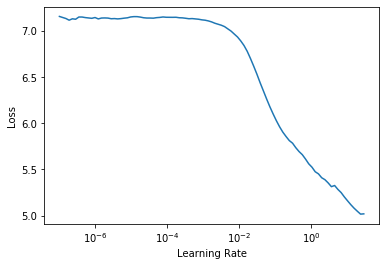

In [11]:
learn.lr_find(end_lr=100)

In [12]:
# fp32, 4.1GB
learn.fit_one_cycle(5, 4e-2)

In [10]:
learn = Learner(dls, resnet18(), metrics=accuracy, opt_func=adahessian, 
                loss_func=LabelSmoothingCrossEntropy()).to_fp16_adahessian() 

In [11]:
# fp16, 5.1GB
learn.fit_one_cycle(5, 4e-2)

Gradient overflow, exiting batch 

Gradient overflow, exiting batch 



Gradient overflow, exiting batch 

Gradient overflow, exiting batch 

Gradient overflow, exiting batch 



SuggestedLRs(lr_min=1.0232930183410645, lr_steep=0.0467735156416893)

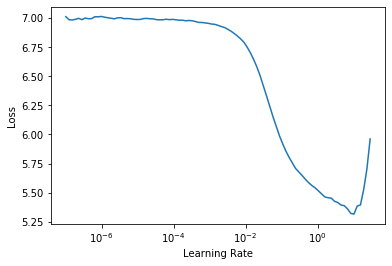

In [14]:
learn.lr_find(end_lr=100)

In [15]:
# fp16, 5.1GB
learn.fit_one_cycle(5, 4e-2)

Gradient overflow, exiting batch 

Gradient overflow, exiting batch 



In [18]:
#fp16
learn.fit_one_cycle(5, 4e-2)

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-30272., device='cuda:0', grad_fn=<MinBackward1>), tensor(-565.4946, device='cuda:0', grad_fn=<MeanBackward0>), tensor(14872., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4619, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0086, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2269, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-654., device='cuda:0'), tensor(-2.7860, device='cuda:0'), tensor(158.7500, device='cuda:0')) 

hvs min, mean max: (tensor(-654., device='cuda:0'), tensor(-2.7860, device='cuda:0'), tensor(158.7500, device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-18192., device='cuda:0', grad_fn=<MinBackward1>), tensor(760.8840, device='cuda:0', grad_fn=<MeanBackward0>), tensor(43904., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean

hvs min, mean max: (tensor(-233.5000, device='cuda:0'), tensor(-5.0437, device='cuda:0'), tensor(53.0938, device='cuda:0')) 

hvs min, mean max: (tensor(-233.5000, device='cuda:0'), tensor(-5.0437, device='cuda:0'), tensor(53.0938, device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-26928., device='cuda:0', grad_fn=<MinBackward1>), tensor(-132.2264, device='cuda:0', grad_fn=<MeanBackward0>), tensor(24608., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4109, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0020, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3755, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-754., device='cuda:0'), tensor(-16.6137, device='cuda:0'), tensor(177.1250, device='cuda:0')) 

hvs min, mean max: (tensor(-754., device='cuda:0'), tensor(-16.6137, device='cuda:0'), tensor(177.1250, device='cuda:0')) 

scale in step is: 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-19424., device='cuda:0', grad_fn=<MinBackward1>), tensor(168.1086, device='cuda:0', grad_fn=<MeanBackward0>), tensor(23328., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.2964, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0026, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3560, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-124.1250, device='cuda:0'), tensor(2.3589, device='cuda:0'), tensor(411.2500, device='cuda:0')) 

hvs min, mean max: (tensor(-124.1250, device='cuda:0'), tensor(2.3589, device='cuda:0'), tensor(411.2500, device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-21120., device='cuda:0', grad_fn=<MinBackward1>), tensor(-481.2622, device='cuda:0', grad_fn=<MeanBackward0>), tensor(15672., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min,

hvs min, mean max: (tensor(-573.5000, device='cuda:0'), tensor(5.8453, device='cuda:0'), tensor(1171., device='cuda:0')) 

hvs min, mean max: (tensor(-573.5000, device='cuda:0'), tensor(5.8453, device='cuda:0'), tensor(1171., device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-13936., device='cuda:0', grad_fn=<MinBackward1>), tensor(-34.8691, device='cuda:0', grad_fn=<MeanBackward0>), tensor(16688., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.2126, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0005, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2546, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-1555., device='cuda:0'), tensor(4.5566, device='cuda:0'), tensor(892.5000, device='cuda:0')) 

hvs min, mean max: (tensor(-1555., device='cuda:0'), tensor(4.5566, device='cuda:0'), tensor(892.5000, device='cuda:0')) 

scale in step is: 65536.0 


scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-24208., device='cuda:0', grad_fn=<MinBackward1>), tensor(-963.3852, device='cuda:0', grad_fn=<MeanBackward0>), tensor(21968., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3694, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0147, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3352, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-5888., device='cuda:0'), tensor(-98.0775, device='cuda:0'), tensor(1356., device='cuda:0')) 

hvs min, mean max: (tensor(-5888., device='cuda:0'), tensor(-98.0775, device='cuda:0'), tensor(1356., device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-17520., device='cuda:0', grad_fn=<MinBackward1>), tensor(-237.9720, device='cuda:0', grad_fn=<MeanBackward0>), tensor(14688., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean 

hvs min, mean max: (tensor(-768.5000, device='cuda:0'), tensor(26.1733, device='cuda:0'), tensor(1058., device='cuda:0')) 

hvs min, mean max: (tensor(-768.5000, device='cuda:0'), tensor(26.1733, device='cuda:0'), tensor(1058., device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-16192., device='cuda:0', grad_fn=<MinBackward1>), tensor(31.8664, device='cuda:0', grad_fn=<MeanBackward0>), tensor(28336., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.2471, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4324, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-2276., device='cuda:0'), tensor(12.2764, device='cuda:0'), tensor(3520., device='cuda:0')) 

hvs min, mean max: (tensor(-2276., device='cuda:0'), tensor(12.2764, device='cuda:0'), tensor(3520., device='cuda:0')) 

scale in step is: 65536.0 

sca

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-12936., device='cuda:0', grad_fn=<MinBackward1>), tensor(1000.4338, device='cuda:0', grad_fn=<MeanBackward0>), tensor(26656., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.1974, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0153, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4067, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-5536., device='cuda:0'), tensor(-63.1366, device='cuda:0'), tensor(932., device='cuda:0')) 

hvs min, mean max: (tensor(-5536., device='cuda:0'), tensor(-63.1366, device='cuda:0'), tensor(932., device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-18880., device='cuda:0', grad_fn=<MinBackward1>), tensor(-13.8897, device='cuda:0', grad_fn=<MeanBackward0>), tensor(16384., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max:

hvs min, mean max: (tensor(-1016., device='cuda:0'), tensor(-24.8597, device='cuda:0'), tensor(223.1250, device='cuda:0')) 

hvs min, mean max: (tensor(-1016., device='cuda:0'), tensor(-24.8597, device='cuda:0'), tensor(223.1250, device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-24000., device='cuda:0', grad_fn=<MinBackward1>), tensor(-32.8170, device='cuda:0', grad_fn=<MeanBackward0>), tensor(20560., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3662, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0005, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3137, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-614., device='cuda:0'), tensor(1.0701, device='cuda:0'), tensor(616.5000, device='cuda:0')) 

hvs min, mean max: (tensor(-614., device='cuda:0'), tensor(1.0701, device='cuda:0'), tensor(616.5000, device='cuda:0')) 

scale in step is: 65536.0

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-32928., device='cuda:0', grad_fn=<MinBackward1>), tensor(-534.1478, device='cuda:0', grad_fn=<MeanBackward0>), tensor(19504., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5024, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0082, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2976, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-39.1562, device='cuda:0'), tensor(0.3379, device='cuda:0'), tensor(66.8750, device='cuda:0')) 

hvs min, mean max: (tensor(-39.1562, device='cuda:0'), tensor(0.3379, device='cuda:0'), tensor(66.8750, device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-13720., device='cuda:0', grad_fn=<MinBackward1>), tensor(171.1906, device='cuda:0', grad_fn=<MeanBackward0>), tensor(26288., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, me

hvs min, mean max: (tensor(-230.1250, device='cuda:0'), tensor(1.8378, device='cuda:0'), tensor(294.5000, device='cuda:0')) 

hvs min, mean max: (tensor(-230.1250, device='cuda:0'), tensor(1.8378, device='cuda:0'), tensor(294.5000, device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-18432., device='cuda:0', grad_fn=<MinBackward1>), tensor(-561.5536, device='cuda:0', grad_fn=<MeanBackward0>), tensor(14816., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.2812, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0086, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2261, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-112.5625, device='cuda:0'), tensor(1.4879, device='cuda:0'), tensor(124.5000, device='cuda:0')) 

hvs min, mean max: (tensor(-112.5625, device='cuda:0'), tensor(1.4879, device='cuda:0'), tensor(124.5000, device='cuda:0')) 

scale in step 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-33824., device='cuda:0', grad_fn=<MinBackward1>), tensor(-164.4898, device='cuda:0', grad_fn=<MeanBackward0>), tensor(54368., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5161, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0025, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8296, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-182., device='cuda:0'), tensor(5.1552, device='cuda:0'), tensor(498., device='cuda:0')) 

hvs min, mean max: (tensor(-182., device='cuda:0'), tensor(5.1552, device='cuda:0'), tensor(498., device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-24912., device='cuda:0', grad_fn=<MinBackward1>), tensor(373.4893, device='cuda:0', grad_fn=<MeanBackward0>), tensor(28864., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (ten

hvs min, mean max: (tensor(-213.1250, device='cuda:0'), tensor(-6.0848, device='cuda:0'), tensor(120.5000, device='cuda:0')) 

hvs min, mean max: (tensor(-213.1250, device='cuda:0'), tensor(-6.0848, device='cuda:0'), tensor(120.5000, device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-40064., device='cuda:0', grad_fn=<MinBackward1>), tensor(148.0765, device='cuda:0', grad_fn=<MeanBackward0>), tensor(41248., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.6113, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0023, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6294, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-302.7500, device='cuda:0'), tensor(7.3008, device='cuda:0'), tensor(877., device='cuda:0')) 

hvs min, mean max: (tensor(-302.7500, device='cuda:0'), tensor(7.3008, device='cuda:0'), tensor(877., device='cuda:0')) 

scale in step is: 6553

scale in _backward is: 32768.0 

PRE UNSCALE gradsH min, mean max: (tensor(-14928., device='cuda:0', grad_fn=<MinBackward1>), tensor(-89.5075, device='cuda:0', grad_fn=<MeanBackward0>), tensor(8400., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4556, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0027, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2563, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-157.6250, device='cuda:0'), tensor(4.5899, device='cuda:0'), tensor(235.8750, device='cuda:0')) 

hvs min, mean max: (tensor(-157.6250, device='cuda:0'), tensor(4.5899, device='cuda:0'), tensor(235.8750, device='cuda:0')) 

scale in step is: 32768.0 

scale in _backward is: 32768.0 

PRE UNSCALE gradsH min, mean max: (tensor(-15328., device='cuda:0', grad_fn=<MinBackward1>), tensor(-640.7131, device='cuda:0', grad_fn=<MeanBackward0>), tensor(15064., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min,

hvs min, mean max: (tensor(-180.6250, device='cuda:0'), tensor(-6.1728, device='cuda:0'), tensor(99.5625, device='cuda:0')) 

hvs min, mean max: (tensor(-180.6250, device='cuda:0'), tensor(-6.1728, device='cuda:0'), tensor(99.5625, device='cuda:0')) 

scale in step is: 32768.0 

scale in _backward is: 32768.0 

PRE UNSCALE gradsH min, mean max: (tensor(-24560., device='cuda:0', grad_fn=<MinBackward1>), tensor(-429.1495, device='cuda:0', grad_fn=<MeanBackward0>), tensor(14328., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.7495, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0131, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4373, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-115.6875, device='cuda:0'), tensor(0.5882, device='cuda:0'), tensor(110.8125, device='cuda:0')) 

hvs min, mean max: (tensor(-115.6875, device='cuda:0'), tensor(0.5882, device='cuda:0'), tensor(110.8125, device='cuda:0')) 

scale in step 

scale in _backward is: 32768.0 

PRE UNSCALE gradsH min, mean max: (tensor(-18080., device='cuda:0', grad_fn=<MinBackward1>), tensor(252.3346, device='cuda:0', grad_fn=<MeanBackward0>), tensor(18752., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5518, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0077, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5723, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-80.2500, device='cuda:0'), tensor(-0.2508, device='cuda:0'), tensor(145.3750, device='cuda:0')) 

hvs min, mean max: (tensor(-80.2500, device='cuda:0'), tensor(-0.2508, device='cuda:0'), tensor(145.3750, device='cuda:0')) 

scale in step is: 32768.0 

scale in _backward is: 32768.0 

PRE UNSCALE gradsH min, mean max: (tensor(-31168., device='cuda:0', grad_fn=<MinBackward1>), tensor(-396.2935, device='cuda:0', grad_fn=<MeanBackward0>), tensor(11552., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min,

hvs min, mean max: (tensor(-65.5000, device='cuda:0'), tensor(3.3251, device='cuda:0'), tensor(103.5000, device='cuda:0')) 

hvs min, mean max: (tensor(-65.5000, device='cuda:0'), tensor(3.3251, device='cuda:0'), tensor(103.5000, device='cuda:0')) 

scale in step is: 32768.0 

scale in _backward is: 32768.0 

PRE UNSCALE gradsH min, mean max: (tensor(-23632., device='cuda:0', grad_fn=<MinBackward1>), tensor(-218.8385, device='cuda:0', grad_fn=<MeanBackward0>), tensor(8224., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.7212, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0067, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2510, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-125.5000, device='cuda:0'), tensor(4.3256, device='cuda:0'), tensor(371., device='cuda:0')) 

hvs min, mean max: (tensor(-125.5000, device='cuda:0'), tensor(4.3256, device='cuda:0'), tensor(371., device='cuda:0')) 

scale in step is: 32768.0

scale in _backward is: 32768.0 

PRE UNSCALE gradsH min, mean max: (tensor(-16264., device='cuda:0', grad_fn=<MinBackward1>), tensor(588.3965, device='cuda:0', grad_fn=<MeanBackward0>), tensor(13344., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4963, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0180, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4072, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-161.8750, device='cuda:0'), tensor(-0.9577, device='cuda:0'), tensor(342.5000, device='cuda:0')) 

hvs min, mean max: (tensor(-161.8750, device='cuda:0'), tensor(-0.9577, device='cuda:0'), tensor(342.5000, device='cuda:0')) 

scale in step is: 32768.0 

scale in _backward is: 32768.0 

PRE UNSCALE gradsH min, mean max: (tensor(-16544., device='cuda:0', grad_fn=<MinBackward1>), tensor(937.1435, device='cuda:0', grad_fn=<MeanBackward0>), tensor(42112., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min

hvs min, mean max: (tensor(-71.1875, device='cuda:0'), tensor(-2.3186, device='cuda:0'), tensor(62.9688, device='cuda:0')) 

hvs min, mean max: (tensor(-71.1875, device='cuda:0'), tensor(-2.3186, device='cuda:0'), tensor(62.9688, device='cuda:0')) 

scale in step is: 32768.0 

scale in _backward is: 32768.0 

PRE UNSCALE gradsH min, mean max: (tensor(-26992., device='cuda:0', grad_fn=<MinBackward1>), tensor(-485.8149, device='cuda:0', grad_fn=<MeanBackward0>), tensor(17344., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.8237, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0148, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5293, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-82.8125, device='cuda:0'), tensor(-1.6159, device='cuda:0'), tensor(232.8750, device='cuda:0')) 

hvs min, mean max: (tensor(-82.8125, device='cuda:0'), tensor(-1.6159, device='cuda:0'), tensor(232.8750, device='cuda:0')) 

scale in step is

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-10392., device='cuda:0', grad_fn=<MinBackward1>), tensor(-166.3365, device='cuda:0', grad_fn=<MeanBackward0>), tensor(11880., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.6343, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0102, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7251, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-55.7812, device='cuda:0'), tensor(1.0579, device='cuda:0'), tensor(103.8750, device='cuda:0')) 

hvs min, mean max: (tensor(-55.7812, device='cuda:0'), tensor(1.0579, device='cuda:0'), tensor(103.8750, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-8656., device='cuda:0', grad_fn=<MinBackward1>), tensor(23.1191, device='cuda:0', grad_fn=<MeanBackward0>), tensor(11048., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, me

hvs min, mean max: (tensor(-210.1250, device='cuda:0'), tensor(-3.4611, device='cuda:0'), tensor(74.6250, device='cuda:0')) 

hvs min, mean max: (tensor(-210.1250, device='cuda:0'), tensor(-3.4611, device='cuda:0'), tensor(74.6250, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-9984., device='cuda:0', grad_fn=<MinBackward1>), tensor(-244.9918, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5124., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.6094, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0150, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3127, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-133.3750, device='cuda:0'), tensor(4.4288, device='cuda:0'), tensor(416.7500, device='cuda:0')) 

hvs min, mean max: (tensor(-133.3750, device='cuda:0'), tensor(4.4288, device='cuda:0'), tensor(416.7500, device='cuda:0')) 

scale in step is

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-10696., device='cuda:0', grad_fn=<MinBackward1>), tensor(-95.8548, device='cuda:0', grad_fn=<MeanBackward0>), tensor(16384., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.6528, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0059, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1., device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-45.8750, device='cuda:0'), tensor(2.5094, device='cuda:0'), tensor(148., device='cuda:0')) 

hvs min, mean max: (tensor(-45.8750, device='cuda:0'), tensor(2.5094, device='cuda:0'), tensor(148., device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-7536., device='cuda:0', grad_fn=<MinBackward1>), tensor(-114.8869, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5564., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (ten

hvs min, mean max: (tensor(-92.6875, device='cuda:0'), tensor(-2.0346, device='cuda:0'), tensor(35.6875, device='cuda:0')) 

hvs min, mean max: (tensor(-92.6875, device='cuda:0'), tensor(-2.0346, device='cuda:0'), tensor(35.6875, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-7264., device='cuda:0', grad_fn=<MinBackward1>), tensor(148.2798, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5596., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4434, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0091, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3416, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-58.5312, device='cuda:0'), tensor(-0.2652, device='cuda:0'), tensor(77.2500, device='cuda:0')) 

hvs min, mean max: (tensor(-58.5312, device='cuda:0'), tensor(-0.2652, device='cuda:0'), tensor(77.2500, device='cuda:0')) 

scale in step is: 1638

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-7176., device='cuda:0', grad_fn=<MinBackward1>), tensor(-43.0697, device='cuda:0', grad_fn=<MeanBackward0>), tensor(13632., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4380, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0026, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8320, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-88.1250, device='cuda:0'), tensor(1.4895, device='cuda:0'), tensor(221.3750, device='cuda:0')) 

hvs min, mean max: (tensor(-88.1250, device='cuda:0'), tensor(1.4895, device='cuda:0'), tensor(221.3750, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-7608., device='cuda:0', grad_fn=<MinBackward1>), tensor(6.0984, device='cuda:0', grad_fn=<MeanBackward0>), tensor(14920., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean 

hvs min, mean max: (tensor(-82.5625, device='cuda:0'), tensor(1.8203, device='cuda:0'), tensor(159.6250, device='cuda:0')) 

hvs min, mean max: (tensor(-82.5625, device='cuda:0'), tensor(1.8203, device='cuda:0'), tensor(159.6250, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-8100., device='cuda:0', grad_fn=<MinBackward1>), tensor(199.5978, device='cuda:0', grad_fn=<MeanBackward0>), tensor(12272., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4944, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0122, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7490, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-81.6250, device='cuda:0'), tensor(5.7977, device='cuda:0'), tensor(144., device='cuda:0')) 

hvs min, mean max: (tensor(-81.6250, device='cuda:0'), tensor(5.7977, device='cuda:0'), tensor(144., device='cuda:0')) 

scale in step is: 16384.0 

s

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-9600., device='cuda:0', grad_fn=<MinBackward1>), tensor(-265.9827, device='cuda:0', grad_fn=<MeanBackward0>), tensor(14784., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5859, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0162, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9023, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-113.1875, device='cuda:0'), tensor(-1.4485, device='cuda:0'), tensor(115.1250, device='cuda:0')) 

hvs min, mean max: (tensor(-113.1875, device='cuda:0'), tensor(-1.4485, device='cuda:0'), tensor(115.1250, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-12056., device='cuda:0', grad_fn=<MinBackward1>), tensor(147.0890, device='cuda:0', grad_fn=<MeanBackward0>), tensor(7484., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min

hvs min, mean max: (tensor(-437.7500, device='cuda:0'), tensor(-9.1371, device='cuda:0'), tensor(71.8750, device='cuda:0')) 

hvs min, mean max: (tensor(-437.7500, device='cuda:0'), tensor(-9.1371, device='cuda:0'), tensor(71.8750, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-6776., device='cuda:0', grad_fn=<MinBackward1>), tensor(246.2772, device='cuda:0', grad_fn=<MeanBackward0>), tensor(14976., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4136, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0150, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9141, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-147.7500, device='cuda:0'), tensor(5.4801, device='cuda:0'), tensor(308.2500, device='cuda:0')) 

hvs min, mean max: (tensor(-147.7500, device='cuda:0'), tensor(5.4801, device='cuda:0'), tensor(308.2500, device='cuda:0')) 

scale in step is:

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-9744., device='cuda:0', grad_fn=<MinBackward1>), tensor(-67.2950, device='cuda:0', grad_fn=<MeanBackward0>), tensor(3982., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-1.1895, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0082, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4861, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-419.5000, device='cuda:0'), tensor(-1.1515, device='cuda:0'), tensor(130., device='cuda:0')) 

hvs min, mean max: (tensor(-419.5000, device='cuda:0'), tensor(-1.1515, device='cuda:0'), tensor(130., device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-10912., device='cuda:0', grad_fn=<MinBackward1>), tensor(3.7172, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4988., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (te

hvs min, mean max: (tensor(-109.9375, device='cuda:0'), tensor(0.7902, device='cuda:0'), tensor(209.8750, device='cuda:0')) 

hvs min, mean max: (tensor(-109.9375, device='cuda:0'), tensor(0.7902, device='cuda:0'), tensor(209.8750, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-3280., device='cuda:0', grad_fn=<MinBackward1>), tensor(83.6717, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4368., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4004, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0102, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5332, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-40.0625, device='cuda:0'), tensor(2.6756, device='cuda:0'), tensor(146.6250, device='cuda:0')) 

hvs min, mean max: (tensor(-40.0625, device='cuda:0'), tensor(2.6756, device='cuda:0'), tensor(146.6250, device='cuda:0')) 

scale in step is: 8192.

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-3166., device='cuda:0', grad_fn=<MinBackward1>), tensor(217.9978, device='cuda:0', grad_fn=<MeanBackward0>), tensor(10520., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3865, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0266, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.2842, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-129.7500, device='cuda:0'), tensor(5.4846, device='cuda:0'), tensor(255.2500, device='cuda:0')) 

hvs min, mean max: (tensor(-129.7500, device='cuda:0'), tensor(5.4846, device='cuda:0'), tensor(255.2500, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-3302., device='cuda:0', grad_fn=<MinBackward1>), tensor(95.5910, device='cuda:0', grad_fn=<MeanBackward0>), tensor(10248., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean m

hvs min, mean max: (tensor(-128.5000, device='cuda:0'), tensor(4.7537, device='cuda:0'), tensor(243.5000, device='cuda:0')) 

hvs min, mean max: (tensor(-128.5000, device='cuda:0'), tensor(4.7537, device='cuda:0'), tensor(243.5000, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-9408., device='cuda:0', grad_fn=<MinBackward1>), tensor(-61.0938, device='cuda:0', grad_fn=<MeanBackward0>), tensor(3910., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-1.1484, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0075, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4773, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-72.3125, device='cuda:0'), tensor(-1.4767, device='cuda:0'), tensor(71.3125, device='cuda:0')) 

hvs min, mean max: (tensor(-72.3125, device='cuda:0'), tensor(-1.4767, device='cuda:0'), tensor(71.3125, device='cuda:0')) 

scale in step is: 819

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-3324., device='cuda:0', grad_fn=<MinBackward1>), tensor(205.8868, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5428., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4058, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6626, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-95.6250, device='cuda:0'), tensor(-0.2881, device='cuda:0'), tensor(276.7500, device='cuda:0')) 

hvs min, mean max: (tensor(-95.6250, device='cuda:0'), tensor(-0.2881, device='cuda:0'), tensor(276.7500, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-6024., device='cuda:0', grad_fn=<MinBackward1>), tensor(14.0593, device='cuda:0', grad_fn=<MeanBackward0>), tensor(6648., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max

hvs min, mean max: (tensor(-297.7500, device='cuda:0'), tensor(-1.6019, device='cuda:0'), tensor(213.7500, device='cuda:0')) 

hvs min, mean max: (tensor(-297.7500, device='cuda:0'), tensor(-1.6019, device='cuda:0'), tensor(213.7500, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-6464., device='cuda:0', grad_fn=<MinBackward1>), tensor(-156.2881, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5936., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.7891, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0191, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7246, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-172.2500, device='cuda:0'), tensor(-1.2185, device='cuda:0'), tensor(97., device='cuda:0')) 

hvs min, mean max: (tensor(-172.2500, device='cuda:0'), tensor(-1.2185, device='cuda:0'), tensor(97., device='cuda:0')) 

scale in step is: 8192.0

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-6756., device='cuda:0', grad_fn=<MinBackward1>), tensor(186.9792, device='cuda:0', grad_fn=<MeanBackward0>), tensor(6264., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.8247, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0228, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7646, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-145.1250, device='cuda:0'), tensor(0.9915, device='cuda:0'), tensor(122.3750, device='cuda:0')) 

hvs min, mean max: (tensor(-145.1250, device='cuda:0'), tensor(0.9915, device='cuda:0'), tensor(122.3750, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-5124., device='cuda:0', grad_fn=<MinBackward1>), tensor(-17.3288, device='cuda:0', grad_fn=<MeanBackward0>), tensor(2174., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean ma

hvs min, mean max: (tensor(-202.6250, device='cuda:0'), tensor(-3.1611, device='cuda:0'), tensor(112.6250, device='cuda:0')) 

hvs min, mean max: (tensor(-202.6250, device='cuda:0'), tensor(-3.1611, device='cuda:0'), tensor(112.6250, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-7488., device='cuda:0', grad_fn=<MinBackward1>), tensor(-136.6577, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5312., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.9141, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0167, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6484, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-78.7500, device='cuda:0'), tensor(3.7017, device='cuda:0'), tensor(160.2500, device='cuda:0')) 

hvs min, mean max: (tensor(-78.7500, device='cuda:0'), tensor(3.7017, device='cuda:0'), tensor(160.2500, device='cuda:0')) 

scale in step is: 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4348., device='cuda:0', grad_fn=<MinBackward1>), tensor(-85.4694, device='cuda:0', grad_fn=<MeanBackward0>), tensor(3018., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5308, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0104, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3684, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-53.1250, device='cuda:0'), tensor(2.3803, device='cuda:0'), tensor(119.5000, device='cuda:0')) 

hvs min, mean max: (tensor(-53.1250, device='cuda:0'), tensor(2.3803, device='cuda:0'), tensor(119.5000, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-5256., device='cuda:0', grad_fn=<MinBackward1>), tensor(5.6383, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4552., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: 

hvs min, mean max: (tensor(-415.7500, device='cuda:0'), tensor(-5.9649, device='cuda:0'), tensor(173.6250, device='cuda:0')) 

hvs min, mean max: (tensor(-415.7500, device='cuda:0'), tensor(-5.9649, device='cuda:0'), tensor(173.6250, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4232., device='cuda:0', grad_fn=<MinBackward1>), tensor(154.5204, device='cuda:0', grad_fn=<MeanBackward0>), tensor(11344., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5166, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0189, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.3848, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-438.2500, device='cuda:0'), tensor(-7.1907, device='cuda:0'), tensor(73.6250, device='cuda:0')) 

hvs min, mean max: (tensor(-438.2500, device='cuda:0'), tensor(-7.1907, device='cuda:0'), tensor(73.6250, device='cuda:0')) 

scale in step is:

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-6508., device='cuda:0', grad_fn=<MinBackward1>), tensor(-8.6743, device='cuda:0', grad_fn=<MeanBackward0>), tensor(11584., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.7944, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0011, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.4141, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-321.7500, device='cuda:0'), tensor(-1.6797, device='cuda:0'), tensor(152.2500, device='cuda:0')) 

hvs min, mean max: (tensor(-321.7500, device='cuda:0'), tensor(-1.6797, device='cuda:0'), tensor(152.2500, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-7268., device='cuda:0', grad_fn=<MinBackward1>), tensor(16.6669, device='cuda:0', grad_fn=<MeanBackward0>), tensor(7856., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean 

hvs min, mean max: (tensor(-193.6250, device='cuda:0'), tensor(-5.5993, device='cuda:0'), tensor(51.1875, device='cuda:0')) 

hvs min, mean max: (tensor(-193.6250, device='cuda:0'), tensor(-5.5993, device='cuda:0'), tensor(51.1875, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-5428., device='cuda:0', grad_fn=<MinBackward1>), tensor(-35.2723, device='cuda:0', grad_fn=<MeanBackward0>), tensor(6064., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.6626, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0043, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7402, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-75.7500, device='cuda:0'), tensor(9.5706, device='cuda:0'), tensor(367.7500, device='cuda:0')) 

hvs min, mean max: (tensor(-75.7500, device='cuda:0'), tensor(9.5706, device='cuda:0'), tensor(367.7500, device='cuda:0')) 

scale in step is: 819

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-5084., device='cuda:0', grad_fn=<MinBackward1>), tensor(141.5379, device='cuda:0', grad_fn=<MeanBackward0>), tensor(10664., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.6206, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0173, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.3018, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-147., device='cuda:0'), tensor(-0.2833, device='cuda:0'), tensor(134.3750, device='cuda:0')) 

hvs min, mean max: (tensor(-147., device='cuda:0'), tensor(-0.2833, device='cuda:0'), tensor(134.3750, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4288., device='cuda:0', grad_fn=<MinBackward1>), tensor(140.0791, device='cuda:0', grad_fn=<MeanBackward0>), tensor(6192., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (t

hvs min, mean max: (tensor(-90.7500, device='cuda:0'), tensor(-0.4381, device='cuda:0'), tensor(131.6250, device='cuda:0')) 

hvs min, mean max: (tensor(-90.7500, device='cuda:0'), tensor(-0.4381, device='cuda:0'), tensor(131.6250, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4224., device='cuda:0', grad_fn=<MinBackward1>), tensor(47.2954, device='cuda:0', grad_fn=<MeanBackward0>), tensor(7188., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5156, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0058, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8774, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-103.3750, device='cuda:0'), tensor(-0.7851, device='cuda:0'), tensor(55., device='cuda:0')) 

hvs min, mean max: (tensor(-103.3750, device='cuda:0'), tensor(-0.7851, device='cuda:0'), tensor(55., device='cuda:0')) 

scale in step is: 8192.0 

sc

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-9896., device='cuda:0', grad_fn=<MinBackward1>), tensor(-49.3505, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5016., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-1.2080, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0060, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6123, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-244.7500, device='cuda:0'), tensor(-7.6047, device='cuda:0'), tensor(105.1875, device='cuda:0')) 

hvs min, mean max: (tensor(-244.7500, device='cuda:0'), tensor(-7.6047, device='cuda:0'), tensor(105.1875, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-3486., device='cuda:0', grad_fn=<MinBackward1>), tensor(276.9947, device='cuda:0', grad_fn=<MeanBackward0>), tensor(6296., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean

hvs min, mean max: (tensor(-112.9375, device='cuda:0'), tensor(2.3725, device='cuda:0'), tensor(192.2500, device='cuda:0')) 

hvs min, mean max: (tensor(-112.9375, device='cuda:0'), tensor(2.3725, device='cuda:0'), tensor(192.2500, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-3758., device='cuda:0', grad_fn=<MinBackward1>), tensor(-187.5067, device='cuda:0', grad_fn=<MeanBackward0>), tensor(2810., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4587, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0229, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3430, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-211.7500, device='cuda:0'), tensor(-7.4695, device='cuda:0'), tensor(88.0625, device='cuda:0')) 

hvs min, mean max: (tensor(-211.7500, device='cuda:0'), tensor(-7.4695, device='cuda:0'), tensor(88.0625, device='cuda:0')) 

scale in step is: 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-3788., device='cuda:0', grad_fn=<MinBackward1>), tensor(48.5714, device='cuda:0', grad_fn=<MeanBackward0>), tensor(3678., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4624, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0059, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4490, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-119.8750, device='cuda:0'), tensor(0.7110, device='cuda:0'), tensor(172., device='cuda:0')) 

hvs min, mean max: (tensor(-119.8750, device='cuda:0'), tensor(0.7110, device='cuda:0'), tensor(172., device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-9352., device='cuda:0', grad_fn=<MinBackward1>), tensor(-92.5608, device='cuda:0', grad_fn=<MeanBackward0>), tensor(2766., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tenso

hvs min, mean max: (tensor(-129.1250, device='cuda:0'), tensor(-3.3084, device='cuda:0'), tensor(51.9062, device='cuda:0')) 

hvs min, mean max: (tensor(-129.1250, device='cuda:0'), tensor(-3.3084, device='cuda:0'), tensor(51.9062, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4552., device='cuda:0', grad_fn=<MinBackward1>), tensor(460.9584, device='cuda:0', grad_fn=<MeanBackward0>), tensor(9752., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5557, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0563, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.1904, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-178.2500, device='cuda:0'), tensor(-6.2767, device='cuda:0'), tensor(81.3750, device='cuda:0')) 

hvs min, mean max: (tensor(-178.2500, device='cuda:0'), tensor(-6.2767, device='cuda:0'), tensor(81.3750, device='cuda:0')) 

scale in step is: 81

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-2734., device='cuda:0', grad_fn=<MinBackward1>), tensor(68.6663, device='cuda:0', grad_fn=<MeanBackward0>), tensor(6840., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3337, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0084, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8350, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-319.7500, device='cuda:0'), tensor(-8.6598, device='cuda:0'), tensor(72.0625, device='cuda:0')) 

hvs min, mean max: (tensor(-319.7500, device='cuda:0'), tensor(-8.6598, device='cuda:0'), tensor(72.0625, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-7316., device='cuda:0', grad_fn=<MinBackward1>), tensor(-109.5484, device='cuda:0', grad_fn=<MeanBackward0>), tensor(3916., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean ma

hvs min, mean max: (tensor(-250.2500, device='cuda:0'), tensor(-6.8676, device='cuda:0'), tensor(91.8750, device='cuda:0')) 

hvs min, mean max: (tensor(-250.2500, device='cuda:0'), tensor(-6.8676, device='cuda:0'), tensor(91.8750, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-5392., device='cuda:0', grad_fn=<MinBackward1>), tensor(60.0645, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4352., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.6582, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0073, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5312, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-99.4375, device='cuda:0'), tensor(4.8885, device='cuda:0'), tensor(218.2500, device='cuda:0')) 

hvs min, mean max: (tensor(-99.4375, device='cuda:0'), tensor(4.8885, device='cuda:0'), tensor(218.2500, device='cuda:0')) 

scale in step is: 8192.

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-8004., device='cuda:0', grad_fn=<MinBackward1>), tensor(-231.4497, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4472., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.9771, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0283, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5459, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-124.3750, device='cuda:0'), tensor(2.2007, device='cuda:0'), tensor(117.3125, device='cuda:0')) 

hvs min, mean max: (tensor(-124.3750, device='cuda:0'), tensor(2.2007, device='cuda:0'), tensor(117.3125, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-3312., device='cuda:0', grad_fn=<MinBackward1>), tensor(166.7917, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5804., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean 

hvs min, mean max: (tensor(-140.6250, device='cuda:0'), tensor(-3.4296, device='cuda:0'), tensor(131.3750, device='cuda:0')) 

hvs min, mean max: (tensor(-140.6250, device='cuda:0'), tensor(-3.4296, device='cuda:0'), tensor(131.3750, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4288., device='cuda:0', grad_fn=<MinBackward1>), tensor(-137.2364, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5192., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5234, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0168, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6338, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-53.5625, device='cuda:0'), tensor(-0.0828, device='cuda:0'), tensor(72.6250, device='cuda:0')) 

hvs min, mean max: (tensor(-53.5625, device='cuda:0'), tensor(-0.0828, device='cuda:0'), tensor(72.6250, device='cuda:0')) 

scale in step is: 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-9280., device='cuda:0', grad_fn=<MinBackward1>), tensor(-44.4664, device='cuda:0', grad_fn=<MeanBackward0>), tensor(7368., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-1.1328, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0054, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8994, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-122.7500, device='cuda:0'), tensor(-1.9903, device='cuda:0'), tensor(194.2500, device='cuda:0')) 

hvs min, mean max: (tensor(-122.7500, device='cuda:0'), tensor(-1.9903, device='cuda:0'), tensor(194.2500, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-9760., device='cuda:0', grad_fn=<MinBackward1>), tensor(-128.1620, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4920., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mea

hvs min, mean max: (tensor(-101.1875, device='cuda:0'), tensor(1.1007, device='cuda:0'), tensor(130.1250, device='cuda:0')) 

hvs min, mean max: (tensor(-101.1875, device='cuda:0'), tensor(1.1007, device='cuda:0'), tensor(130.1250, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-2660., device='cuda:0', grad_fn=<MinBackward1>), tensor(63.8059, device='cuda:0', grad_fn=<MeanBackward0>), tensor(3998., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3247, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0078, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4880, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-124.3750, device='cuda:0'), tensor(1.8842, device='cuda:0'), tensor(100., device='cuda:0')) 

hvs min, mean max: (tensor(-124.3750, device='cuda:0'), tensor(1.8842, device='cuda:0'), tensor(100., device='cuda:0')) 

scale in step is: 8192.0 

sc

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4848., device='cuda:0', grad_fn=<MinBackward1>), tensor(10.9855, device='cuda:0', grad_fn=<MeanBackward0>), tensor(12368., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5918, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.5098, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-88.7500, device='cuda:0'), tensor(-0.7297, device='cuda:0'), tensor(79.5625, device='cuda:0')) 

hvs min, mean max: (tensor(-88.7500, device='cuda:0'), tensor(-0.7297, device='cuda:0'), tensor(79.5625, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4568., device='cuda:0', grad_fn=<MinBackward1>), tensor(-88.6494, device='cuda:0', grad_fn=<MeanBackward0>), tensor(6396., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max:

hvs min, mean max: (tensor(-37.8125, device='cuda:0'), tensor(0.9377, device='cuda:0'), tensor(87.8125, device='cuda:0')) 

hvs min, mean max: (tensor(-37.8125, device='cuda:0'), tensor(0.9377, device='cuda:0'), tensor(87.8125, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-8944., device='cuda:0', grad_fn=<MinBackward1>), tensor(36.2741, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4224., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-1.0918, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0044, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5156, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-148., device='cuda:0'), tensor(1.0549, device='cuda:0'), tensor(123.3750, device='cuda:0')) 

hvs min, mean max: (tensor(-148., device='cuda:0'), tensor(1.0549, device='cuda:0'), tensor(123.3750, device='cuda:0')) 

scale in step is: 8192.0 

scale 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-7728., device='cuda:0', grad_fn=<MinBackward1>), tensor(-89.5502, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4356., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.9434, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0109, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5317, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-441.2500, device='cuda:0'), tensor(1.4712, device='cuda:0'), tensor(226.7500, device='cuda:0')) 

hvs min, mean max: (tensor(-441.2500, device='cuda:0'), tensor(1.4712, device='cuda:0'), tensor(226.7500, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-15736., device='cuda:0', grad_fn=<MinBackward1>), tensor(-109.4225, device='cuda:0', grad_fn=<MeanBackward0>), tensor(6408., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean

hvs min, mean max: (tensor(-590., device='cuda:0'), tensor(-11.3027, device='cuda:0'), tensor(98., device='cuda:0')) 

hvs min, mean max: (tensor(-590., device='cuda:0'), tensor(-11.3027, device='cuda:0'), tensor(98., device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-5164., device='cuda:0', grad_fn=<MinBackward1>), tensor(-105.7433, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4820., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.6304, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0129, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5884, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-147.2500, device='cuda:0'), tensor(-2.8466, device='cuda:0'), tensor(153.6250, device='cuda:0')) 

hvs min, mean max: (tensor(-147.2500, device='cuda:0'), tensor(-2.8466, device='cuda:0'), tensor(153.6250, device='cuda:0')) 

scale in step is: 8192.0 

sca

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-5372., device='cuda:0', grad_fn=<MinBackward1>), tensor(-8.2734, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4612., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.6558, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0010, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5630, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-98.3750, device='cuda:0'), tensor(-0.4582, device='cuda:0'), tensor(60.5625, device='cuda:0')) 

hvs min, mean max: (tensor(-98.3750, device='cuda:0'), tensor(-0.4582, device='cuda:0'), tensor(60.5625, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-8360., device='cuda:0', grad_fn=<MinBackward1>), tensor(7.0551, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4496., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (

hvs min, mean max: (tensor(-244.5000, device='cuda:0'), tensor(-3.2143, device='cuda:0'), tensor(120.5000, device='cuda:0')) 

hvs min, mean max: (tensor(-244.5000, device='cuda:0'), tensor(-3.2143, device='cuda:0'), tensor(120.5000, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-5376., device='cuda:0', grad_fn=<MinBackward1>), tensor(111.7346, device='cuda:0', grad_fn=<MeanBackward0>), tensor(6232., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.6562, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0136, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7607, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-416.5000, device='cuda:0'), tensor(-5.3861, device='cuda:0'), tensor(180.6250, device='cuda:0')) 

hvs min, mean max: (tensor(-416.5000, device='cuda:0'), tensor(-5.3861, device='cuda:0'), tensor(180.6250, device='cuda:0')) 

scale in step is

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-7368., device='cuda:0', grad_fn=<MinBackward1>), tensor(-84.5945, device='cuda:0', grad_fn=<MeanBackward0>), tensor(6380., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.8994, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0103, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7788, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-45.1562, device='cuda:0'), tensor(2.1019, device='cuda:0'), tensor(73.1875, device='cuda:0')) 

hvs min, mean max: (tensor(-45.1562, device='cuda:0'), tensor(2.1019, device='cuda:0'), tensor(73.1875, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4852., device='cuda:0', grad_fn=<MinBackward1>), tensor(-63.3840, device='cuda:0', grad_fn=<MeanBackward0>), tensor(6064., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: 

hvs min, mean max: (tensor(-194.2500, device='cuda:0'), tensor(-5.4581, device='cuda:0'), tensor(70.1250, device='cuda:0')) 

hvs min, mean max: (tensor(-194.2500, device='cuda:0'), tensor(-5.4581, device='cuda:0'), tensor(70.1250, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-5816., device='cuda:0', grad_fn=<MinBackward1>), tensor(-43.2556, device='cuda:0', grad_fn=<MeanBackward0>), tensor(6504., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.7100, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0053, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7939, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-47.8750, device='cuda:0'), tensor(1.5132, device='cuda:0'), tensor(113.1250, device='cuda:0')) 

hvs min, mean max: (tensor(-47.8750, device='cuda:0'), tensor(1.5132, device='cuda:0'), tensor(113.1250, device='cuda:0')) 

scale in step is: 819

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4056., device='cuda:0', grad_fn=<MinBackward1>), tensor(84.2041, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5660., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4951, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0103, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6909, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-53.5625, device='cuda:0'), tensor(6.2176, device='cuda:0'), tensor(187.5000, device='cuda:0')) 

hvs min, mean max: (tensor(-53.5625, device='cuda:0'), tensor(6.2176, device='cuda:0'), tensor(187.5000, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-3334., device='cuda:0', grad_fn=<MinBackward1>), tensor(250.6108, device='cuda:0', grad_fn=<MeanBackward0>), tensor(9312., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: 

hvs min, mean max: (tensor(-345.2500, device='cuda:0'), tensor(-10.9938, device='cuda:0'), tensor(199.1250, device='cuda:0')) 

hvs min, mean max: (tensor(-345.2500, device='cuda:0'), tensor(-10.9938, device='cuda:0'), tensor(199.1250, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-13896., device='cuda:0', grad_fn=<MinBackward1>), tensor(-478.6715, device='cuda:0', grad_fn=<MeanBackward0>), tensor(3868., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-1.6963, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0584, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4722, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-139.7500, device='cuda:0'), tensor(-2.7847, device='cuda:0'), tensor(119.6875, device='cuda:0')) 

hvs min, mean max: (tensor(-139.7500, device='cuda:0'), tensor(-2.7847, device='cuda:0'), tensor(119.6875, device='cuda:0')) 

scale in st

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-7368., device='cuda:0', grad_fn=<MinBackward1>), tensor(-41.1566, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4376., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.8994, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0050, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5342, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-155.1250, device='cuda:0'), tensor(6.5736, device='cuda:0'), tensor(268.5000, device='cuda:0')) 

hvs min, mean max: (tensor(-155.1250, device='cuda:0'), tensor(6.5736, device='cuda:0'), tensor(268.5000, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-2800., device='cuda:0', grad_fn=<MinBackward1>), tensor(177.7607, device='cuda:0', grad_fn=<MeanBackward0>), tensor(6544., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean m

hvs min, mean max: (tensor(-423.5000, device='cuda:0'), tensor(-4.6956, device='cuda:0'), tensor(254.5000, device='cuda:0')) 

hvs min, mean max: (tensor(-423.5000, device='cuda:0'), tensor(-4.6956, device='cuda:0'), tensor(254.5000, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-10472., device='cuda:0', grad_fn=<MinBackward1>), tensor(-1.8017, device='cuda:0', grad_fn=<MeanBackward0>), tensor(24944., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-1.2783, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0002, device='cuda:0', grad_fn=<MeanBackward0>), tensor(3.0449, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-151.1250, device='cuda:0'), tensor(1.1701, device='cuda:0'), tensor(430.2500, device='cuda:0')) 

hvs min, mean max: (tensor(-151.1250, device='cuda:0'), tensor(1.1701, device='cuda:0'), tensor(430.2500, device='cuda:0')) 

scale in step is

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-6696., device='cuda:0', grad_fn=<MinBackward1>), tensor(-82.4484, device='cuda:0', grad_fn=<MeanBackward0>), tensor(2840., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.8174, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0101, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3467, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-84.4375, device='cuda:0'), tensor(1.6934, device='cuda:0'), tensor(100.4375, device='cuda:0')) 

hvs min, mean max: (tensor(-84.4375, device='cuda:0'), tensor(1.6934, device='cuda:0'), tensor(100.4375, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-3574., device='cuda:0', grad_fn=<MinBackward1>), tensor(233.3959, device='cuda:0', grad_fn=<MeanBackward0>), tensor(10672., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean ma

hvs min, mean max: (tensor(-134.7500, device='cuda:0'), tensor(-3.2287, device='cuda:0'), tensor(44.2188, device='cuda:0')) 

hvs min, mean max: (tensor(-134.7500, device='cuda:0'), tensor(-3.2287, device='cuda:0'), tensor(44.2188, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-3400., device='cuda:0', grad_fn=<MinBackward1>), tensor(252.7765, device='cuda:0', grad_fn=<MeanBackward0>), tensor(9264., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4150, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0309, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.1309, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-153.1250, device='cuda:0'), tensor(0.2865, device='cuda:0'), tensor(116.7500, device='cuda:0')) 

hvs min, mean max: (tensor(-153.1250, device='cuda:0'), tensor(0.2865, device='cuda:0'), tensor(116.7500, device='cuda:0')) 

scale in step is: 81

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-8040., device='cuda:0', grad_fn=<MinBackward1>), tensor(-159.4808, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5752., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.9814, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0195, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7021, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-816., device='cuda:0'), tensor(-25.4833, device='cuda:0'), tensor(166.5000, device='cuda:0')) 

hvs min, mean max: (tensor(-816., device='cuda:0'), tensor(-25.4833, device='cuda:0'), tensor(166.5000, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4748., device='cuda:0', grad_fn=<MinBackward1>), tensor(86.8479, device='cuda:0', grad_fn=<MeanBackward0>), tensor(6724., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: 

hvs min, mean max: (tensor(-86.7500, device='cuda:0'), tensor(8.6561, device='cuda:0'), tensor(198., device='cuda:0')) 

hvs min, mean max: (tensor(-86.7500, device='cuda:0'), tensor(8.6561, device='cuda:0'), tensor(198., device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-6792., device='cuda:0', grad_fn=<MinBackward1>), tensor(12.6094, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5676., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.8291, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6929, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-72.1875, device='cuda:0'), tensor(2.4405, device='cuda:0'), tensor(95.2500, device='cuda:0')) 

hvs min, mean max: (tensor(-72.1875, device='cuda:0'), tensor(2.4405, device='cuda:0'), tensor(95.2500, device='cuda:0')) 

scale in step is: 8192.0 

scale in

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-6780., device='cuda:0', grad_fn=<MinBackward1>), tensor(-51.0526, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5560., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.8276, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0062, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6787, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-225., device='cuda:0'), tensor(-0.9217, device='cuda:0'), tensor(70., device='cuda:0')) 

hvs min, mean max: (tensor(-225., device='cuda:0'), tensor(-0.9217, device='cuda:0'), tensor(70., device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-6432., device='cuda:0', grad_fn=<MinBackward1>), tensor(-146.8400, device='cuda:0', grad_fn=<MeanBackward0>), tensor(6056., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.

hvs min, mean max: (tensor(-968., device='cuda:0'), tensor(-31.4416, device='cuda:0'), tensor(104.0625, device='cuda:0')) 

hvs min, mean max: (tensor(-968., device='cuda:0'), tensor(-31.4416, device='cuda:0'), tensor(104.0625, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-7124., device='cuda:0', grad_fn=<MinBackward1>), tensor(-179.0700, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4232., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.8696, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0219, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5166, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-708., device='cuda:0'), tensor(-17.2433, device='cuda:0'), tensor(138.5000, device='cuda:0')) 

hvs min, mean max: (tensor(-708., device='cuda:0'), tensor(-17.2433, device='cuda:0'), tensor(138.5000, device='cuda:0')) 

scale in step is: 8192.0 


scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-5760., device='cuda:0', grad_fn=<MinBackward1>), tensor(183.9739, device='cuda:0', grad_fn=<MeanBackward0>), tensor(6892., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.7031, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0225, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8413, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-202.1250, device='cuda:0'), tensor(-3.1024, device='cuda:0'), tensor(133., device='cuda:0')) 

hvs min, mean max: (tensor(-202.1250, device='cuda:0'), tensor(-3.1024, device='cuda:0'), tensor(133., device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-5072., device='cuda:0', grad_fn=<MinBackward1>), tensor(60.0010, device='cuda:0', grad_fn=<MeanBackward0>), tensor(8992., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (ten

hvs min, mean max: (tensor(-145.2500, device='cuda:0'), tensor(2.3750, device='cuda:0'), tensor(103.4375, device='cuda:0')) 

hvs min, mean max: (tensor(-145.2500, device='cuda:0'), tensor(2.3750, device='cuda:0'), tensor(103.4375, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-5096., device='cuda:0', grad_fn=<MinBackward1>), tensor(-54.1909, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4692., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.6221, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0066, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5728, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-103.2500, device='cuda:0'), tensor(4.5289, device='cuda:0'), tensor(394.7500, device='cuda:0')) 

hvs min, mean max: (tensor(-103.2500, device='cuda:0'), tensor(4.5289, device='cuda:0'), tensor(394.7500, device='cuda:0')) 

scale in step is: 8

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-5844., device='cuda:0', grad_fn=<MinBackward1>), tensor(-126.4913, device='cuda:0', grad_fn=<MeanBackward0>), tensor(2472., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.7134, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0154, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3018, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-82.9375, device='cuda:0'), tensor(0.2042, device='cuda:0'), tensor(54.4688, device='cuda:0')) 

hvs min, mean max: (tensor(-82.9375, device='cuda:0'), tensor(0.2042, device='cuda:0'), tensor(54.4688, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4680., device='cuda:0', grad_fn=<MinBackward1>), tensor(-121.2925, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4656., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max

hvs min, mean max: (tensor(-184.2500, device='cuda:0'), tensor(-3.6742, device='cuda:0'), tensor(125.8125, device='cuda:0')) 

hvs min, mean max: (tensor(-184.2500, device='cuda:0'), tensor(-3.6742, device='cuda:0'), tensor(125.8125, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-8784., device='cuda:0', grad_fn=<MinBackward1>), tensor(7.7033, device='cuda:0', grad_fn=<MeanBackward0>), tensor(6564., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-1.0723, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0009, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8013, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-35.6875, device='cuda:0'), tensor(8.3881, device='cuda:0'), tensor(124.1875, device='cuda:0')) 

hvs min, mean max: (tensor(-35.6875, device='cuda:0'), tensor(8.3881, device='cuda:0'), tensor(124.1875, device='cuda:0')) 

scale in step is: 8192

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4094., device='cuda:0', grad_fn=<MinBackward1>), tensor(307.9107, device='cuda:0', grad_fn=<MeanBackward0>), tensor(14440., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4998, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0376, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.7627, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-446.2500, device='cuda:0'), tensor(-10.8047, device='cuda:0'), tensor(125.9375, device='cuda:0')) 

hvs min, mean max: (tensor(-446.2500, device='cuda:0'), tensor(-10.8047, device='cuda:0'), tensor(125.9375, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-7124., device='cuda:0', grad_fn=<MinBackward1>), tensor(-62.4160, device='cuda:0', grad_fn=<MeanBackward0>), tensor(6848., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, me

hvs min, mean max: (tensor(-41.1875, device='cuda:0'), tensor(0.4006, device='cuda:0'), tensor(62.6250, device='cuda:0')) 

hvs min, mean max: (tensor(-41.1875, device='cuda:0'), tensor(0.4006, device='cuda:0'), tensor(62.6250, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-6040., device='cuda:0', grad_fn=<MinBackward1>), tensor(250.5701, device='cuda:0', grad_fn=<MeanBackward0>), tensor(7816., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.7373, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0306, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9541, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-150.1250, device='cuda:0'), tensor(-4.9375, device='cuda:0'), tensor(120.1250, device='cuda:0')) 

hvs min, mean max: (tensor(-150.1250, device='cuda:0'), tensor(-4.9375, device='cuda:0'), tensor(120.1250, device='cuda:0')) 

scale in step is: 8192

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4046., device='cuda:0', grad_fn=<MinBackward1>), tensor(-126.2592, device='cuda:0', grad_fn=<MeanBackward0>), tensor(2214., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4939, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0154, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2703, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-40.6250, device='cuda:0'), tensor(-0.9913, device='cuda:0'), tensor(44.2500, device='cuda:0')) 

hvs min, mean max: (tensor(-40.6250, device='cuda:0'), tensor(-0.9913, device='cuda:0'), tensor(44.2500, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4648., device='cuda:0', grad_fn=<MinBackward1>), tensor(-55.1615, device='cuda:0', grad_fn=<MeanBackward0>), tensor(3014., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean ma

hvs min, mean max: (tensor(-43.3125, device='cuda:0'), tensor(0.8222, device='cuda:0'), tensor(213.1250, device='cuda:0')) 

hvs min, mean max: (tensor(-43.3125, device='cuda:0'), tensor(0.8222, device='cuda:0'), tensor(213.1250, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-7844., device='cuda:0', grad_fn=<MinBackward1>), tensor(-201.0076, device='cuda:0', grad_fn=<MeanBackward0>), tensor(2776., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.9575, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0245, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3389, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-76.0625, device='cuda:0'), tensor(10.4839, device='cuda:0'), tensor(386.2500, device='cuda:0')) 

hvs min, mean max: (tensor(-76.0625, device='cuda:0'), tensor(10.4839, device='cuda:0'), tensor(386.2500, device='cuda:0')) 

scale in step is: 81

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-2864., device='cuda:0', grad_fn=<MinBackward1>), tensor(176.5500, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5304., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3496, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0216, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6475, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-152.3750, device='cuda:0'), tensor(-1.0154, device='cuda:0'), tensor(61.3125, device='cuda:0')) 

hvs min, mean max: (tensor(-152.3750, device='cuda:0'), tensor(-1.0154, device='cuda:0'), tensor(61.3125, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-2318., device='cuda:0', grad_fn=<MinBackward1>), tensor(14.9796, device='cuda:0', grad_fn=<MeanBackward0>), tensor(3524., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max

hvs min, mean max: (tensor(-242.8750, device='cuda:0'), tensor(4.6252, device='cuda:0'), tensor(183., device='cuda:0')) 

hvs min, mean max: (tensor(-242.8750, device='cuda:0'), tensor(4.6252, device='cuda:0'), tensor(183., device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-3498., device='cuda:0', grad_fn=<MinBackward1>), tensor(226.7822, device='cuda:0', grad_fn=<MeanBackward0>), tensor(9552., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4270, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0277, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.1660, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-114.8750, device='cuda:0'), tensor(-1.8200, device='cuda:0'), tensor(107.9375, device='cuda:0')) 

hvs min, mean max: (tensor(-114.8750, device='cuda:0'), tensor(-1.8200, device='cuda:0'), tensor(107.9375, device='cuda:0')) 

scale in step is: 8192.0 


scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-5112., device='cuda:0', grad_fn=<MinBackward1>), tensor(191.4443, device='cuda:0', grad_fn=<MeanBackward0>), tensor(9600., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.6240, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0234, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.1719, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-90.1250, device='cuda:0'), tensor(-1.2991, device='cuda:0'), tensor(59.6875, device='cuda:0')) 

hvs min, mean max: (tensor(-90.1250, device='cuda:0'), tensor(-1.2991, device='cuda:0'), tensor(59.6875, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-3522., device='cuda:0', grad_fn=<MinBackward1>), tensor(375.2841, device='cuda:0', grad_fn=<MeanBackward0>), tensor(10872., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max

hvs min, mean max: (tensor(-130.3750, device='cuda:0'), tensor(-8.0211, device='cuda:0'), tensor(165.2500, device='cuda:0')) 

hvs min, mean max: (tensor(-130.3750, device='cuda:0'), tensor(-8.0211, device='cuda:0'), tensor(165.2500, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-5088., device='cuda:0', grad_fn=<MinBackward1>), tensor(268.7570, device='cuda:0', grad_fn=<MeanBackward0>), tensor(14320., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.6211, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0328, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.7480, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-126.3125, device='cuda:0'), tensor(1.2794, device='cuda:0'), tensor(162.7500, device='cuda:0')) 

hvs min, mean max: (tensor(-126.3125, device='cuda:0'), tensor(1.2794, device='cuda:0'), tensor(162.7500, device='cuda:0')) 

scale in step is:

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-5676., device='cuda:0', grad_fn=<MinBackward1>), tensor(-98.2169, device='cuda:0', grad_fn=<MeanBackward0>), tensor(2642., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.6929, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0120, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3225, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-230.6250, device='cuda:0'), tensor(-1.6377, device='cuda:0'), tensor(42.8750, device='cuda:0')) 

hvs min, mean max: (tensor(-230.6250, device='cuda:0'), tensor(-1.6377, device='cuda:0'), tensor(42.8750, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-5560., device='cuda:0', grad_fn=<MinBackward1>), tensor(-99.4082, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1999., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean m

hvs min, mean max: (tensor(-95.6875, device='cuda:0'), tensor(3.2237, device='cuda:0'), tensor(159.7500, device='cuda:0')) 

hvs min, mean max: (tensor(-95.6875, device='cuda:0'), tensor(3.2237, device='cuda:0'), tensor(159.7500, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-8448., device='cuda:0', grad_fn=<MinBackward1>), tensor(-63.3405, device='cuda:0', grad_fn=<MeanBackward0>), tensor(7164., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-1.0312, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0077, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8745, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-82.8125, device='cuda:0'), tensor(7.5540, device='cuda:0'), tensor(328.5000, device='cuda:0')) 

hvs min, mean max: (tensor(-82.8125, device='cuda:0'), tensor(7.5540, device='cuda:0'), tensor(328.5000, device='cuda:0')) 

scale in step is: 8192.

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4840., device='cuda:0', grad_fn=<MinBackward1>), tensor(44.0316, device='cuda:0', grad_fn=<MeanBackward0>), tensor(2486., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5908, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0054, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3035, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-130.6250, device='cuda:0'), tensor(-0.5104, device='cuda:0'), tensor(122.6875, device='cuda:0')) 

hvs min, mean max: (tensor(-130.6250, device='cuda:0'), tensor(-0.5104, device='cuda:0'), tensor(122.6875, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-5084., device='cuda:0', grad_fn=<MinBackward1>), tensor(-76.8401, device='cuda:0', grad_fn=<MeanBackward0>), tensor(7896., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean m

hvs min, mean max: (tensor(-121.5000, device='cuda:0'), tensor(-3.6807, device='cuda:0'), tensor(45., device='cuda:0')) 

hvs min, mean max: (tensor(-121.5000, device='cuda:0'), tensor(-3.6807, device='cuda:0'), tensor(45., device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4600., device='cuda:0', grad_fn=<MinBackward1>), tensor(-75.1140, device='cuda:0', grad_fn=<MeanBackward0>), tensor(3612., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5615, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0092, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4409, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-185.7500, device='cuda:0'), tensor(-0.5013, device='cuda:0'), tensor(80.8750, device='cuda:0')) 

hvs min, mean max: (tensor(-185.7500, device='cuda:0'), tensor(-0.5013, device='cuda:0'), tensor(80.8750, device='cuda:0')) 

scale in step is: 8192.0 



scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-3138., device='cuda:0', grad_fn=<MinBackward1>), tensor(154.7703, device='cuda:0', grad_fn=<MeanBackward0>), tensor(10552., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3831, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0189, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.2881, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-88.3750, device='cuda:0'), tensor(5.3206, device='cuda:0'), tensor(346.5000, device='cuda:0')) 

hvs min, mean max: (tensor(-88.3750, device='cuda:0'), tensor(5.3206, device='cuda:0'), tensor(346.5000, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4996., device='cuda:0', grad_fn=<MinBackward1>), tensor(19.7288, device='cuda:0', grad_fn=<MeanBackward0>), tensor(3824., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max:

hvs min, mean max: (tensor(-200.5000, device='cuda:0'), tensor(-2.0771, device='cuda:0'), tensor(47.8125, device='cuda:0')) 

hvs min, mean max: (tensor(-200.5000, device='cuda:0'), tensor(-2.0771, device='cuda:0'), tensor(47.8125, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-7828., device='cuda:0', grad_fn=<MinBackward1>), tensor(-249.7560, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4724., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.9556, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0305, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5767, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-87.8125, device='cuda:0'), tensor(-0.2808, device='cuda:0'), tensor(145.2500, device='cuda:0')) 

hvs min, mean max: (tensor(-87.8125, device='cuda:0'), tensor(-0.2808, device='cuda:0'), tensor(145.2500, device='cuda:0')) 

scale in step is: 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4448., device='cuda:0', grad_fn=<MinBackward1>), tensor(-195.6841, device='cuda:0', grad_fn=<MeanBackward0>), tensor(3848., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5430, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0239, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4697, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-182.3750, device='cuda:0'), tensor(-3.6968, device='cuda:0'), tensor(81., device='cuda:0')) 

hvs min, mean max: (tensor(-182.3750, device='cuda:0'), tensor(-3.6968, device='cuda:0'), tensor(81., device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-6272., device='cuda:0', grad_fn=<MinBackward1>), tensor(-26.1441, device='cuda:0', grad_fn=<MeanBackward0>), tensor(2764., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (te

hvs min, mean max: (tensor(-219., device='cuda:0'), tensor(-6.0079, device='cuda:0'), tensor(49.3438, device='cuda:0')) 

hvs min, mean max: (tensor(-219., device='cuda:0'), tensor(-6.0079, device='cuda:0'), tensor(49.3438, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4066., device='cuda:0', grad_fn=<MinBackward1>), tensor(248.2241, device='cuda:0', grad_fn=<MeanBackward0>), tensor(11424., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4963, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0303, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.3945, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-53.7500, device='cuda:0'), tensor(2.1847, device='cuda:0'), tensor(135.3750, device='cuda:0')) 

hvs min, mean max: (tensor(-53.7500, device='cuda:0'), tensor(2.1847, device='cuda:0'), tensor(135.3750, device='cuda:0')) 

scale in step is: 8192.0 

sc

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-7280., device='cuda:0', grad_fn=<MinBackward1>), tensor(-160.0134, device='cuda:0', grad_fn=<MeanBackward0>), tensor(3604., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.8887, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0195, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4399, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-282.2500, device='cuda:0'), tensor(1.6253, device='cuda:0'), tensor(245.2500, device='cuda:0')) 

hvs min, mean max: (tensor(-282.2500, device='cuda:0'), tensor(1.6253, device='cuda:0'), tensor(245.2500, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4200., device='cuda:0', grad_fn=<MinBackward1>), tensor(115.1850, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4664., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean 

hvs min, mean max: (tensor(-119.7500, device='cuda:0'), tensor(-1.9688, device='cuda:0'), tensor(102.6875, device='cuda:0')) 

hvs min, mean max: (tensor(-119.7500, device='cuda:0'), tensor(-1.9688, device='cuda:0'), tensor(102.6875, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-5348., device='cuda:0', grad_fn=<MinBackward1>), tensor(-76.1683, device='cuda:0', grad_fn=<MeanBackward0>), tensor(2802., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.6528, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0093, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3420, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-159.6250, device='cuda:0'), tensor(-3.8081, device='cuda:0'), tensor(60.1875, device='cuda:0')) 

hvs min, mean max: (tensor(-159.6250, device='cuda:0'), tensor(-3.8081, device='cuda:0'), tensor(60.1875, device='cuda:0')) 

scale in step is:

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4164., device='cuda:0', grad_fn=<MinBackward1>), tensor(84.5012, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5744., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5083, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0103, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7012, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-63.3750, device='cuda:0'), tensor(11.9623, device='cuda:0'), tensor(251., device='cuda:0')) 

hvs min, mean max: (tensor(-63.3750, device='cuda:0'), tensor(11.9623, device='cuda:0'), tensor(251., device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-7616., device='cuda:0', grad_fn=<MinBackward1>), tensor(-74.1116, device='cuda:0', grad_fn=<MeanBackward0>), tensor(3276., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tenso

hvs min, mean max: (tensor(-242.6250, device='cuda:0'), tensor(-0.8425, device='cuda:0'), tensor(137.1250, device='cuda:0')) 

hvs min, mean max: (tensor(-242.6250, device='cuda:0'), tensor(-0.8425, device='cuda:0'), tensor(137.1250, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4164., device='cuda:0', grad_fn=<MinBackward1>), tensor(23.4356, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4792., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5083, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0029, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5850, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-32.6875, device='cuda:0'), tensor(9.8516, device='cuda:0'), tensor(234.2500, device='cuda:0')) 

hvs min, mean max: (tensor(-32.6875, device='cuda:0'), tensor(9.8516, device='cuda:0'), tensor(234.2500, device='cuda:0')) 

scale in step is: 819

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4400., device='cuda:0', grad_fn=<MinBackward1>), tensor(143.3281, device='cuda:0', grad_fn=<MeanBackward0>), tensor(7216., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5371, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0175, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8809, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-205.7500, device='cuda:0'), tensor(-5.0166, device='cuda:0'), tensor(26.7656, device='cuda:0')) 

hvs min, mean max: (tensor(-205.7500, device='cuda:0'), tensor(-5.0166, device='cuda:0'), tensor(26.7656, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-5076., device='cuda:0', grad_fn=<MinBackward1>), tensor(126.6850, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4640., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean ma

hvs min, mean max: (tensor(-152., device='cuda:0'), tensor(9.7365, device='cuda:0'), tensor(204.8750, device='cuda:0')) 

hvs min, mean max: (tensor(-152., device='cuda:0'), tensor(9.7365, device='cuda:0'), tensor(204.8750, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-5236., device='cuda:0', grad_fn=<MinBackward1>), tensor(89.6310, device='cuda:0', grad_fn=<MeanBackward0>), tensor(13736., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.6392, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0109, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.6768, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-50.0312, device='cuda:0'), tensor(1.3173, device='cuda:0'), tensor(140.1250, device='cuda:0')) 

hvs min, mean max: (tensor(-50.0312, device='cuda:0'), tensor(1.3173, device='cuda:0'), tensor(140.1250, device='cuda:0')) 

scale in step is: 8192.0 

sca

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-6100., device='cuda:0', grad_fn=<MinBackward1>), tensor(-67.3092, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4812., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.7446, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0082, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5874, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-97.4375, device='cuda:0'), tensor(1.6911, device='cuda:0'), tensor(163.1250, device='cuda:0')) 

hvs min, mean max: (tensor(-97.4375, device='cuda:0'), tensor(1.6911, device='cuda:0'), tensor(163.1250, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-6420., device='cuda:0', grad_fn=<MinBackward1>), tensor(27.3685, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5024., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max:

hvs min, mean max: (tensor(-39.2812, device='cuda:0'), tensor(3.7306, device='cuda:0'), tensor(237.5000, device='cuda:0')) 

hvs min, mean max: (tensor(-39.2812, device='cuda:0'), tensor(3.7306, device='cuda:0'), tensor(237.5000, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-9744., device='cuda:0', grad_fn=<MinBackward1>), tensor(-150.0783, device='cuda:0', grad_fn=<MeanBackward0>), tensor(3570., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-1.1895, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0183, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4358, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-138., device='cuda:0'), tensor(-6.9373, device='cuda:0'), tensor(41.8438, device='cuda:0')) 

hvs min, mean max: (tensor(-138., device='cuda:0'), tensor(-6.9373, device='cuda:0'), tensor(41.8438, device='cuda:0')) 

scale in step is: 8192.0 

s

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4004., device='cuda:0', grad_fn=<MinBackward1>), tensor(-109.2362, device='cuda:0', grad_fn=<MeanBackward0>), tensor(3402., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4888, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0133, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4153, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-161.7500, device='cuda:0'), tensor(8.3489, device='cuda:0'), tensor(716., device='cuda:0')) 

hvs min, mean max: (tensor(-161.7500, device='cuda:0'), tensor(8.3489, device='cuda:0'), tensor(716., device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-5564., device='cuda:0', grad_fn=<MinBackward1>), tensor(125.1542, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5836., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (te

hvs min, mean max: (tensor(-103.9375, device='cuda:0'), tensor(6.4557, device='cuda:0'), tensor(248.6250, device='cuda:0')) 

hvs min, mean max: (tensor(-103.9375, device='cuda:0'), tensor(6.4557, device='cuda:0'), tensor(248.6250, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-2444., device='cuda:0', grad_fn=<MinBackward1>), tensor(-13.8523, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4928., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.2983, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0017, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6016, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-148.5000, device='cuda:0'), tensor(5.9957, device='cuda:0'), tensor(442.5000, device='cuda:0')) 

hvs min, mean max: (tensor(-148.5000, device='cuda:0'), tensor(5.9957, device='cuda:0'), tensor(442.5000, device='cuda:0')) 

scale in step is: 8

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-5356., device='cuda:0', grad_fn=<MinBackward1>), tensor(553.2851, device='cuda:0', grad_fn=<MeanBackward0>), tensor(17328., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.6538, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0675, device='cuda:0', grad_fn=<MeanBackward0>), tensor(2.1152, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-100.6250, device='cuda:0'), tensor(-3.6726, device='cuda:0'), tensor(204.6250, device='cuda:0')) 

hvs min, mean max: (tensor(-100.6250, device='cuda:0'), tensor(-3.6726, device='cuda:0'), tensor(204.6250, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-5112., device='cuda:0', grad_fn=<MinBackward1>), tensor(120.0514, device='cuda:0', grad_fn=<MeanBackward0>), tensor(9792., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean

hvs min, mean max: (tensor(-157.3750, device='cuda:0'), tensor(-2.9675, device='cuda:0'), tensor(75.5000, device='cuda:0')) 

hvs min, mean max: (tensor(-157.3750, device='cuda:0'), tensor(-2.9675, device='cuda:0'), tensor(75.5000, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-6128., device='cuda:0', grad_fn=<MinBackward1>), tensor(105.9393, device='cuda:0', grad_fn=<MeanBackward0>), tensor(7404., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.7480, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0129, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9038, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-65.6250, device='cuda:0'), tensor(1.4531, device='cuda:0'), tensor(50.6250, device='cuda:0')) 

hvs min, mean max: (tensor(-65.6250, device='cuda:0'), tensor(1.4531, device='cuda:0'), tensor(50.6250, device='cuda:0')) 

scale in step is: 8192.0

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-5272., device='cuda:0', grad_fn=<MinBackward1>), tensor(114.6083, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4908., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.6436, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0140, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5991, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-49.0625, device='cuda:0'), tensor(1.6360, device='cuda:0'), tensor(75.9375, device='cuda:0')) 

hvs min, mean max: (tensor(-49.0625, device='cuda:0'), tensor(1.6360, device='cuda:0'), tensor(75.9375, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-5816., device='cuda:0', grad_fn=<MinBackward1>), tensor(148.9863, device='cuda:0', grad_fn=<MeanBackward0>), tensor(6580., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (

hvs min, mean max: (tensor(-434.7500, device='cuda:0'), tensor(-5.5686, device='cuda:0'), tensor(169.1250, device='cuda:0')) 

hvs min, mean max: (tensor(-434.7500, device='cuda:0'), tensor(-5.5686, device='cuda:0'), tensor(169.1250, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-2692., device='cuda:0', grad_fn=<MinBackward1>), tensor(60.5749, device='cuda:0', grad_fn=<MeanBackward0>), tensor(3114., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3286, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0074, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3801, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-154.2500, device='cuda:0'), tensor(-0.8651, device='cuda:0'), tensor(67.1250, device='cuda:0')) 

hvs min, mean max: (tensor(-154.2500, device='cuda:0'), tensor(-0.8651, device='cuda:0'), tensor(67.1250, device='cuda:0')) 

scale in step is: 8

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-2944., device='cuda:0', grad_fn=<MinBackward1>), tensor(104.8534, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4864., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3594, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0128, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5938, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-338.2500, device='cuda:0'), tensor(-7.6728, device='cuda:0'), tensor(105.6875, device='cuda:0')) 

hvs min, mean max: (tensor(-338.2500, device='cuda:0'), tensor(-7.6728, device='cuda:0'), tensor(105.6875, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-6580., device='cuda:0', grad_fn=<MinBackward1>), tensor(-195.9032, device='cuda:0', grad_fn=<MeanBackward0>), tensor(3846., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean

hvs min, mean max: (tensor(-267.7500, device='cuda:0'), tensor(-0.9443, device='cuda:0'), tensor(129.3750, device='cuda:0')) 

hvs min, mean max: (tensor(-267.7500, device='cuda:0'), tensor(-0.9443, device='cuda:0'), tensor(129.3750, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-14072., device='cuda:0', grad_fn=<MinBackward1>), tensor(95.0779, device='cuda:0', grad_fn=<MeanBackward0>), tensor(8384., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-1.7178, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0116, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.0234, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-112.3750, device='cuda:0'), tensor(4.0937, device='cuda:0'), tensor(139., device='cuda:0')) 

hvs min, mean max: (tensor(-112.3750, device='cuda:0'), tensor(4.0937, device='cuda:0'), tensor(139., device='cuda:0')) 

scale in step is: 8192.0 


scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-3296., device='cuda:0', grad_fn=<MinBackward1>), tensor(71.1368, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5264., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4023, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0087, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6426, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-147.7500, device='cuda:0'), tensor(0.6686, device='cuda:0'), tensor(82.8125, device='cuda:0')) 

hvs min, mean max: (tensor(-147.7500, device='cuda:0'), tensor(0.6686, device='cuda:0'), tensor(82.8125, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-7484., device='cuda:0', grad_fn=<MinBackward1>), tensor(-154.3253, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5156., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max:

hvs min, mean max: (tensor(-152.3750, device='cuda:0'), tensor(14.1781, device='cuda:0'), tensor(630., device='cuda:0')) 

hvs min, mean max: (tensor(-152.3750, device='cuda:0'), tensor(14.1781, device='cuda:0'), tensor(630., device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-2694., device='cuda:0', grad_fn=<MinBackward1>), tensor(319.8080, device='cuda:0', grad_fn=<MeanBackward0>), tensor(9408., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3289, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0390, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.1484, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-38.9375, device='cuda:0'), tensor(7.2173, device='cuda:0'), tensor(143., device='cuda:0')) 

hvs min, mean max: (tensor(-38.9375, device='cuda:0'), tensor(7.2173, device='cuda:0'), tensor(143., device='cuda:0')) 

scale in step is: 8192.0 

scale in 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4408., device='cuda:0', grad_fn=<MinBackward1>), tensor(75.5951, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4660., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5381, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0092, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5688, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-525.5000, device='cuda:0'), tensor(-7.7486, device='cuda:0'), tensor(263.5000, device='cuda:0')) 

hvs min, mean max: (tensor(-525.5000, device='cuda:0'), tensor(-7.7486, device='cuda:0'), tensor(263.5000, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-8840., device='cuda:0', grad_fn=<MinBackward1>), tensor(-65.5030, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4432., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean m

hvs min, mean max: (tensor(-282.2500, device='cuda:0'), tensor(-5.2970, device='cuda:0'), tensor(108.0625, device='cuda:0')) 

hvs min, mean max: (tensor(-282.2500, device='cuda:0'), tensor(-5.2970, device='cuda:0'), tensor(108.0625, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-8656., device='cuda:0', grad_fn=<MinBackward1>), tensor(-291.6034, device='cuda:0', grad_fn=<MeanBackward0>), tensor(3492., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-1.0566, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0356, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4263, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-294.5000, device='cuda:0'), tensor(-6.9934, device='cuda:0'), tensor(95.3125, device='cuda:0')) 

hvs min, mean max: (tensor(-294.5000, device='cuda:0'), tensor(-6.9934, device='cuda:0'), tensor(95.3125, device='cuda:0')) 

scale in step is

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-6400., device='cuda:0', grad_fn=<MinBackward1>), tensor(380.7628, device='cuda:0', grad_fn=<MeanBackward0>), tensor(7948., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.7812, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0465, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9702, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-139.6250, device='cuda:0'), tensor(10.4502, device='cuda:0'), tensor(309., device='cuda:0')) 

hvs min, mean max: (tensor(-139.6250, device='cuda:0'), tensor(10.4502, device='cuda:0'), tensor(309., device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-8084., device='cuda:0', grad_fn=<MinBackward1>), tensor(-83.7408, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4560., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (te

hvs min, mean max: (tensor(-89.8750, device='cuda:0'), tensor(-1.2658, device='cuda:0'), tensor(43.5312, device='cuda:0')) 

hvs min, mean max: (tensor(-89.8750, device='cuda:0'), tensor(-1.2658, device='cuda:0'), tensor(43.5312, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4364., device='cuda:0', grad_fn=<MinBackward1>), tensor(-48.8510, device='cuda:0', grad_fn=<MeanBackward0>), tensor(2448., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5327, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0060, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2988, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-464.2500, device='cuda:0'), tensor(-9.8877, device='cuda:0'), tensor(303.2500, device='cuda:0')) 

hvs min, mean max: (tensor(-464.2500, device='cuda:0'), tensor(-9.8877, device='cuda:0'), tensor(303.2500, device='cuda:0')) 

scale in step is: 8

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-9680., device='cuda:0', grad_fn=<MinBackward1>), tensor(-448.5562, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4736., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-1.1816, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0548, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5781, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-453.2500, device='cuda:0'), tensor(-2.3663, device='cuda:0'), tensor(239., device='cuda:0')) 

hvs min, mean max: (tensor(-453.2500, device='cuda:0'), tensor(-2.3663, device='cuda:0'), tensor(239., device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-6620., device='cuda:0', grad_fn=<MinBackward1>), tensor(71.5118, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4876., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (t

hvs min, mean max: (tensor(-443.2500, device='cuda:0'), tensor(-9.7269, device='cuda:0'), tensor(137.5000, device='cuda:0')) 

hvs min, mean max: (tensor(-443.2500, device='cuda:0'), tensor(-9.7269, device='cuda:0'), tensor(137.5000, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-6348., device='cuda:0', grad_fn=<MinBackward1>), tensor(36.8568, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5348., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.7749, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0045, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6528, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-19.4375, device='cuda:0'), tensor(10.6385, device='cuda:0'), tensor(235.7500, device='cuda:0')) 

hvs min, mean max: (tensor(-19.4375, device='cuda:0'), tensor(10.6385, device='cuda:0'), tensor(235.7500, device='cuda:0')) 

scale in step is: 8

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4360., device='cuda:0', grad_fn=<MinBackward1>), tensor(53.6316, device='cuda:0', grad_fn=<MeanBackward0>), tensor(6084., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5322, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0065, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7427, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-231.8750, device='cuda:0'), tensor(8.4127, device='cuda:0'), tensor(792.5000, device='cuda:0')) 

hvs min, mean max: (tensor(-231.8750, device='cuda:0'), tensor(8.4127, device='cuda:0'), tensor(792.5000, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4050., device='cuda:0', grad_fn=<MinBackward1>), tensor(-62.6607, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4288., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max

hvs min, mean max: (tensor(-141.5000, device='cuda:0'), tensor(-2.9989, device='cuda:0'), tensor(35.9375, device='cuda:0')) 

hvs min, mean max: (tensor(-141.5000, device='cuda:0'), tensor(-2.9989, device='cuda:0'), tensor(35.9375, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-25232., device='cuda:0', grad_fn=<MinBackward1>), tensor(-550.0182, device='cuda:0', grad_fn=<MeanBackward0>), tensor(6344., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-3.0801, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0671, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7744, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-124.7500, device='cuda:0'), tensor(0.7805, device='cuda:0'), tensor(165.8750, device='cuda:0')) 

hvs min, mean max: (tensor(-124.7500, device='cuda:0'), tensor(0.7805, device='cuda:0'), tensor(165.8750, device='cuda:0')) 

scale in step is:

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-3878., device='cuda:0', grad_fn=<MinBackward1>), tensor(-99.0112, device='cuda:0', grad_fn=<MeanBackward0>), tensor(7276., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4734, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0121, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8882, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-149.8750, device='cuda:0'), tensor(19.5911, device='cuda:0'), tensor(583.5000, device='cuda:0')) 

hvs min, mean max: (tensor(-149.8750, device='cuda:0'), tensor(19.5911, device='cuda:0'), tensor(583.5000, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-14944., device='cuda:0', grad_fn=<MinBackward1>), tensor(-375.3878, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1882., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, me

hvs min, mean max: (tensor(-200., device='cuda:0'), tensor(4.9983, device='cuda:0'), tensor(292.7500, device='cuda:0')) 

hvs min, mean max: (tensor(-200., device='cuda:0'), tensor(4.9983, device='cuda:0'), tensor(292.7500, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-3300., device='cuda:0', grad_fn=<MinBackward1>), tensor(69.5059, device='cuda:0', grad_fn=<MeanBackward0>), tensor(3580., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4028, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0085, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4370, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-161.8750, device='cuda:0'), tensor(-4.1992, device='cuda:0'), tensor(32.0625, device='cuda:0')) 

hvs min, mean max: (tensor(-161.8750, device='cuda:0'), tensor(-4.1992, device='cuda:0'), tensor(32.0625, device='cuda:0')) 

scale in step is: 8192.0 

sc

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-2576., device='cuda:0', grad_fn=<MinBackward1>), tensor(15.6068, device='cuda:0', grad_fn=<MeanBackward0>), tensor(3950., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3145, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0019, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4822, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-112., device='cuda:0'), tensor(4.8234, device='cuda:0'), tensor(166.6250, device='cuda:0')) 

hvs min, mean max: (tensor(-112., device='cuda:0'), tensor(4.8234, device='cuda:0'), tensor(166.6250, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-7136., device='cuda:0', grad_fn=<MinBackward1>), tensor(-249.7516, device='cuda:0', grad_fn=<MeanBackward0>), tensor(7200., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tens

hvs min, mean max: (tensor(-429.2500, device='cuda:0'), tensor(-19.2831, device='cuda:0'), tensor(204.8750, device='cuda:0')) 

hvs min, mean max: (tensor(-429.2500, device='cuda:0'), tensor(-19.2831, device='cuda:0'), tensor(204.8750, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-6676., device='cuda:0', grad_fn=<MinBackward1>), tensor(170.2116, device='cuda:0', grad_fn=<MeanBackward0>), tensor(7864., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.8149, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0208, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9600, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-69.9375, device='cuda:0'), tensor(3.1886, device='cuda:0'), tensor(279., device='cuda:0')) 

hvs min, mean max: (tensor(-69.9375, device='cuda:0'), tensor(3.1886, device='cuda:0'), tensor(279., device='cuda:0')) 

scale in step is: 8192.0 


scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4092., device='cuda:0', grad_fn=<MinBackward1>), tensor(257.2386, device='cuda:0', grad_fn=<MeanBackward0>), tensor(6412., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4995, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0314, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7827, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-1234., device='cuda:0'), tensor(-26.2260, device='cuda:0'), tensor(214.2500, device='cuda:0')) 

hvs min, mean max: (tensor(-1234., device='cuda:0'), tensor(-26.2260, device='cuda:0'), tensor(214.2500, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-3278., device='cuda:0', grad_fn=<MinBackward1>), tensor(-7.1491, device='cuda:0', grad_fn=<MeanBackward0>), tensor(2422., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: 

hvs min, mean max: (tensor(-110.6875, device='cuda:0'), tensor(18.2838, device='cuda:0'), tensor(290., device='cuda:0')) 

hvs min, mean max: (tensor(-110.6875, device='cuda:0'), tensor(18.2838, device='cuda:0'), tensor(290., device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-7580., device='cuda:0', grad_fn=<MinBackward1>), tensor(21.3364, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5892., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.9253, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0026, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7192, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-414.7500, device='cuda:0'), tensor(1.3635, device='cuda:0'), tensor(345.7500, device='cuda:0')) 

hvs min, mean max: (tensor(-414.7500, device='cuda:0'), tensor(1.3635, device='cuda:0'), tensor(345.7500, device='cuda:0')) 

scale in step is: 8192.0 



scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4928., device='cuda:0', grad_fn=<MinBackward1>), tensor(248.6117, device='cuda:0', grad_fn=<MeanBackward0>), tensor(13888., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.6016, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0303, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.6953, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-599., device='cuda:0'), tensor(-20.1471, device='cuda:0'), tensor(187.1250, device='cuda:0')) 

hvs min, mean max: (tensor(-599., device='cuda:0'), tensor(-20.1471, device='cuda:0'), tensor(187.1250, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4548., device='cuda:0', grad_fn=<MinBackward1>), tensor(41.7158, device='cuda:0', grad_fn=<MeanBackward0>), tensor(6740., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (

hvs min, mean max: (tensor(-129.8750, device='cuda:0'), tensor(-4.2666, device='cuda:0'), tensor(85.6875, device='cuda:0')) 

hvs min, mean max: (tensor(-129.8750, device='cuda:0'), tensor(-4.2666, device='cuda:0'), tensor(85.6875, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-6040., device='cuda:0', grad_fn=<MinBackward1>), tensor(22.9352, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4968., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.7373, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0028, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6064, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-133.2500, device='cuda:0'), tensor(1.5608, device='cuda:0'), tensor(130.7500, device='cuda:0')) 

hvs min, mean max: (tensor(-133.2500, device='cuda:0'), tensor(1.5608, device='cuda:0'), tensor(130.7500, device='cuda:0')) 

scale in step is: 819

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4648., device='cuda:0', grad_fn=<MinBackward1>), tensor(221.3557, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5872., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5674, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0270, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7168, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-114., device='cuda:0'), tensor(-0.4006, device='cuda:0'), tensor(56.0312, device='cuda:0')) 

hvs min, mean max: (tensor(-114., device='cuda:0'), tensor(-0.4006, device='cuda:0'), tensor(56.0312, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-8424., device='cuda:0', grad_fn=<MinBackward1>), tensor(-29.6236, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4772., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tens

hvs min, mean max: (tensor(-248.2500, device='cuda:0'), tensor(-0.7761, device='cuda:0'), tensor(239.6250, device='cuda:0')) 

hvs min, mean max: (tensor(-248.2500, device='cuda:0'), tensor(-0.7761, device='cuda:0'), tensor(239.6250, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4728., device='cuda:0', grad_fn=<MinBackward1>), tensor(83.7261, device='cuda:0', grad_fn=<MeanBackward0>), tensor(8528., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5771, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0102, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.0410, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-1171., device='cuda:0'), tensor(-19.6646, device='cuda:0'), tensor(156.2500, device='cuda:0')) 

hvs min, mean max: (tensor(-1171., device='cuda:0'), tensor(-19.6646, device='cuda:0'), tensor(156.2500, device='cuda:0')) 

scale in step is: 819

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4512., device='cuda:0', grad_fn=<MinBackward1>), tensor(-81.9090, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5872., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5508, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0100, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7168, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-268.2500, device='cuda:0'), tensor(-6.1117, device='cuda:0'), tensor(182.3750, device='cuda:0')) 

hvs min, mean max: (tensor(-268.2500, device='cuda:0'), tensor(-6.1117, device='cuda:0'), tensor(182.3750, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-6428., device='cuda:0', grad_fn=<MinBackward1>), tensor(86.0069, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4360., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean 

hvs min, mean max: (tensor(-118.8750, device='cuda:0'), tensor(1.0386, device='cuda:0'), tensor(103.4375, device='cuda:0')) 

hvs min, mean max: (tensor(-118.8750, device='cuda:0'), tensor(1.0386, device='cuda:0'), tensor(103.4375, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-8520., device='cuda:0', grad_fn=<MinBackward1>), tensor(-103.4718, device='cuda:0', grad_fn=<MeanBackward0>), tensor(3786., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-1.0400, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0126, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4622, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-150., device='cuda:0'), tensor(-5.8799, device='cuda:0'), tensor(68., device='cuda:0')) 

hvs min, mean max: (tensor(-150., device='cuda:0'), tensor(-5.8799, device='cuda:0'), tensor(68., device='cuda:0')) 

scale in step is: 8192.0 

scale i

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-3746., device='cuda:0', grad_fn=<MinBackward1>), tensor(-100.0773, device='cuda:0', grad_fn=<MeanBackward0>), tensor(2886., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4573, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0122, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3523, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-65.4375, device='cuda:0'), tensor(2.2403, device='cuda:0'), tensor(153.7500, device='cuda:0')) 

hvs min, mean max: (tensor(-65.4375, device='cuda:0'), tensor(2.2403, device='cuda:0'), tensor(153.7500, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4524., device='cuda:0', grad_fn=<MinBackward1>), tensor(-27.5381, device='cuda:0', grad_fn=<MeanBackward0>), tensor(3548., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean ma

hvs min, mean max: (tensor(-66.4375, device='cuda:0'), tensor(2.3304, device='cuda:0'), tensor(141.1250, device='cuda:0')) 

hvs min, mean max: (tensor(-66.4375, device='cuda:0'), tensor(2.3304, device='cuda:0'), tensor(141.1250, device='cuda:0')) 

scale in step is: 8192.0 

scale in _backward is: 8192.0 

PRE UNSCALE gradsH min, mean max: (tensor(-8696., device='cuda:0', grad_fn=<MinBackward1>), tensor(-32.8145, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4884., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-1.0615, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0040, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5962, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-128.1250, device='cuda:0'), tensor(2.8178, device='cuda:0'), tensor(164.3750, device='cuda:0')) 

hvs min, mean max: (tensor(-128.1250, device='cuda:0'), tensor(2.8178, device='cuda:0'), tensor(164.3750, device='cuda:0')) 

scale in step is: 819

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-28512., device='cuda:0', grad_fn=<MinBackward1>), tensor(-350.3722, device='cuda:0', grad_fn=<MeanBackward0>), tensor(11568., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4351, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0053, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.1765, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.4351, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0053, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.1765, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-95.4375, device='cuda:0'), tensor(1.4513, device='cuda:0'), tensor(50.3125, device='cuda:0')) 

hvs min, mean max: (tensor(-95.4375, device='cuda:0'), tensor(1.4513, device='cuda:0'), tensor(50.3125, device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, 

hvs min, mean max: (tensor(-41.8750, device='cuda:0'), tensor(9.0171, device='cuda:0'), tensor(189.1250, device='cuda:0')) 

hvs min, mean max: (tensor(-41.8750, device='cuda:0'), tensor(9.0171, device='cuda:0'), tensor(189.1250, device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-15664., device='cuda:0', grad_fn=<MinBackward1>), tensor(342.5911, device='cuda:0', grad_fn=<MeanBackward0>), tensor(13232., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.2390, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2019, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.2390, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2019, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-46.9062, device='cuda:0'), ten

hvs min, mean max: (tensor(-43.4688, device='cuda:0'), tensor(0.1037, device='cuda:0'), tensor(31.3594, device='cuda:0')) 

hvs min, mean max: (tensor(-43.4688, device='cuda:0'), tensor(0.1037, device='cuda:0'), tensor(31.3594, device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-17888., device='cuda:0', grad_fn=<MinBackward1>), tensor(-1055.4117, device='cuda:0', grad_fn=<MeanBackward0>), tensor(9448., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.2729, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0161, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.1442, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.2729, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0161, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.1442, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-35.9062, device='cuda:0'), te

hvs min, mean max: (tensor(-74.3125, device='cuda:0'), tensor(-1.0846, device='cuda:0'), tensor(69.3750, device='cuda:0')) 

hvs min, mean max: (tensor(-74.3125, device='cuda:0'), tensor(-1.0846, device='cuda:0'), tensor(69.3750, device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-18672., device='cuda:0', grad_fn=<MinBackward1>), tensor(-51.4124, device='cuda:0', grad_fn=<MeanBackward0>), tensor(12176., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.2849, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0008, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.1858, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.2849, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0008, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.1858, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-62.0938, device='cuda:0'), t

hvs min, mean max: (tensor(-60., device='cuda:0'), tensor(-0.6026, device='cuda:0'), tensor(41.7812, device='cuda:0')) 

hvs min, mean max: (tensor(-60., device='cuda:0'), tensor(-0.6026, device='cuda:0'), tensor(41.7812, device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-17600., device='cuda:0', grad_fn=<MinBackward1>), tensor(-342.4194, device='cuda:0', grad_fn=<MeanBackward0>), tensor(18512., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.2686, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0052, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2825, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.2686, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0052, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2825, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-159.6250, device='cuda:0'), tensor(

hvs min, mean max: (tensor(-108.9375, device='cuda:0'), tensor(0.7194, device='cuda:0'), tensor(45.9375, device='cuda:0')) 

hvs min, mean max: (tensor(-108.9375, device='cuda:0'), tensor(0.7194, device='cuda:0'), tensor(45.9375, device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-15176., device='cuda:0', grad_fn=<MinBackward1>), tensor(-363.3459, device='cuda:0', grad_fn=<MeanBackward0>), tensor(15848., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.2316, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0055, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2418, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.2316, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0055, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2418, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-77.8750, device='cuda:0'), 

hvs min, mean max: (tensor(-232.8750, device='cuda:0'), tensor(7.7560, device='cuda:0'), tensor(549., device='cuda:0')) 

hvs min, mean max: (tensor(-232.8750, device='cuda:0'), tensor(7.7560, device='cuda:0'), tensor(549., device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-17664., device='cuda:0', grad_fn=<MinBackward1>), tensor(-12.4818, device='cuda:0', grad_fn=<MeanBackward0>), tensor(17472., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.2695, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0002, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2666, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.2695, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0002, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2666, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-662.5000, device='cuda:0'), tensor

hvs min, mean max: (tensor(-581., device='cuda:0'), tensor(4.8623, device='cuda:0'), tensor(579., device='cuda:0')) 

hvs min, mean max: (tensor(-581., device='cuda:0'), tensor(4.8623, device='cuda:0'), tensor(579., device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-17040., device='cuda:0', grad_fn=<MinBackward1>), tensor(-64.6233, device='cuda:0', grad_fn=<MeanBackward0>), tensor(20320., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.2600, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0010, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3101, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.2600, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0010, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3101, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-65.6250, device='cuda:0'), tensor(-0.7682,

hvs min, mean max: (tensor(-412.2500, device='cuda:0'), tensor(3.8314, device='cuda:0'), tensor(412., device='cuda:0')) 

hvs min, mean max: (tensor(-412.2500, device='cuda:0'), tensor(3.8314, device='cuda:0'), tensor(412., device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-36480., device='cuda:0', grad_fn=<MinBackward1>), tensor(-608.8841, device='cuda:0', grad_fn=<MeanBackward0>), tensor(40640., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5566, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0093, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6201, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.5566, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0093, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6201, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-446.2500, device='cuda:0'), tenso

hvs min, mean max: (tensor(-82.4375, device='cuda:0'), tensor(-1.7186, device='cuda:0'), tensor(44.4375, device='cuda:0')) 

hvs min, mean max: (tensor(-82.4375, device='cuda:0'), tensor(-1.7186, device='cuda:0'), tensor(44.4375, device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

Gradient overflow, exiting batch 

scale in _backward is: 32768.0 

PRE UNSCALE gradsH min, mean max: (tensor(-2296., device='cuda:0', grad_fn=<MinBackward1>), tensor(-14.0841, device='cuda:0', grad_fn=<MeanBackward0>), tensor(3566., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.0701, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0004, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.1088, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.0701, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0004, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.1088, device='cuda:0', grad_fn=<MaxBac

hvs min, mean max: (tensor(-3.6250, device='cuda:0'), tensor(0.3265, device='cuda:0'), tensor(23.7812, device='cuda:0')) 

hvs min, mean max: (tensor(-3.6250, device='cuda:0'), tensor(0.3265, device='cuda:0'), tensor(23.7812, device='cuda:0')) 

scale in step is: 32768.0 

scale in _backward is: 32768.0 

PRE UNSCALE gradsH min, mean max: (tensor(-1880., device='cuda:0', grad_fn=<MinBackward1>), tensor(16.5857, device='cuda:0', grad_fn=<MeanBackward0>), tensor(786.5000, device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.0574, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0240, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.0574, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0240, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-0.3901, device='cuda:0'), tensor(0

SuggestedLRs(lr_min=1.5488165855407714, lr_steep=1.5848932266235352)

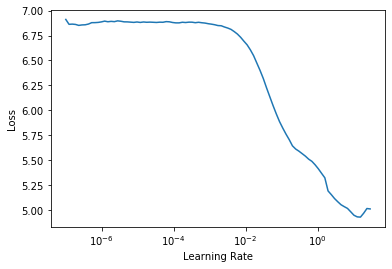

In [53]:
learn.lr_find(end_lr=100)

In [54]:
learn.fit_one_cycle(5, 4e-2)

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-15832., device='cuda:0', grad_fn=<MinBackward1>), tensor(-308.3465, device='cuda:0', grad_fn=<MeanBackward0>), tensor(13616., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.2416, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0047, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2078, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.2416, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0047, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2078, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-187.6250, device='cuda:0'), tensor(1.3880, device='cuda:0'), tensor(144.1250, device='cuda:0')) 

hvs min, mean max: (tensor(-187.6250, device='cuda:0'), tensor(1.3880, device='cuda:0'), tensor(144.1250, device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH m

hvs min, mean max: (tensor(-25.1406, device='cuda:0'), tensor(0.5871, device='cuda:0'), tensor(41.8438, device='cuda:0')) 

hvs min, mean max: (tensor(-25.1406, device='cuda:0'), tensor(0.5871, device='cuda:0'), tensor(41.8438, device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-14232., device='cuda:0', grad_fn=<MinBackward1>), tensor(-272.3751, device='cuda:0', grad_fn=<MeanBackward0>), tensor(13168., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.2172, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0042, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2009, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.2172, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0042, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2009, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-115.5625, device='cuda:0'), t

hvs min, mean max: (tensor(-166.8750, device='cuda:0'), tensor(-2.4738, device='cuda:0'), tensor(118.9375, device='cuda:0')) 

hvs min, mean max: (tensor(-166.8750, device='cuda:0'), tensor(-2.4738, device='cuda:0'), tensor(118.9375, device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-20816., device='cuda:0', grad_fn=<MinBackward1>), tensor(82.9721, device='cuda:0', grad_fn=<MeanBackward0>), tensor(10896., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3176, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.1663, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.3176, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.1663, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-218., device='cuda:0'), ten

hvs min, mean max: (tensor(-802., device='cuda:0'), tensor(5.1579, device='cuda:0'), tensor(411.5000, device='cuda:0')) 

hvs min, mean max: (tensor(-802., device='cuda:0'), tensor(5.1579, device='cuda:0'), tensor(411.5000, device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-15816., device='cuda:0', grad_fn=<MinBackward1>), tensor(-79.3072, device='cuda:0', grad_fn=<MeanBackward0>), tensor(13552., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.2413, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0012, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2068, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.2413, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0012, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2068, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-154., device='cuda:0'), tensor(10.

hvs min, mean max: (tensor(-223.6250, device='cuda:0'), tensor(3.4723, device='cuda:0'), tensor(321.2500, device='cuda:0')) 

hvs min, mean max: (tensor(-223.6250, device='cuda:0'), tensor(3.4723, device='cuda:0'), tensor(321.2500, device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-16400., device='cuda:0', grad_fn=<MinBackward1>), tensor(-311.2914, device='cuda:0', grad_fn=<MeanBackward0>), tensor(17552., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.2502, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0047, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2678, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.2502, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0047, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2678, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-1188., device='cuda:0'), 

hvs min, mean max: (tensor(-1924., device='cuda:0'), tensor(-77.3875, device='cuda:0'), tensor(396.2500, device='cuda:0')) 

hvs min, mean max: (tensor(-1924., device='cuda:0'), tensor(-77.3875, device='cuda:0'), tensor(396.2500, device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-17856., device='cuda:0', grad_fn=<MinBackward1>), tensor(297.7961, device='cuda:0', grad_fn=<MeanBackward0>), tensor(25440., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.2725, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0045, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3882, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.2725, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0045, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3882, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-389.7500, device='cuda:0'), te

hvs min, mean max: (tensor(-1681., device='cuda:0'), tensor(-5.3558, device='cuda:0'), tensor(987., device='cuda:0')) 

hvs min, mean max: (tensor(-1681., device='cuda:0'), tensor(-5.3558, device='cuda:0'), tensor(987., device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-17696., device='cuda:0', grad_fn=<MinBackward1>), tensor(195.2729, device='cuda:0', grad_fn=<MeanBackward0>), tensor(20816., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.2700, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0030, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3176, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.2700, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0030, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3176, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-2798., device='cuda:0'), tensor(-111.709

hvs min, mean max: (tensor(-567., device='cuda:0'), tensor(8.6071, device='cuda:0'), tensor(1432., device='cuda:0')) 

hvs min, mean max: (tensor(-567., device='cuda:0'), tensor(8.6071, device='cuda:0'), tensor(1432., device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-35904., device='cuda:0', grad_fn=<MinBackward1>), tensor(-643.1989, device='cuda:0', grad_fn=<MeanBackward0>), tensor(12944., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5479, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0098, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.1975, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.5479, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0098, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.1975, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-742.5000, device='cuda:0'), tensor(-8.0

hvs min, mean max: (tensor(-789., device='cuda:0'), tensor(-10.1741, device='cuda:0'), tensor(402.5000, device='cuda:0')) 

hvs min, mean max: (tensor(-789., device='cuda:0'), tensor(-10.1741, device='cuda:0'), tensor(402.5000, device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-27424., device='cuda:0', grad_fn=<MinBackward1>), tensor(-442.7576, device='cuda:0', grad_fn=<MeanBackward0>), tensor(17440., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4185, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0068, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2661, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.4185, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0068, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2661, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-860.5000, device='cuda:0'), t

hvs min, mean max: (tensor(-73.6875, device='cuda:0'), tensor(10.2645, device='cuda:0'), tensor(315., device='cuda:0')) 

hvs min, mean max: (tensor(-73.6875, device='cuda:0'), tensor(10.2645, device='cuda:0'), tensor(315., device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-17648., device='cuda:0', grad_fn=<MinBackward1>), tensor(220.6034, device='cuda:0', grad_fn=<MeanBackward0>), tensor(24496., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.2693, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0034, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3738, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.2693, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0034, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3738, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-156., device='cuda:0'), tensor(1.113

hvs min, mean max: (tensor(-99.2500, device='cuda:0'), tensor(-0.2524, device='cuda:0'), tensor(85.8125, device='cuda:0')) 

hvs min, mean max: (tensor(-99.2500, device='cuda:0'), tensor(-0.2524, device='cuda:0'), tensor(85.8125, device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-23248., device='cuda:0', grad_fn=<MinBackward1>), tensor(26.6869, device='cuda:0', grad_fn=<MeanBackward0>), tensor(23680., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3547, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3613, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.3547, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3613, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-99.6250, device='cuda:0'), tens

hvs min, mean max: (tensor(-278.7500, device='cuda:0'), tensor(-0.7629, device='cuda:0'), tensor(104.9375, device='cuda:0')) 

hvs min, mean max: (tensor(-278.7500, device='cuda:0'), tensor(-0.7629, device='cuda:0'), tensor(104.9375, device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-22576., device='cuda:0', grad_fn=<MinBackward1>), tensor(-1025.4426, device='cuda:0', grad_fn=<MeanBackward0>), tensor(12992., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3445, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0156, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.1982, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.3445, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0156, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.1982, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-167.5000, device='cuda

hvs min, mean max: (tensor(-119.1250, device='cuda:0'), tensor(2.4488, device='cuda:0'), tensor(158.2500, device='cuda:0')) 

hvs min, mean max: (tensor(-119.1250, device='cuda:0'), tensor(2.4488, device='cuda:0'), tensor(158.2500, device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-20640., device='cuda:0', grad_fn=<MinBackward1>), tensor(246.6815, device='cuda:0', grad_fn=<MeanBackward0>), tensor(17904., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3149, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0038, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2732, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.3149, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0038, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2732, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-129.8750, device='cuda:0'), 

hvs min, mean max: (tensor(-70.5000, device='cuda:0'), tensor(-0.3278, device='cuda:0'), tensor(78.1250, device='cuda:0')) 

hvs min, mean max: (tensor(-70.5000, device='cuda:0'), tensor(-0.3278, device='cuda:0'), tensor(78.1250, device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-15296., device='cuda:0', grad_fn=<MinBackward1>), tensor(-5.0683, device='cuda:0', grad_fn=<MeanBackward0>), tensor(21040., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.2334, device='cuda:0', grad_fn=<MinBackward1>), tensor(-7.7336e-05, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3210, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.2334, device='cuda:0', grad_fn=<MinBackward1>), tensor(-7.7336e-05, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3210, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-129.2500, device='cud

hvs min, mean max: (tensor(-189.1250, device='cuda:0'), tensor(-1.0304, device='cuda:0'), tensor(155.7500, device='cuda:0')) 

hvs min, mean max: (tensor(-189.1250, device='cuda:0'), tensor(-1.0304, device='cuda:0'), tensor(155.7500, device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-28768., device='cuda:0', grad_fn=<MinBackward1>), tensor(-742.2291, device='cuda:0', grad_fn=<MeanBackward0>), tensor(14208., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4390, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0113, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2168, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.4390, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0113, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2168, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-51.2500, device='cuda:0

hvs min, mean max: (tensor(-41.5000, device='cuda:0'), tensor(1.6080, device='cuda:0'), tensor(49.2188, device='cuda:0')) 

hvs min, mean max: (tensor(-41.5000, device='cuda:0'), tensor(1.6080, device='cuda:0'), tensor(49.2188, device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-19712., device='cuda:0', grad_fn=<MinBackward1>), tensor(255.0075, device='cuda:0', grad_fn=<MeanBackward0>), tensor(14680., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3008, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0039, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2240, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.3008, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0039, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2240, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-42.7500, device='cuda:0'), tenso

hvs min, mean max: (tensor(-63.5000, device='cuda:0'), tensor(-1.6121, device='cuda:0'), tensor(35.9688, device='cuda:0')) 

hvs min, mean max: (tensor(-63.5000, device='cuda:0'), tensor(-1.6121, device='cuda:0'), tensor(35.9688, device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-29392., device='cuda:0', grad_fn=<MinBackward1>), tensor(-392.0909, device='cuda:0', grad_fn=<MeanBackward0>), tensor(13920., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4485, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0060, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2124, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.4485, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0060, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2124, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-65.7500, device='cuda:0'), 

hvs min, mean max: (tensor(-65.3125, device='cuda:0'), tensor(2.9090, device='cuda:0'), tensor(164.2500, device='cuda:0')) 

hvs min, mean max: (tensor(-65.3125, device='cuda:0'), tensor(2.9090, device='cuda:0'), tensor(164.2500, device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-27360., device='cuda:0', grad_fn=<MinBackward1>), tensor(183.6978, device='cuda:0', grad_fn=<MeanBackward0>), tensor(25184., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4175, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0028, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3843, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.4175, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0028, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3843, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-57.7188, device='cuda:0'), ten

hvs min, mean max: (tensor(-151.1250, device='cuda:0'), tensor(0.5749, device='cuda:0'), tensor(131.5000, device='cuda:0')) 

hvs min, mean max: (tensor(-151.1250, device='cuda:0'), tensor(0.5749, device='cuda:0'), tensor(131.5000, device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-27888., device='cuda:0', grad_fn=<MinBackward1>), tensor(-718.8715, device='cuda:0', grad_fn=<MeanBackward0>), tensor(30832., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4255, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0110, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4705, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.4255, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0110, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4705, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-73.3125, device='cuda:0')

hvs min, mean max: (tensor(-124.8125, device='cuda:0'), tensor(-0.8369, device='cuda:0'), tensor(58.3750, device='cuda:0')) 

hvs min, mean max: (tensor(-124.8125, device='cuda:0'), tensor(-0.8369, device='cuda:0'), tensor(58.3750, device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-16528., device='cuda:0', grad_fn=<MinBackward1>), tensor(592.0889, device='cuda:0', grad_fn=<MeanBackward0>), tensor(22432., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.2522, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0090, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3423, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.2522, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0090, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3423, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-120.8750, device='cuda:0'), 

hvs min, mean max: (tensor(-49.3125, device='cuda:0'), tensor(2.6287, device='cuda:0'), tensor(113.3750, device='cuda:0')) 

hvs min, mean max: (tensor(-49.3125, device='cuda:0'), tensor(2.6287, device='cuda:0'), tensor(113.3750, device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-23472., device='cuda:0', grad_fn=<MinBackward1>), tensor(275.1374, device='cuda:0', grad_fn=<MeanBackward0>), tensor(29344., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3582, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0042, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4478, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.3582, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0042, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4478, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-70.1875, device='cuda:0'), ten

hvs min, mean max: (tensor(-43., device='cuda:0'), tensor(-0.5644, device='cuda:0'), tensor(60.8438, device='cuda:0')) 

hvs min, mean max: (tensor(-43., device='cuda:0'), tensor(-0.5644, device='cuda:0'), tensor(60.8438, device='cuda:0')) 

scale in step is: 65536.0 

scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-16544., device='cuda:0', grad_fn=<MinBackward1>), tensor(600.4084, device='cuda:0', grad_fn=<MeanBackward0>), tensor(25968., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.2524, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0092, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3962, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.2524, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0092, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3962, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-48.2812, device='cuda:0'), tensor(0.37

hvs min, mean max: (tensor(-57.5625, device='cuda:0'), tensor(-2.9079, device='cuda:0'), tensor(28.9375, device='cuda:0')) 

hvs min, mean max: (tensor(-57.5625, device='cuda:0'), tensor(-2.9079, device='cuda:0'), tensor(28.9375, device='cuda:0')) 

scale in step is: 32768.0 

scale in _backward is: 32768.0 

PRE UNSCALE gradsH min, mean max: (tensor(-16624., device='cuda:0', grad_fn=<MinBackward1>), tensor(246.2337, device='cuda:0', grad_fn=<MeanBackward0>), tensor(25392., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5073, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0075, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7749, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.5073, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0075, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7749, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-190.5000, device='cuda:0'), te

hvs min, mean max: (tensor(-113., device='cuda:0'), tensor(1.5154, device='cuda:0'), tensor(164.7500, device='cuda:0')) 

hvs min, mean max: (tensor(-113., device='cuda:0'), tensor(1.5154, device='cuda:0'), tensor(164.7500, device='cuda:0')) 

scale in step is: 32768.0 

scale in _backward is: 32768.0 

PRE UNSCALE gradsH min, mean max: (tensor(-19408., device='cuda:0', grad_fn=<MinBackward1>), tensor(-326.4626, device='cuda:0', grad_fn=<MeanBackward0>), tensor(8248., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5923, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0100, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2517, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.5923, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0100, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2517, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-66.3125, device='cuda:0'), tensor(

hvs min, mean max: (tensor(-48.2188, device='cuda:0'), tensor(-0.7371, device='cuda:0'), tensor(78.3125, device='cuda:0')) 

hvs min, mean max: (tensor(-48.2188, device='cuda:0'), tensor(-0.7371, device='cuda:0'), tensor(78.3125, device='cuda:0')) 

scale in step is: 32768.0 

scale in _backward is: 32768.0 

PRE UNSCALE gradsH min, mean max: (tensor(-7496., device='cuda:0', grad_fn=<MinBackward1>), tensor(785.9968, device='cuda:0', grad_fn=<MeanBackward0>), tensor(14552., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.2288, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4441, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.2288, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4441, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-87.1250, device='cuda:0'), tens

hvs min, mean max: (tensor(-100.4375, device='cuda:0'), tensor(-5.2824, device='cuda:0'), tensor(58.0938, device='cuda:0')) 

hvs min, mean max: (tensor(-100.4375, device='cuda:0'), tensor(-5.2824, device='cuda:0'), tensor(58.0938, device='cuda:0')) 

scale in step is: 32768.0 

scale in _backward is: 32768.0 

PRE UNSCALE gradsH min, mean max: (tensor(-6780., device='cuda:0', grad_fn=<MinBackward1>), tensor(220.5222, device='cuda:0', grad_fn=<MeanBackward0>), tensor(11448., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.2069, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0067, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3494, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.2069, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0067, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3494, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-38.2188, device='cuda:0'), te

hvs min, mean max: (tensor(-58.2500, device='cuda:0'), tensor(0.0350, device='cuda:0'), tensor(61.8438, device='cuda:0')) 

hvs min, mean max: (tensor(-58.2500, device='cuda:0'), tensor(0.0350, device='cuda:0'), tensor(61.8438, device='cuda:0')) 

scale in step is: 32768.0 

scale in _backward is: 32768.0 

PRE UNSCALE gradsH min, mean max: (tensor(-11000., device='cuda:0', grad_fn=<MinBackward1>), tensor(-275.7165, device='cuda:0', grad_fn=<MeanBackward0>), tensor(12840., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3357, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0084, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3918, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.3357, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0084, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3918, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-55.4688, device='cuda:0'), te

hvs min, mean max: (tensor(-45.0938, device='cuda:0'), tensor(0.8933, device='cuda:0'), tensor(48.5625, device='cuda:0')) 

hvs min, mean max: (tensor(-45.0938, device='cuda:0'), tensor(0.8933, device='cuda:0'), tensor(48.5625, device='cuda:0')) 

scale in step is: 32768.0 

scale in _backward is: 32768.0 

PRE UNSCALE gradsH min, mean max: (tensor(-10912., device='cuda:0', grad_fn=<MinBackward1>), tensor(243.0988, device='cuda:0', grad_fn=<MeanBackward0>), tensor(12376., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3330, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0074, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3777, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.3330, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0074, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3777, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-46.2500, device='cuda:0'), tenso

hvs min, mean max: (tensor(-65.8125, device='cuda:0'), tensor(-1.4815, device='cuda:0'), tensor(89.5625, device='cuda:0')) 

hvs min, mean max: (tensor(-65.8125, device='cuda:0'), tensor(-1.4815, device='cuda:0'), tensor(89.5625, device='cuda:0')) 

scale in step is: 32768.0 

scale in _backward is: 32768.0 

PRE UNSCALE gradsH min, mean max: (tensor(-11992., device='cuda:0', grad_fn=<MinBackward1>), tensor(329.7044, device='cuda:0', grad_fn=<MeanBackward0>), tensor(14800., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3660, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0101, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4517, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.3660, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0101, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4517, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-88.7500, device='cuda:0'), ten

hvs min, mean max: (tensor(-124.1875, device='cuda:0'), tensor(3.6758, device='cuda:0'), tensor(137.2500, device='cuda:0')) 

hvs min, mean max: (tensor(-124.1875, device='cuda:0'), tensor(3.6758, device='cuda:0'), tensor(137.2500, device='cuda:0')) 

scale in step is: 32768.0 

scale in _backward is: 32768.0 

PRE UNSCALE gradsH min, mean max: (tensor(-15048., device='cuda:0', grad_fn=<MinBackward1>), tensor(221.0419, device='cuda:0', grad_fn=<MeanBackward0>), tensor(18672., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4592, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0067, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5698, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.4592, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0067, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5698, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-43.0625, device='cuda:0'), t

hvs min, mean max: (tensor(-34.1562, device='cuda:0'), tensor(0.7228, device='cuda:0'), tensor(67.0625, device='cuda:0')) 

hvs min, mean max: (tensor(-34.1562, device='cuda:0'), tensor(0.7228, device='cuda:0'), tensor(67.0625, device='cuda:0')) 

scale in step is: 32768.0 

scale in _backward is: 32768.0 

PRE UNSCALE gradsH min, mean max: (tensor(-19616., device='cuda:0', grad_fn=<MinBackward1>), tensor(-802.1375, device='cuda:0', grad_fn=<MeanBackward0>), tensor(14848., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5986, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0245, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4531, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.5986, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0245, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4531, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-77.4375, device='cuda:0'), te

hvs min, mean max: (tensor(-36.3750, device='cuda:0'), tensor(1.3388, device='cuda:0'), tensor(51.2500, device='cuda:0')) 

hvs min, mean max: (tensor(-36.3750, device='cuda:0'), tensor(1.3388, device='cuda:0'), tensor(51.2500, device='cuda:0')) 

scale in step is: 32768.0 

scale in _backward is: 32768.0 

PRE UNSCALE gradsH min, mean max: (tensor(-11128., device='cuda:0', grad_fn=<MinBackward1>), tensor(1231.9315, device='cuda:0', grad_fn=<MeanBackward0>), tensor(26240., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3396, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0376, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8008, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.3396, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0376, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8008, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-48.1875, device='cuda:0'), tens

hvs min, mean max: (tensor(-58.0938, device='cuda:0'), tensor(-2.1544, device='cuda:0'), tensor(36.1562, device='cuda:0')) 

hvs min, mean max: (tensor(-58.0938, device='cuda:0'), tensor(-2.1544, device='cuda:0'), tensor(36.1562, device='cuda:0')) 

scale in step is: 32768.0 

scale in _backward is: 32768.0 

PRE UNSCALE gradsH min, mean max: (tensor(-18384., device='cuda:0', grad_fn=<MinBackward1>), tensor(-84.8898, device='cuda:0', grad_fn=<MeanBackward0>), tensor(11808., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5610, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0026, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3604, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.5610, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0026, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3604, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-47.9688, device='cuda:0'), t

hvs min, mean max: (tensor(-56.4062, device='cuda:0'), tensor(0.2109, device='cuda:0'), tensor(76.8750, device='cuda:0')) 

hvs min, mean max: (tensor(-56.4062, device='cuda:0'), tensor(0.2109, device='cuda:0'), tensor(76.8750, device='cuda:0')) 

scale in step is: 32768.0 

scale in _backward is: 32768.0 

PRE UNSCALE gradsH min, mean max: (tensor(-18720., device='cuda:0', grad_fn=<MinBackward1>), tensor(300.1920, device='cuda:0', grad_fn=<MeanBackward0>), tensor(14816., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5713, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0092, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4521, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.5713, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0092, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4521, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-114.4375, device='cuda:0'), tens

hvs min, mean max: (tensor(-44.2188, device='cuda:0'), tensor(-0.1961, device='cuda:0'), tensor(60.5312, device='cuda:0')) 

hvs min, mean max: (tensor(-44.2188, device='cuda:0'), tensor(-0.1961, device='cuda:0'), tensor(60.5312, device='cuda:0')) 

scale in step is: 32768.0 

scale in _backward is: 32768.0 

PRE UNSCALE gradsH min, mean max: (tensor(-12320., device='cuda:0', grad_fn=<MinBackward1>), tensor(-134.0668, device='cuda:0', grad_fn=<MeanBackward0>), tensor(10224., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3760, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0041, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3120, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.3760, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0041, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3120, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-65.8125, device='cuda:0'), 

hvs min, mean max: (tensor(-81.7500, device='cuda:0'), tensor(0.2239, device='cuda:0'), tensor(53.6562, device='cuda:0')) 

hvs min, mean max: (tensor(-81.7500, device='cuda:0'), tensor(0.2239, device='cuda:0'), tensor(53.6562, device='cuda:0')) 

scale in step is: 32768.0 

scale in _backward is: 32768.0 

PRE UNSCALE gradsH min, mean max: (tensor(-19072., device='cuda:0', grad_fn=<MinBackward1>), tensor(-369.4028, device='cuda:0', grad_fn=<MeanBackward0>), tensor(20752., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5820, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0113, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6333, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.5820, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0113, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6333, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-87., device='cuda:0'), tensor

hvs min, mean max: (tensor(-125.6250, device='cuda:0'), tensor(-2.4992, device='cuda:0'), tensor(50.1562, device='cuda:0')) 

hvs min, mean max: (tensor(-125.6250, device='cuda:0'), tensor(-2.4992, device='cuda:0'), tensor(50.1562, device='cuda:0')) 

scale in step is: 32768.0 

scale in _backward is: 32768.0 

PRE UNSCALE gradsH min, mean max: (tensor(-14056., device='cuda:0', grad_fn=<MinBackward1>), tensor(-131.5508, device='cuda:0', grad_fn=<MeanBackward0>), tensor(7272., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4290, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0040, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2219, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.4290, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0040, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2219, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-26.7031, device='cuda:0'),

hvs min, mean max: (tensor(-40.0312, device='cuda:0'), tensor(0.1166, device='cuda:0'), tensor(50.0312, device='cuda:0')) 

hvs min, mean max: (tensor(-40.0312, device='cuda:0'), tensor(0.1166, device='cuda:0'), tensor(50.0312, device='cuda:0')) 

scale in step is: 32768.0 

scale in _backward is: 32768.0 

PRE UNSCALE gradsH min, mean max: (tensor(-15632., device='cuda:0', grad_fn=<MinBackward1>), tensor(-61.1321, device='cuda:0', grad_fn=<MeanBackward0>), tensor(19488., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4771, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0019, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5947, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.4771, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0019, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5947, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-85.5625, device='cuda:0'), ten

hvs min, mean max: (tensor(-35.2188, device='cuda:0'), tensor(0.2462, device='cuda:0'), tensor(57.7812, device='cuda:0')) 

hvs min, mean max: (tensor(-35.2188, device='cuda:0'), tensor(0.2462, device='cuda:0'), tensor(57.7812, device='cuda:0')) 

scale in step is: 32768.0 

scale in _backward is: 32768.0 

PRE UNSCALE gradsH min, mean max: (tensor(-9712., device='cuda:0', grad_fn=<MinBackward1>), tensor(974.5004, device='cuda:0', grad_fn=<MeanBackward0>), tensor(19696., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.2964, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0297, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6011, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.2964, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0297, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6011, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-103.3125, device='cuda:0'), tenso

hvs min, mean max: (tensor(-39.5312, device='cuda:0'), tensor(2.1706, device='cuda:0'), tensor(87.3125, device='cuda:0')) 

hvs min, mean max: (tensor(-39.5312, device='cuda:0'), tensor(2.1706, device='cuda:0'), tensor(87.3125, device='cuda:0')) 

scale in step is: 32768.0 

scale in _backward is: 32768.0 

PRE UNSCALE gradsH min, mean max: (tensor(-16928., device='cuda:0', grad_fn=<MinBackward1>), tensor(126.4232, device='cuda:0', grad_fn=<MeanBackward0>), tensor(16896., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5166, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0039, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5156, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.5166, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0039, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5156, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-52.0312, device='cuda:0'), tenso

hvs min, mean max: (tensor(-43.8125, device='cuda:0'), tensor(1.8204, device='cuda:0'), tensor(79.4375, device='cuda:0')) 

hvs min, mean max: (tensor(-43.8125, device='cuda:0'), tensor(1.8204, device='cuda:0'), tensor(79.4375, device='cuda:0')) 

scale in step is: 32768.0 

scale in _backward is: 32768.0 

PRE UNSCALE gradsH min, mean max: (tensor(-15232., device='cuda:0', grad_fn=<MinBackward1>), tensor(200.5488, device='cuda:0', grad_fn=<MeanBackward0>), tensor(16272., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4648, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0061, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4966, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.4648, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0061, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4966, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-43.8750, device='cuda:0'), tenso

hvs min, mean max: (tensor(-39.0625, device='cuda:0'), tensor(-0.8624, device='cuda:0'), tensor(38.7188, device='cuda:0')) 

hvs min, mean max: (tensor(-39.0625, device='cuda:0'), tensor(-0.8624, device='cuda:0'), tensor(38.7188, device='cuda:0')) 

scale in step is: 32768.0 

scale in _backward is: 32768.0 

PRE UNSCALE gradsH min, mean max: (tensor(-10952., device='cuda:0', grad_fn=<MinBackward1>), tensor(1517.6841, device='cuda:0', grad_fn=<MeanBackward0>), tensor(17632., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3342, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0463, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5381, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.3342, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0463, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5381, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-54., device='cuda:0'), tensor

hvs min, mean max: (tensor(-64.6875, device='cuda:0'), tensor(2.0582, device='cuda:0'), tensor(129.3750, device='cuda:0')) 

hvs min, mean max: (tensor(-64.6875, device='cuda:0'), tensor(2.0582, device='cuda:0'), tensor(129.3750, device='cuda:0')) 

scale in step is: 32768.0 

scale in _backward is: 32768.0 

PRE UNSCALE gradsH min, mean max: (tensor(-13344., device='cuda:0', grad_fn=<MinBackward1>), tensor(-769.6960, device='cuda:0', grad_fn=<MeanBackward0>), tensor(7368., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4072, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0235, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2249, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.4072, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0235, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2249, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-54.7188, device='cuda:0'), t

hvs min, mean max: (tensor(-114.6875, device='cuda:0'), tensor(0.4048, device='cuda:0'), tensor(84.6250, device='cuda:0')) 

hvs min, mean max: (tensor(-114.6875, device='cuda:0'), tensor(0.4048, device='cuda:0'), tensor(84.6250, device='cuda:0')) 

scale in step is: 32768.0 

scale in _backward is: 32768.0 

PRE UNSCALE gradsH min, mean max: (tensor(-23248., device='cuda:0', grad_fn=<MinBackward1>), tensor(1336.2477, device='cuda:0', grad_fn=<MeanBackward0>), tensor(26688., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.7095, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0408, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8145, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.7095, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0408, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8145, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-81.6250, device='cuda:0'), te

hvs min, mean max: (tensor(-72.3750, device='cuda:0'), tensor(-0.5470, device='cuda:0'), tensor(60.8750, device='cuda:0')) 

hvs min, mean max: (tensor(-72.3750, device='cuda:0'), tensor(-0.5470, device='cuda:0'), tensor(60.8750, device='cuda:0')) 

scale in step is: 32768.0 

scale in _backward is: 32768.0 

PRE UNSCALE gradsH min, mean max: (tensor(-27280., device='cuda:0', grad_fn=<MinBackward1>), tensor(545.9872, device='cuda:0', grad_fn=<MeanBackward0>), tensor(34240., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.8325, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0167, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.0449, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.8325, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0167, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.0449, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-111.5625, device='cuda:0'), te

hvs min, mean max: (tensor(-100.5000, device='cuda:0'), tensor(0.5692, device='cuda:0'), tensor(63.5000, device='cuda:0')) 

hvs min, mean max: (tensor(-100.5000, device='cuda:0'), tensor(0.5692, device='cuda:0'), tensor(63.5000, device='cuda:0')) 

scale in step is: 32768.0 

scale in _backward is: 32768.0 

PRE UNSCALE gradsH min, mean max: (tensor(-21872., device='cuda:0', grad_fn=<MinBackward1>), tensor(-876.6757, device='cuda:0', grad_fn=<MeanBackward0>), tensor(19984., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.6675, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0268, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6099, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.6675, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0268, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6099, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-69.8125, device='cuda:0'), 

hvs min, mean max: (tensor(-33.6562, device='cuda:0'), tensor(0.7331, device='cuda:0'), tensor(89.9375, device='cuda:0')) 

hvs min, mean max: (tensor(-33.6562, device='cuda:0'), tensor(0.7331, device='cuda:0'), tensor(89.9375, device='cuda:0')) 

scale in step is: 32768.0 

scale in _backward is: 32768.0 

PRE UNSCALE gradsH min, mean max: (tensor(-27872., device='cuda:0', grad_fn=<MinBackward1>), tensor(-408.0014, device='cuda:0', grad_fn=<MeanBackward0>), tensor(15184., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.8506, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0125, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4634, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.8506, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0125, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4634, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-50.2500, device='cuda:0'), te

hvs min, mean max: (tensor(-21., device='cuda:0'), tensor(6.8526, device='cuda:0'), tensor(72.9375, device='cuda:0')) 

hvs min, mean max: (tensor(-21., device='cuda:0'), tensor(6.8526, device='cuda:0'), tensor(72.9375, device='cuda:0')) 

scale in step is: 32768.0 

scale in _backward is: 32768.0 

PRE UNSCALE gradsH min, mean max: (tensor(-12768., device='cuda:0', grad_fn=<MinBackward1>), tensor(265.9575, device='cuda:0', grad_fn=<MeanBackward0>), tensor(17568., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3896, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0081, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5361, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.3896, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0081, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5361, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-71.4375, device='cuda:0'), tensor(-0.288

hvs min, mean max: (tensor(-107.7500, device='cuda:0'), tensor(1.0398, device='cuda:0'), tensor(176.6250, device='cuda:0')) 

hvs min, mean max: (tensor(-107.7500, device='cuda:0'), tensor(1.0398, device='cuda:0'), tensor(176.6250, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4220., device='cuda:0', grad_fn=<MinBackward1>), tensor(295.7172, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5732., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.2576, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0180, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3499, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.2576, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0180, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3499, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-54.5625, device='cuda:0'), ten

hvs min, mean max: (tensor(-53.0938, device='cuda:0'), tensor(2.3326, device='cuda:0'), tensor(102.1875, device='cuda:0')) 

hvs min, mean max: (tensor(-53.0938, device='cuda:0'), tensor(2.3326, device='cuda:0'), tensor(102.1875, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-9136., device='cuda:0', grad_fn=<MinBackward1>), tensor(216.9346, device='cuda:0', grad_fn=<MeanBackward0>), tensor(11560., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5576, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0132, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7056, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.5576, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0132, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7056, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-69.3125, device='cuda:0'), tens

hvs min, mean max: (tensor(-59., device='cuda:0'), tensor(-0.1746, device='cuda:0'), tensor(46.8750, device='cuda:0')) 

hvs min, mean max: (tensor(-59., device='cuda:0'), tensor(-0.1746, device='cuda:0'), tensor(46.8750, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-7084., device='cuda:0', grad_fn=<MinBackward1>), tensor(175.1054, device='cuda:0', grad_fn=<MeanBackward0>), tensor(7220., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4324, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0107, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4407, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.4324, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0107, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4407, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-75.6250, device='cuda:0'), tensor(0.4588

hvs min, mean max: (tensor(-139.5000, device='cuda:0'), tensor(3.3276, device='cuda:0'), tensor(74.3125, device='cuda:0')) 

hvs min, mean max: (tensor(-139.5000, device='cuda:0'), tensor(3.3276, device='cuda:0'), tensor(74.3125, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-16992., device='cuda:0', grad_fn=<MinBackward1>), tensor(-382.6164, device='cuda:0', grad_fn=<MeanBackward0>), tensor(9024., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-1.0371, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0234, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5508, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-1.0371, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0234, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5508, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-71.7500, device='cuda:0'), t

hvs min, mean max: (tensor(-121., device='cuda:0'), tensor(-1.7573, device='cuda:0'), tensor(75.5625, device='cuda:0')) 

hvs min, mean max: (tensor(-121., device='cuda:0'), tensor(-1.7573, device='cuda:0'), tensor(75.5625, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-6632., device='cuda:0', grad_fn=<MinBackward1>), tensor(-260.3075, device='cuda:0', grad_fn=<MeanBackward0>), tensor(6836., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4048, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0159, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4172, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.4048, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0159, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4172, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-83.8125, device='cuda:0'), tensor(2

hvs min, mean max: (tensor(-48.4062, device='cuda:0'), tensor(-1.0658, device='cuda:0'), tensor(48.4062, device='cuda:0')) 

hvs min, mean max: (tensor(-48.4062, device='cuda:0'), tensor(-1.0658, device='cuda:0'), tensor(48.4062, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-7200., device='cuda:0', grad_fn=<MinBackward1>), tensor(-117.6978, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4988., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4395, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0072, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3044, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.4395, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0072, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3044, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-40.8750, device='cuda:0'), te

hvs min, mean max: (tensor(-37.9375, device='cuda:0'), tensor(5.6227, device='cuda:0'), tensor(153., device='cuda:0')) 

hvs min, mean max: (tensor(-37.9375, device='cuda:0'), tensor(5.6227, device='cuda:0'), tensor(153., device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-10736., device='cuda:0', grad_fn=<MinBackward1>), tensor(-425.6878, device='cuda:0', grad_fn=<MeanBackward0>), tensor(13096., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.6553, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0260, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7993, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.6553, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0260, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7993, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-47.5938, device='cuda:0'), tensor(-

hvs min, mean max: (tensor(-98.2500, device='cuda:0'), tensor(-5.6774, device='cuda:0'), tensor(47.9062, device='cuda:0')) 

hvs min, mean max: (tensor(-98.2500, device='cuda:0'), tensor(-5.6774, device='cuda:0'), tensor(47.9062, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-6732., device='cuda:0', grad_fn=<MinBackward1>), tensor(-571.9420, device='cuda:0', grad_fn=<MeanBackward0>), tensor(3700., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4109, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0349, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2258, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.4109, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0349, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2258, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-163.1250, device='cuda:0'), t

hvs min, mean max: (tensor(-69.3125, device='cuda:0'), tensor(-1.4871, device='cuda:0'), tensor(69.7500, device='cuda:0')) 

hvs min, mean max: (tensor(-69.3125, device='cuda:0'), tensor(-1.4871, device='cuda:0'), tensor(69.7500, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4748., device='cuda:0', grad_fn=<MinBackward1>), tensor(60.0535, device='cuda:0', grad_fn=<MeanBackward0>), tensor(10944., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.2898, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0037, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6680, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.2898, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0037, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6680, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-102.3125, device='cuda:0'), tens

hvs min, mean max: (tensor(-348.7500, device='cuda:0'), tensor(4.3794, device='cuda:0'), tensor(345.2500, device='cuda:0')) 

hvs min, mean max: (tensor(-348.7500, device='cuda:0'), tensor(4.3794, device='cuda:0'), tensor(345.2500, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-10920., device='cuda:0', grad_fn=<MinBackward1>), tensor(338.5840, device='cuda:0', grad_fn=<MeanBackward0>), tensor(16784., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.6665, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0207, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.0244, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.6665, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0207, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.0244, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-319., device='cuda:0'), tens

hvs min, mean max: (tensor(-246.2500, device='cuda:0'), tensor(2.6454, device='cuda:0'), tensor(119.5000, device='cuda:0')) 

hvs min, mean max: (tensor(-246.2500, device='cuda:0'), tensor(2.6454, device='cuda:0'), tensor(119.5000, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-7760., device='cuda:0', grad_fn=<MinBackward1>), tensor(-56.6889, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5864., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4736, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0035, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3579, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.4736, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0035, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3579, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-538.5000, device='cuda:0'), 

hvs min, mean max: (tensor(-94.3750, device='cuda:0'), tensor(5.0687, device='cuda:0'), tensor(110.0625, device='cuda:0')) 

hvs min, mean max: (tensor(-94.3750, device='cuda:0'), tensor(5.0687, device='cuda:0'), tensor(110.0625, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-5868., device='cuda:0', grad_fn=<MinBackward1>), tensor(173.0474, device='cuda:0', grad_fn=<MeanBackward0>), tensor(8288., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3582, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0106, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5059, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.3582, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0106, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5059, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-130.3750, device='cuda:0'), tens

hvs min, mean max: (tensor(-122.7500, device='cuda:0'), tensor(2.8835, device='cuda:0'), tensor(125., device='cuda:0')) 

hvs min, mean max: (tensor(-122.7500, device='cuda:0'), tensor(2.8835, device='cuda:0'), tensor(125., device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-11312., device='cuda:0', grad_fn=<MinBackward1>), tensor(-190.4587, device='cuda:0', grad_fn=<MeanBackward0>), tensor(9672., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.6904, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0116, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5903, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.6904, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0116, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5903, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-124.1250, device='cuda:0'), tensor

hvs min, mean max: (tensor(-163.3750, device='cuda:0'), tensor(0.9507, device='cuda:0'), tensor(151.7500, device='cuda:0')) 

hvs min, mean max: (tensor(-163.3750, device='cuda:0'), tensor(0.9507, device='cuda:0'), tensor(151.7500, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-6552., device='cuda:0', grad_fn=<MinBackward1>), tensor(-259.7079, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4476., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3999, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0159, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2732, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.3999, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0159, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2732, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-34.0312, device='cuda:0'), 

hvs min, mean max: (tensor(-146.2500, device='cuda:0'), tensor(-2.1730, device='cuda:0'), tensor(115.1250, device='cuda:0')) 

hvs min, mean max: (tensor(-146.2500, device='cuda:0'), tensor(-2.1730, device='cuda:0'), tensor(115.1250, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-14520., device='cuda:0', grad_fn=<MinBackward1>), tensor(184.6093, device='cuda:0', grad_fn=<MeanBackward0>), tensor(12912., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.8862, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0113, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7881, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.8862, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0113, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7881, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-91.2500, device='cuda:0'),

hvs min, mean max: (tensor(-175.1250, device='cuda:0'), tensor(-3.4228, device='cuda:0'), tensor(45.5000, device='cuda:0')) 

hvs min, mean max: (tensor(-175.1250, device='cuda:0'), tensor(-3.4228, device='cuda:0'), tensor(45.5000, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-6040., device='cuda:0', grad_fn=<MinBackward1>), tensor(369.2845, device='cuda:0', grad_fn=<MeanBackward0>), tensor(16104., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3687, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0225, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9829, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.3687, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0225, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9829, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-53.6250, device='cuda:0'), te

hvs min, mean max: (tensor(-82.8125, device='cuda:0'), tensor(-2.5625, device='cuda:0'), tensor(53.9688, device='cuda:0')) 

hvs min, mean max: (tensor(-82.8125, device='cuda:0'), tensor(-2.5625, device='cuda:0'), tensor(53.9688, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-8520., device='cuda:0', grad_fn=<MinBackward1>), tensor(-85.0754, device='cuda:0', grad_fn=<MeanBackward0>), tensor(9520., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5200, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0052, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5811, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.5200, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0052, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5811, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-42.6562, device='cuda:0'), ten

hvs min, mean max: (tensor(-61.0625, device='cuda:0'), tensor(0.8438, device='cuda:0'), tensor(73.7500, device='cuda:0')) 

hvs min, mean max: (tensor(-61.0625, device='cuda:0'), tensor(0.8438, device='cuda:0'), tensor(73.7500, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-7604., device='cuda:0', grad_fn=<MinBackward1>), tensor(153.3679, device='cuda:0', grad_fn=<MeanBackward0>), tensor(10112., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4641, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0094, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6172, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.4641, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0094, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6172, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-84.1875, device='cuda:0'), tensor

hvs min, mean max: (tensor(-123.2500, device='cuda:0'), tensor(-1.4714, device='cuda:0'), tensor(67.3750, device='cuda:0')) 

hvs min, mean max: (tensor(-123.2500, device='cuda:0'), tensor(-1.4714, device='cuda:0'), tensor(67.3750, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-11512., device='cuda:0', grad_fn=<MinBackward1>), tensor(78.0128, device='cuda:0', grad_fn=<MeanBackward0>), tensor(10504., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.7026, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0048, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6411, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.7026, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0048, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6411, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-62.2812, device='cuda:0'), te

hvs min, mean max: (tensor(-31.0781, device='cuda:0'), tensor(4.4201, device='cuda:0'), tensor(190.2500, device='cuda:0')) 

hvs min, mean max: (tensor(-31.0781, device='cuda:0'), tensor(4.4201, device='cuda:0'), tensor(190.2500, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-11704., device='cuda:0', grad_fn=<MinBackward1>), tensor(85.5370, device='cuda:0', grad_fn=<MeanBackward0>), tensor(15024., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.7144, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9170, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.7144, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9170, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-41.3125, device='cuda:0'), tens

hvs min, mean max: (tensor(-81.2500, device='cuda:0'), tensor(-1.2510, device='cuda:0'), tensor(169.2500, device='cuda:0')) 

hvs min, mean max: (tensor(-81.2500, device='cuda:0'), tensor(-1.2510, device='cuda:0'), tensor(169.2500, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-14256., device='cuda:0', grad_fn=<MinBackward1>), tensor(98.2397, device='cuda:0', grad_fn=<MeanBackward0>), tensor(7224., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.8701, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0060, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4409, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.8701, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0060, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4409, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-36.0312, device='cuda:0'), ten

hvs min, mean max: (tensor(-64.3750, device='cuda:0'), tensor(-1.1972, device='cuda:0'), tensor(40.7500, device='cuda:0')) 

hvs min, mean max: (tensor(-64.3750, device='cuda:0'), tensor(-1.1972, device='cuda:0'), tensor(40.7500, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-7992., device='cuda:0', grad_fn=<MinBackward1>), tensor(243.5609, device='cuda:0', grad_fn=<MeanBackward0>), tensor(9880., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4878, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0149, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6030, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.4878, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0149, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6030, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-167.5000, device='cuda:0'), tens

hvs min, mean max: (tensor(-116.6250, device='cuda:0'), tensor(0.0923, device='cuda:0'), tensor(109.5625, device='cuda:0')) 

hvs min, mean max: (tensor(-116.6250, device='cuda:0'), tensor(0.0923, device='cuda:0'), tensor(109.5625, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-10824., device='cuda:0', grad_fn=<MinBackward1>), tensor(74.2209, device='cuda:0', grad_fn=<MeanBackward0>), tensor(8180., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.6606, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0045, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4993, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.6606, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0045, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4993, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-90., device='cuda:0'), tensor(

hvs min, mean max: (tensor(-152.6250, device='cuda:0'), tensor(-0.0254, device='cuda:0'), tensor(163.1250, device='cuda:0')) 

hvs min, mean max: (tensor(-152.6250, device='cuda:0'), tensor(-0.0254, device='cuda:0'), tensor(163.1250, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-7164., device='cuda:0', grad_fn=<MinBackward1>), tensor(-90.4929, device='cuda:0', grad_fn=<MeanBackward0>), tensor(9728., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4373, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0055, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5938, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.4373, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0055, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5938, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-50.5312, device='cuda:0'),

hvs min, mean max: (tensor(-60.8438, device='cuda:0'), tensor(-1.8732, device='cuda:0'), tensor(25.7812, device='cuda:0')) 

hvs min, mean max: (tensor(-60.8438, device='cuda:0'), tensor(-1.8732, device='cuda:0'), tensor(25.7812, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-10608., device='cuda:0', grad_fn=<MinBackward1>), tensor(-224.2468, device='cuda:0', grad_fn=<MeanBackward0>), tensor(6884., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.6475, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0137, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4202, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.6475, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0137, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4202, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-75., device='cuda:0'), tenso

hvs min, mean max: (tensor(-66.5625, device='cuda:0'), tensor(1.6382, device='cuda:0'), tensor(107.5625, device='cuda:0')) 

hvs min, mean max: (tensor(-66.5625, device='cuda:0'), tensor(1.6382, device='cuda:0'), tensor(107.5625, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-14016., device='cuda:0', grad_fn=<MinBackward1>), tensor(-118.3501, device='cuda:0', grad_fn=<MeanBackward0>), tensor(21136., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.8555, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0072, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.2900, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.8555, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0072, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.2900, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-132.2500, device='cuda:0'),

hvs min, mean max: (tensor(-283.7500, device='cuda:0'), tensor(-1.6739, device='cuda:0'), tensor(63.4688, device='cuda:0')) 

hvs min, mean max: (tensor(-283.7500, device='cuda:0'), tensor(-1.6739, device='cuda:0'), tensor(63.4688, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-10136., device='cuda:0', grad_fn=<MinBackward1>), tensor(-112.5070, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4360., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.6187, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0069, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2661, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.6187, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0069, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2661, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-85.5625, device='cuda:0'),

hvs min, mean max: (tensor(-123., device='cuda:0'), tensor(1.2116, device='cuda:0'), tensor(160.1250, device='cuda:0')) 

hvs min, mean max: (tensor(-123., device='cuda:0'), tensor(1.2116, device='cuda:0'), tensor(160.1250, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-14464., device='cuda:0', grad_fn=<MinBackward1>), tensor(-235.0886, device='cuda:0', grad_fn=<MeanBackward0>), tensor(8464., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.8828, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0143, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5166, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.8828, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0143, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5166, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-42.4688, device='cuda:0'), tensor(

hvs min, mean max: (tensor(-180.7500, device='cuda:0'), tensor(0.3167, device='cuda:0'), tensor(50.0938, device='cuda:0')) 

hvs min, mean max: (tensor(-180.7500, device='cuda:0'), tensor(0.3167, device='cuda:0'), tensor(50.0938, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-7272., device='cuda:0', grad_fn=<MinBackward1>), tensor(-205.9713, device='cuda:0', grad_fn=<MeanBackward0>), tensor(8848., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4438, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0126, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5400, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.4438, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0126, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5400, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-51.9375, device='cuda:0'), te

hvs min, mean max: (tensor(-93.6875, device='cuda:0'), tensor(-1.3471, device='cuda:0'), tensor(108.5625, device='cuda:0')) 

hvs min, mean max: (tensor(-93.6875, device='cuda:0'), tensor(-1.3471, device='cuda:0'), tensor(108.5625, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-8496., device='cuda:0', grad_fn=<MinBackward1>), tensor(-186.0414, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5876., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5186, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0114, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3586, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.5186, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0114, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3586, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-168.5000, device='cuda:0'),

hvs min, mean max: (tensor(-132.8750, device='cuda:0'), tensor(-7.3646, device='cuda:0'), tensor(45.9375, device='cuda:0')) 

hvs min, mean max: (tensor(-132.8750, device='cuda:0'), tensor(-7.3646, device='cuda:0'), tensor(45.9375, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-6784., device='cuda:0', grad_fn=<MinBackward1>), tensor(68.7325, device='cuda:0', grad_fn=<MeanBackward0>), tensor(7720., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4141, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0042, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4712, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.4141, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0042, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4712, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-77.1250, device='cuda:0'), tens

hvs min, mean max: (tensor(-47.0312, device='cuda:0'), tensor(1.4920, device='cuda:0'), tensor(41.7188, device='cuda:0')) 

hvs min, mean max: (tensor(-47.0312, device='cuda:0'), tensor(1.4920, device='cuda:0'), tensor(41.7188, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-18832., device='cuda:0', grad_fn=<MinBackward1>), tensor(620.0126, device='cuda:0', grad_fn=<MeanBackward0>), tensor(14944., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-1.1494, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0378, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9121, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-1.1494, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0378, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9121, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-128.1250, device='cuda:0'), tens

hvs min, mean max: (tensor(-106.8750, device='cuda:0'), tensor(-3.8068, device='cuda:0'), tensor(57.3750, device='cuda:0')) 

hvs min, mean max: (tensor(-106.8750, device='cuda:0'), tensor(-3.8068, device='cuda:0'), tensor(57.3750, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-7704., device='cuda:0', grad_fn=<MinBackward1>), tensor(-191.2402, device='cuda:0', grad_fn=<MeanBackward0>), tensor(12928., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4702, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0117, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7891, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.4702, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0117, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7891, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-41.0312, device='cuda:0'),

hvs min, mean max: (tensor(-141.7500, device='cuda:0'), tensor(9.0819, device='cuda:0'), tensor(397., device='cuda:0')) 

hvs min, mean max: (tensor(-141.7500, device='cuda:0'), tensor(9.0819, device='cuda:0'), tensor(397., device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-12376., device='cuda:0', grad_fn=<MinBackward1>), tensor(748.9475, device='cuda:0', grad_fn=<MeanBackward0>), tensor(12632., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.7554, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0457, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7710, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.7554, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0457, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7710, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-83.9375, device='cuda:0'), tensor(1.

hvs min, mean max: (tensor(-78.6875, device='cuda:0'), tensor(0.1650, device='cuda:0'), tensor(58.9375, device='cuda:0')) 

hvs min, mean max: (tensor(-78.6875, device='cuda:0'), tensor(0.1650, device='cuda:0'), tensor(58.9375, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-16592., device='cuda:0', grad_fn=<MinBackward1>), tensor(-505.7109, device='cuda:0', grad_fn=<MeanBackward0>), tensor(26160., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-1.0127, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0309, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.5967, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-1.0127, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0309, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.5967, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-70.0625, device='cuda:0'), te

hvs min, mean max: (tensor(-113.8750, device='cuda:0'), tensor(1.0712, device='cuda:0'), tensor(105.6875, device='cuda:0')) 

hvs min, mean max: (tensor(-113.8750, device='cuda:0'), tensor(1.0712, device='cuda:0'), tensor(105.6875, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-9144., device='cuda:0', grad_fn=<MinBackward1>), tensor(418.2838, device='cuda:0', grad_fn=<MeanBackward0>), tensor(10464., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5581, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0255, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6387, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.5581, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0255, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6387, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-72.9375, device='cuda:0'), te

hvs min, mean max: (tensor(-43.0312, device='cuda:0'), tensor(-1.1828, device='cuda:0'), tensor(43.3125, device='cuda:0')) 

hvs min, mean max: (tensor(-43.0312, device='cuda:0'), tensor(-1.1828, device='cuda:0'), tensor(43.3125, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-12824., device='cuda:0', grad_fn=<MinBackward1>), tensor(304.4108, device='cuda:0', grad_fn=<MeanBackward0>), tensor(11592., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.7827, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0186, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7075, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.7827, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0186, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7075, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-177.2500, device='cuda:0'), te

hvs min, mean max: (tensor(-48.5312, device='cuda:0'), tensor(-1.5333, device='cuda:0'), tensor(60.5625, device='cuda:0')) 

hvs min, mean max: (tensor(-48.5312, device='cuda:0'), tensor(-1.5333, device='cuda:0'), tensor(60.5625, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-6036., device='cuda:0', grad_fn=<MinBackward1>), tensor(268.0097, device='cuda:0', grad_fn=<MeanBackward0>), tensor(12216., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3684, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0164, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7456, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.3684, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0164, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7456, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-53.9688, device='cuda:0'), tens

hvs min, mean max: (tensor(-142.6250, device='cuda:0'), tensor(-0.4447, device='cuda:0'), tensor(66.7500, device='cuda:0')) 

hvs min, mean max: (tensor(-142.6250, device='cuda:0'), tensor(-0.4447, device='cuda:0'), tensor(66.7500, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-5216., device='cuda:0', grad_fn=<MinBackward1>), tensor(368.9084, device='cuda:0', grad_fn=<MeanBackward0>), tensor(13032., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3184, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0225, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7954, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.3184, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0225, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7954, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-54.2188, device='cuda:0'), te

hvs min, mean max: (tensor(-156.7500, device='cuda:0'), tensor(1.6749, device='cuda:0'), tensor(62.8438, device='cuda:0')) 

hvs min, mean max: (tensor(-156.7500, device='cuda:0'), tensor(1.6749, device='cuda:0'), tensor(62.8438, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-7104., device='cuda:0', grad_fn=<MinBackward1>), tensor(250.1626, device='cuda:0', grad_fn=<MeanBackward0>), tensor(7332., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4336, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0153, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4475, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.4336, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0153, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4475, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-136.3750, device='cuda:0'), tens

hvs min, mean max: (tensor(-133.6250, device='cuda:0'), tensor(3.2809, device='cuda:0'), tensor(93., device='cuda:0')) 

hvs min, mean max: (tensor(-133.6250, device='cuda:0'), tensor(3.2809, device='cuda:0'), tensor(93., device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-8656., device='cuda:0', grad_fn=<MinBackward1>), tensor(-369.2834, device='cuda:0', grad_fn=<MeanBackward0>), tensor(6356., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5283, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0225, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3879, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.5283, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0225, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3879, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-211.1250, device='cuda:0'), tensor(-1

hvs min, mean max: (tensor(-158., device='cuda:0'), tensor(-1.3911, device='cuda:0'), tensor(59.2188, device='cuda:0')) 

hvs min, mean max: (tensor(-158., device='cuda:0'), tensor(-1.3911, device='cuda:0'), tensor(59.2188, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-13448., device='cuda:0', grad_fn=<MinBackward1>), tensor(142.9164, device='cuda:0', grad_fn=<MeanBackward0>), tensor(32352., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.8208, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0087, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.9746, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.8208, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0087, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.9746, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-116.9375, device='cuda:0'), tensor(-

hvs min, mean max: (tensor(-61.1562, device='cuda:0'), tensor(0.2705, device='cuda:0'), tensor(155.2500, device='cuda:0')) 

hvs min, mean max: (tensor(-61.1562, device='cuda:0'), tensor(0.2705, device='cuda:0'), tensor(155.2500, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-9008., device='cuda:0', grad_fn=<MinBackward1>), tensor(-157.8558, device='cuda:0', grad_fn=<MeanBackward0>), tensor(20304., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5498, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0096, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.2393, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.5498, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0096, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.2393, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-221., device='cuda:0'), tens

hvs min, mean max: (tensor(-70.6875, device='cuda:0'), tensor(-0.0025, device='cuda:0'), tensor(56.8125, device='cuda:0')) 

hvs min, mean max: (tensor(-70.6875, device='cuda:0'), tensor(-0.0025, device='cuda:0'), tensor(56.8125, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-11864., device='cuda:0', grad_fn=<MinBackward1>), tensor(228.3993, device='cuda:0', grad_fn=<MeanBackward0>), tensor(8200., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.7241, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0139, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5005, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.7241, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0139, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5005, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-91.3750, device='cuda:0'), tens

hvs min, mean max: (tensor(-39.0625, device='cuda:0'), tensor(0.9158, device='cuda:0'), tensor(180.7500, device='cuda:0')) 

hvs min, mean max: (tensor(-39.0625, device='cuda:0'), tensor(0.9158, device='cuda:0'), tensor(180.7500, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-8616., device='cuda:0', grad_fn=<MinBackward1>), tensor(-439.9594, device='cuda:0', grad_fn=<MeanBackward0>), tensor(14224., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5259, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0269, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8682, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.5259, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0269, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8682, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-357., device='cuda:0'), tens

hvs min, mean max: (tensor(-46.1875, device='cuda:0'), tensor(-1.9592, device='cuda:0'), tensor(32.3750, device='cuda:0')) 

hvs min, mean max: (tensor(-46.1875, device='cuda:0'), tensor(-1.9592, device='cuda:0'), tensor(32.3750, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-6180., device='cuda:0', grad_fn=<MinBackward1>), tensor(212.1230, device='cuda:0', grad_fn=<MeanBackward0>), tensor(8232., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3772, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0129, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5024, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.3772, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0129, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5024, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-161.3750, device='cuda:0'), tens

hvs min, mean max: (tensor(-118.6250, device='cuda:0'), tensor(-2.5504, device='cuda:0'), tensor(121.8125, device='cuda:0')) 

hvs min, mean max: (tensor(-118.6250, device='cuda:0'), tensor(-2.5504, device='cuda:0'), tensor(121.8125, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-10048., device='cuda:0', grad_fn=<MinBackward1>), tensor(26.4456, device='cuda:0', grad_fn=<MeanBackward0>), tensor(7740., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.6133, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4724, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.6133, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4724, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-297., device='cuda:0'), tens

hvs min, mean max: (tensor(-54.0938, device='cuda:0'), tensor(-0.1059, device='cuda:0'), tensor(112.4375, device='cuda:0')) 

hvs min, mean max: (tensor(-54.0938, device='cuda:0'), tensor(-0.1059, device='cuda:0'), tensor(112.4375, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4628., device='cuda:0', grad_fn=<MinBackward1>), tensor(418.8836, device='cuda:0', grad_fn=<MeanBackward0>), tensor(19408., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.2825, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0256, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.1846, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.2825, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0256, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.1846, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-159.7500, device='cuda:0'), t

hvs min, mean max: (tensor(-94.6250, device='cuda:0'), tensor(3.2270, device='cuda:0'), tensor(65.6250, device='cuda:0')) 

hvs min, mean max: (tensor(-94.6250, device='cuda:0'), tensor(3.2270, device='cuda:0'), tensor(65.6250, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-6280., device='cuda:0', grad_fn=<MinBackward1>), tensor(-427.2391, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4708., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3833, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0261, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2874, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.3833, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0261, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2874, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-136.8750, device='cuda:0'), ten

hvs min, mean max: (tensor(-31.3906, device='cuda:0'), tensor(1.2653, device='cuda:0'), tensor(36.4688, device='cuda:0')) 

hvs min, mean max: (tensor(-31.3906, device='cuda:0'), tensor(1.2653, device='cuda:0'), tensor(36.4688, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-7540., device='cuda:0', grad_fn=<MinBackward1>), tensor(-208.9541, device='cuda:0', grad_fn=<MeanBackward0>), tensor(6872., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4602, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0128, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4194, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.4602, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0128, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4194, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-37.7812, device='cuda:0'), tens

hvs min, mean max: (tensor(-334., device='cuda:0'), tensor(-1.0471, device='cuda:0'), tensor(64.0625, device='cuda:0')) 

hvs min, mean max: (tensor(-334., device='cuda:0'), tensor(-1.0471, device='cuda:0'), tensor(64.0625, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-14392., device='cuda:0', grad_fn=<MinBackward1>), tensor(-21.8503, device='cuda:0', grad_fn=<MeanBackward0>), tensor(10304., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.8784, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0013, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6289, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.8784, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0013, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6289, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-885., device='cuda:0'), tensor(-10

hvs min, mean max: (tensor(-87.0625, device='cuda:0'), tensor(-1.7593, device='cuda:0'), tensor(35.4062, device='cuda:0')) 

hvs min, mean max: (tensor(-87.0625, device='cuda:0'), tensor(-1.7593, device='cuda:0'), tensor(35.4062, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-17072., device='cuda:0', grad_fn=<MinBackward1>), tensor(63.9846, device='cuda:0', grad_fn=<MeanBackward0>), tensor(11816., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-1.0420, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0039, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7212, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-1.0420, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0039, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7212, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-240.3750, device='cuda:0'), ten

hvs min, mean max: (tensor(-73.1250, device='cuda:0'), tensor(1.4736, device='cuda:0'), tensor(129.8750, device='cuda:0')) 

hvs min, mean max: (tensor(-73.1250, device='cuda:0'), tensor(1.4736, device='cuda:0'), tensor(129.8750, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-14656., device='cuda:0', grad_fn=<MinBackward1>), tensor(48.3146, device='cuda:0', grad_fn=<MeanBackward0>), tensor(8720., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.8945, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0029, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5322, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.8945, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0029, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5322, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-107., device='cuda:0'), tensor(1

hvs min, mean max: (tensor(-137.2500, device='cuda:0'), tensor(1.4410, device='cuda:0'), tensor(68.9375, device='cuda:0')) 

hvs min, mean max: (tensor(-137.2500, device='cuda:0'), tensor(1.4410, device='cuda:0'), tensor(68.9375, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-7940., device='cuda:0', grad_fn=<MinBackward1>), tensor(-158.4196, device='cuda:0', grad_fn=<MeanBackward0>), tensor(10304., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4846, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0097, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6289, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.4846, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0097, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6289, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-41.6875, device='cuda:0'), t

hvs min, mean max: (tensor(-61.3438, device='cuda:0'), tensor(3.1007, device='cuda:0'), tensor(194.8750, device='cuda:0')) 

hvs min, mean max: (tensor(-61.3438, device='cuda:0'), tensor(3.1007, device='cuda:0'), tensor(194.8750, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-5800., device='cuda:0', grad_fn=<MinBackward1>), tensor(245.8195, device='cuda:0', grad_fn=<MeanBackward0>), tensor(12496., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3540, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0150, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7627, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.3540, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0150, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7627, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-55.5625, device='cuda:0'), tens

hvs min, mean max: (tensor(-110.8750, device='cuda:0'), tensor(-0.6551, device='cuda:0'), tensor(60., device='cuda:0')) 

hvs min, mean max: (tensor(-110.8750, device='cuda:0'), tensor(-0.6551, device='cuda:0'), tensor(60., device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-5796., device='cuda:0', grad_fn=<MinBackward1>), tensor(-143.6425, device='cuda:0', grad_fn=<MeanBackward0>), tensor(7324., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3538, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0088, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4470, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.3538, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0088, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4470, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-67.1250, device='cuda:0'), tensor(-

hvs min, mean max: (tensor(-47.5312, device='cuda:0'), tensor(6.2887, device='cuda:0'), tensor(127.4375, device='cuda:0')) 

hvs min, mean max: (tensor(-47.5312, device='cuda:0'), tensor(6.2887, device='cuda:0'), tensor(127.4375, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-13648., device='cuda:0', grad_fn=<MinBackward1>), tensor(-358.5118, device='cuda:0', grad_fn=<MeanBackward0>), tensor(7932., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.8330, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0219, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4841, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.8330, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0219, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4841, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-51.9062, device='cuda:0'), t

hvs min, mean max: (tensor(-93.9375, device='cuda:0'), tensor(-1.5431, device='cuda:0'), tensor(57., device='cuda:0')) 

hvs min, mean max: (tensor(-93.9375, device='cuda:0'), tensor(-1.5431, device='cuda:0'), tensor(57., device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-9040., device='cuda:0', grad_fn=<MinBackward1>), tensor(-104.7410, device='cuda:0', grad_fn=<MeanBackward0>), tensor(11952., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5518, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0064, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7295, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.5518, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0064, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7295, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-43.8125, device='cuda:0'), tensor(-0

hvs min, mean max: (tensor(-84.3125, device='cuda:0'), tensor(-2.6997, device='cuda:0'), tensor(63., device='cuda:0')) 

hvs min, mean max: (tensor(-84.3125, device='cuda:0'), tensor(-2.6997, device='cuda:0'), tensor(63., device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-11080., device='cuda:0', grad_fn=<MinBackward1>), tensor(-210.6010, device='cuda:0', grad_fn=<MeanBackward0>), tensor(31808., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.6763, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0129, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.9414, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.6763, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0129, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.9414, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-176., device='cuda:0'), tensor(-6.9

hvs min, mean max: (tensor(-43., device='cuda:0'), tensor(0.5224, device='cuda:0'), tensor(112.2500, device='cuda:0')) 

hvs min, mean max: (tensor(-43., device='cuda:0'), tensor(0.5224, device='cuda:0'), tensor(112.2500, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-9744., device='cuda:0', grad_fn=<MinBackward1>), tensor(521.4337, device='cuda:0', grad_fn=<MeanBackward0>), tensor(9040., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5947, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0318, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5518, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.5947, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0318, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5518, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-97.4375, device='cuda:0'), tensor(-5.033

hvs min, mean max: (tensor(-130.8750, device='cuda:0'), tensor(-4.3042, device='cuda:0'), tensor(73.3750, device='cuda:0')) 

hvs min, mean max: (tensor(-130.8750, device='cuda:0'), tensor(-4.3042, device='cuda:0'), tensor(73.3750, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-10224., device='cuda:0', grad_fn=<MinBackward1>), tensor(-325.3286, device='cuda:0', grad_fn=<MeanBackward0>), tensor(18240., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.6240, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0199, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.1133, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.6240, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0199, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.1133, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-34.6250, device='cuda:0')

hvs min, mean max: (tensor(-109.5625, device='cuda:0'), tensor(2.3837, device='cuda:0'), tensor(147.1250, device='cuda:0')) 

hvs min, mean max: (tensor(-109.5625, device='cuda:0'), tensor(2.3837, device='cuda:0'), tensor(147.1250, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-11304., device='cuda:0', grad_fn=<MinBackward1>), tensor(-4.6977, device='cuda:0', grad_fn=<MeanBackward0>), tensor(7872., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.6899, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0003, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4805, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.6899, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0003, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4805, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-102.7500, device='cuda:0'), 

hvs min, mean max: (tensor(-52.5938, device='cuda:0'), tensor(2.9253, device='cuda:0'), tensor(72.6875, device='cuda:0')) 

hvs min, mean max: (tensor(-52.5938, device='cuda:0'), tensor(2.9253, device='cuda:0'), tensor(72.6875, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-7328., device='cuda:0', grad_fn=<MinBackward1>), tensor(225.1353, device='cuda:0', grad_fn=<MeanBackward0>), tensor(6932., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4473, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0137, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4231, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.4473, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0137, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4231, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-129.8750, device='cuda:0'), tensor

hvs min, mean max: (tensor(-39.8438, device='cuda:0'), tensor(1.6186, device='cuda:0'), tensor(43.1562, device='cuda:0')) 

hvs min, mean max: (tensor(-39.8438, device='cuda:0'), tensor(1.6186, device='cuda:0'), tensor(43.1562, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-13632., device='cuda:0', grad_fn=<MinBackward1>), tensor(418.0211, device='cuda:0', grad_fn=<MeanBackward0>), tensor(8368., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.8320, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0255, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5107, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.8320, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0255, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5107, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-96.3750, device='cuda:0'), tensor

hvs min, mean max: (tensor(-41.4062, device='cuda:0'), tensor(7.6879, device='cuda:0'), tensor(105.5625, device='cuda:0')) 

hvs min, mean max: (tensor(-41.4062, device='cuda:0'), tensor(7.6879, device='cuda:0'), tensor(105.5625, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-11088., device='cuda:0', grad_fn=<MinBackward1>), tensor(-96.3530, device='cuda:0', grad_fn=<MeanBackward0>), tensor(11744., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.6768, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0059, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7168, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.6768, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0059, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7168, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-54.4062, device='cuda:0'), t

hvs min, mean max: (tensor(-64.9375, device='cuda:0'), tensor(1.2846, device='cuda:0'), tensor(51.0938, device='cuda:0')) 

hvs min, mean max: (tensor(-64.9375, device='cuda:0'), tensor(1.2846, device='cuda:0'), tensor(51.0938, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-6512., device='cuda:0', grad_fn=<MinBackward1>), tensor(-68.7068, device='cuda:0', grad_fn=<MeanBackward0>), tensor(8504., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3975, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0042, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5190, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.3975, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0042, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5190, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-99.5625, device='cuda:0'), tenso

hvs min, mean max: (tensor(-47.0625, device='cuda:0'), tensor(-0.1445, device='cuda:0'), tensor(74.8750, device='cuda:0')) 

hvs min, mean max: (tensor(-47.0625, device='cuda:0'), tensor(-0.1445, device='cuda:0'), tensor(74.8750, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-6220., device='cuda:0', grad_fn=<MinBackward1>), tensor(378.3297, device='cuda:0', grad_fn=<MeanBackward0>), tensor(9240., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3796, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0231, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5640, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.3796, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0231, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5640, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-123.0625, device='cuda:0'), tens

hvs min, mean max: (tensor(-85.1875, device='cuda:0'), tensor(-3.4958, device='cuda:0'), tensor(107.7500, device='cuda:0')) 

hvs min, mean max: (tensor(-85.1875, device='cuda:0'), tensor(-3.4958, device='cuda:0'), tensor(107.7500, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-6260., device='cuda:0', grad_fn=<MinBackward1>), tensor(-193.0422, device='cuda:0', grad_fn=<MeanBackward0>), tensor(9456., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3821, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0118, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5771, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.3821, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0118, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5771, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-250.1250, device='cuda:0'),

hvs min, mean max: (tensor(-126.9375, device='cuda:0'), tensor(-0.1343, device='cuda:0'), tensor(63.0938, device='cuda:0')) 

hvs min, mean max: (tensor(-126.9375, device='cuda:0'), tensor(-0.1343, device='cuda:0'), tensor(63.0938, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-7172., device='cuda:0', grad_fn=<MinBackward1>), tensor(80.0365, device='cuda:0', grad_fn=<MeanBackward0>), tensor(19776., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4377, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0049, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.2070, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.4377, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0049, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.2070, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-48.4062, device='cuda:0'), ten

hvs min, mean max: (tensor(-97.7500, device='cuda:0'), tensor(0.6921, device='cuda:0'), tensor(231., device='cuda:0')) 

hvs min, mean max: (tensor(-97.7500, device='cuda:0'), tensor(0.6921, device='cuda:0'), tensor(231., device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-6472., device='cuda:0', grad_fn=<MinBackward1>), tensor(-294.4596, device='cuda:0', grad_fn=<MeanBackward0>), tensor(10176., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3950, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0180, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6211, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.3950, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0180, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6211, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-300., device='cuda:0'), tensor(-2.37

hvs min, mean max: (tensor(-214.5000, device='cuda:0'), tensor(2.8501, device='cuda:0'), tensor(90.2500, device='cuda:0')) 

hvs min, mean max: (tensor(-214.5000, device='cuda:0'), tensor(2.8501, device='cuda:0'), tensor(90.2500, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-14640., device='cuda:0', grad_fn=<MinBackward1>), tensor(-98.8641, device='cuda:0', grad_fn=<MeanBackward0>), tensor(6756., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.8936, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0060, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4124, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.8936, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0060, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4124, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-310.5000, device='cuda:0'), t

hvs min, mean max: (tensor(-45.0312, device='cuda:0'), tensor(0.6353, device='cuda:0'), tensor(101.5000, device='cuda:0')) 

hvs min, mean max: (tensor(-45.0312, device='cuda:0'), tensor(0.6353, device='cuda:0'), tensor(101.5000, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-6128., device='cuda:0', grad_fn=<MinBackward1>), tensor(16.3757, device='cuda:0', grad_fn=<MeanBackward0>), tensor(10576., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3740, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0010, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6455, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.3740, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0010, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6455, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-361., device='cuda:0'), tensor(-

hvs min, mean max: (tensor(-47.1875, device='cuda:0'), tensor(-1.7031, device='cuda:0'), tensor(111.1250, device='cuda:0')) 

hvs min, mean max: (tensor(-47.1875, device='cuda:0'), tensor(-1.7031, device='cuda:0'), tensor(111.1250, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-8760., device='cuda:0', grad_fn=<MinBackward1>), tensor(-24.7318, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5304., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5347, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0015, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3237, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.5347, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0015, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3237, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-168.3750, device='cuda:0'), 

hvs min, mean max: (tensor(-157.1250, device='cuda:0'), tensor(-3.0186, device='cuda:0'), tensor(54.9688, device='cuda:0')) 

hvs min, mean max: (tensor(-157.1250, device='cuda:0'), tensor(-3.0186, device='cuda:0'), tensor(54.9688, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-16144., device='cuda:0', grad_fn=<MinBackward1>), tensor(128.3386, device='cuda:0', grad_fn=<MeanBackward0>), tensor(17088., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.9854, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0078, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.0430, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.9854, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0078, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.0430, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-276.5000, device='cuda:0'), 

hvs min, mean max: (tensor(-218.8750, device='cuda:0'), tensor(2.1977, device='cuda:0'), tensor(83.8125, device='cuda:0')) 

hvs min, mean max: (tensor(-218.8750, device='cuda:0'), tensor(2.1977, device='cuda:0'), tensor(83.8125, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-7412., device='cuda:0', grad_fn=<MinBackward1>), tensor(501.9402, device='cuda:0', grad_fn=<MeanBackward0>), tensor(13024., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.4524, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0306, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7949, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.4524, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0306, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7949, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-140.8750, device='cuda:0'), ten

hvs min, mean max: (tensor(-149.6250, device='cuda:0'), tensor(-2.7508, device='cuda:0'), tensor(100.3125, device='cuda:0')) 

hvs min, mean max: (tensor(-149.6250, device='cuda:0'), tensor(-2.7508, device='cuda:0'), tensor(100.3125, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-6076., device='cuda:0', grad_fn=<MinBackward1>), tensor(28.3857, device='cuda:0', grad_fn=<MeanBackward0>), tensor(6376., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3708, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3892, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.3708, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3892, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-47.2812, device='cuda:0'), te

hvs min, mean max: (tensor(-62.7188, device='cuda:0'), tensor(0.1225, device='cuda:0'), tensor(154.7500, device='cuda:0')) 

hvs min, mean max: (tensor(-62.7188, device='cuda:0'), tensor(0.1225, device='cuda:0'), tensor(154.7500, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-8984., device='cuda:0', grad_fn=<MinBackward1>), tensor(46.3417, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5224., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5483, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0028, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3188, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.5483, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0028, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3188, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-109.2500, device='cuda:0'), tenso

hvs min, mean max: (tensor(-118.2500, device='cuda:0'), tensor(4.1993, device='cuda:0'), tensor(172.2500, device='cuda:0')) 

hvs min, mean max: (tensor(-118.2500, device='cuda:0'), tensor(4.1993, device='cuda:0'), tensor(172.2500, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-4156., device='cuda:0', grad_fn=<MinBackward1>), tensor(276.5849, device='cuda:0', grad_fn=<MeanBackward0>), tensor(13728., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.2537, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0169, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8379, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.2537, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0169, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8379, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-85.8750, device='cuda:0'), te

hvs min, mean max: (tensor(-62.4688, device='cuda:0'), tensor(-1.5703, device='cuda:0'), tensor(29.8438, device='cuda:0')) 

hvs min, mean max: (tensor(-62.4688, device='cuda:0'), tensor(-1.5703, device='cuda:0'), tensor(29.8438, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-10664., device='cuda:0', grad_fn=<MinBackward1>), tensor(-222.5426, device='cuda:0', grad_fn=<MeanBackward0>), tensor(8328., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.6509, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0136, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5083, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.6509, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0136, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5083, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-195.8750, device='cuda:0'), 

hvs min, mean max: (tensor(-79.6875, device='cuda:0'), tensor(1.3774, device='cuda:0'), tensor(95.4375, device='cuda:0')) 

hvs min, mean max: (tensor(-79.6875, device='cuda:0'), tensor(1.3774, device='cuda:0'), tensor(95.4375, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-8584., device='cuda:0', grad_fn=<MinBackward1>), tensor(629.3344, device='cuda:0', grad_fn=<MeanBackward0>), tensor(21840., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5239, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0384, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.3330, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.5239, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0384, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.3330, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-147., device='cuda:0'), tensor(13

hvs min, mean max: (tensor(-443.7500, device='cuda:0'), tensor(-5.2942, device='cuda:0'), tensor(367.7500, device='cuda:0')) 

hvs min, mean max: (tensor(-443.7500, device='cuda:0'), tensor(-5.2942, device='cuda:0'), tensor(367.7500, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-5832., device='cuda:0', grad_fn=<MinBackward1>), tensor(44.0862, device='cuda:0', grad_fn=<MeanBackward0>), tensor(8272., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3560, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0027, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5049, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.3560, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0027, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5049, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-61.7812, device='cuda:0'), te

hvs min, mean max: (tensor(-73., device='cuda:0'), tensor(4.5779, device='cuda:0'), tensor(85.1250, device='cuda:0')) 

hvs min, mean max: (tensor(-73., device='cuda:0'), tensor(4.5779, device='cuda:0'), tensor(85.1250, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-14328., device='cuda:0', grad_fn=<MinBackward1>), tensor(-492.6328, device='cuda:0', grad_fn=<MeanBackward0>), tensor(6508., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.8745, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0301, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3972, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.8745, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0301, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3972, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-108.6250, device='cuda:0'), tensor(-0.

hvs min, mean max: (tensor(-61.0312, device='cuda:0'), tensor(5.4741, device='cuda:0'), tensor(92.1875, device='cuda:0')) 

hvs min, mean max: (tensor(-61.0312, device='cuda:0'), tensor(5.4741, device='cuda:0'), tensor(92.1875, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-10840., device='cuda:0', grad_fn=<MinBackward1>), tensor(462.6643, device='cuda:0', grad_fn=<MeanBackward0>), tensor(15264., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.6616, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0282, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9316, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.6616, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0282, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9316, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-104.9375, device='cuda:0'), tens

hvs min, mean max: (tensor(-74.8125, device='cuda:0'), tensor(-4.2059, device='cuda:0'), tensor(43.2188, device='cuda:0')) 

hvs min, mean max: (tensor(-74.8125, device='cuda:0'), tensor(-4.2059, device='cuda:0'), tensor(43.2188, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-8744., device='cuda:0', grad_fn=<MinBackward1>), tensor(771.3077, device='cuda:0', grad_fn=<MeanBackward0>), tensor(10376., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5337, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0471, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6333, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.5337, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0471, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6333, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-52.9688, device='cuda:0'), tens

hvs min, mean max: (tensor(-95.6250, device='cuda:0'), tensor(-2.1877, device='cuda:0'), tensor(94.1875, device='cuda:0')) 

hvs min, mean max: (tensor(-95.6250, device='cuda:0'), tensor(-2.1877, device='cuda:0'), tensor(94.1875, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-15664., device='cuda:0', grad_fn=<MinBackward1>), tensor(71.0781, device='cuda:0', grad_fn=<MeanBackward0>), tensor(6124., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.9561, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0043, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3738, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.9561, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0043, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3738, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-205.8750, device='cuda:0'), tens

hvs min, mean max: (tensor(-84.0625, device='cuda:0'), tensor(1.1135, device='cuda:0'), tensor(72.0625, device='cuda:0')) 

hvs min, mean max: (tensor(-84.0625, device='cuda:0'), tensor(1.1135, device='cuda:0'), tensor(72.0625, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-5004., device='cuda:0', grad_fn=<MinBackward1>), tensor(273.5854, device='cuda:0', grad_fn=<MeanBackward0>), tensor(6124., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3054, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0167, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3738, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.3054, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0167, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3738, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-94.9375, device='cuda:0'), tensor(

hvs min, mean max: (tensor(-66.4375, device='cuda:0'), tensor(2.2468, device='cuda:0'), tensor(70.4375, device='cuda:0')) 

hvs min, mean max: (tensor(-66.4375, device='cuda:0'), tensor(2.2468, device='cuda:0'), tensor(70.4375, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-10496., device='cuda:0', grad_fn=<MinBackward1>), tensor(-526.4018, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4376., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.6406, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0321, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2671, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.6406, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0321, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2671, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-196.7500, device='cuda:0'), te

hvs min, mean max: (tensor(-229.1250, device='cuda:0'), tensor(-8.0102, device='cuda:0'), tensor(28.0469, device='cuda:0')) 

hvs min, mean max: (tensor(-229.1250, device='cuda:0'), tensor(-8.0102, device='cuda:0'), tensor(28.0469, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-20640., device='cuda:0', grad_fn=<MinBackward1>), tensor(-270.7617, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4796., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-1.2598, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0165, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2927, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-1.2598, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0165, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2927, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-279.7500, device='cuda:0')

hvs min, mean max: (tensor(-50.0938, device='cuda:0'), tensor(3.7743, device='cuda:0'), tensor(104.7500, device='cuda:0')) 

hvs min, mean max: (tensor(-50.0938, device='cuda:0'), tensor(3.7743, device='cuda:0'), tensor(104.7500, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-9464., device='cuda:0', grad_fn=<MinBackward1>), tensor(152.9922, device='cuda:0', grad_fn=<MeanBackward0>), tensor(8464., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.5776, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0093, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5166, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.5776, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0093, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5166, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-95.4375, device='cuda:0'), tenso

hvs min, mean max: (tensor(-94.3750, device='cuda:0'), tensor(-1.2038, device='cuda:0'), tensor(129.5000, device='cuda:0')) 

hvs min, mean max: (tensor(-94.3750, device='cuda:0'), tensor(-1.2038, device='cuda:0'), tensor(129.5000, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-5200., device='cuda:0', grad_fn=<MinBackward1>), tensor(-144.5756, device='cuda:0', grad_fn=<MeanBackward0>), tensor(11544., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.3174, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0088, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7046, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.3174, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0088, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7046, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-135.7500, device='cuda:0')

hvs min, mean max: (tensor(-193.5000, device='cuda:0'), tensor(1.3920, device='cuda:0'), tensor(100.0625, device='cuda:0')) 

hvs min, mean max: (tensor(-193.5000, device='cuda:0'), tensor(1.3920, device='cuda:0'), tensor(100.0625, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-11280., device='cuda:0', grad_fn=<MinBackward1>), tensor(-199.1586, device='cuda:0', grad_fn=<MeanBackward0>), tensor(11040., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.6885, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0122, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6738, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-0.6885, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0122, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6738, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-497., device='cuda:0'), t

hvs min, mean max: (tensor(-118.3750, device='cuda:0'), tensor(-3.3169, device='cuda:0'), tensor(193.2500, device='cuda:0')) 

hvs min, mean max: (tensor(-118.3750, device='cuda:0'), tensor(-3.3169, device='cuda:0'), tensor(193.2500, device='cuda:0')) 

scale in step is: 16384.0 

scale in _backward is: 16384.0 

PRE UNSCALE gradsH min, mean max: (tensor(-17520., device='cuda:0', grad_fn=<MinBackward1>), tensor(-119.9194, device='cuda:0', grad_fn=<MeanBackward0>), tensor(8232., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-1.0693, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0073, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5024, device='cuda:0', grad_fn=<MaxBackward1>))
in get_hessian, gradsH min, mean max: (tensor(-1.0693, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0073, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5024, device='cuda:0', grad_fn=<MaxBackward1>))
hvs min, mean max: (tensor(-43.8438, device='cuda:0'

## Manual Training Loop - works

In [10]:
# def convert_act_cls(model, layer_type_old, layer_type_new):
#     conversion_count = 0
#     for name, module in reversed(model._modules.items()):
#         if len(list(module.children())) > 0:
#             # recurse
#             model._modules[name] = convert_act_cls(module, layer_type_old, layer_type_new)

#         if type(module) == layer_type_old:
#             layer_new = module
#             layer_new.eps = 1e-2
#             model._modules[name] = layer_new
#     return model

In [11]:
# class BatchNormFP32(nn.BatchNorm2d):
#     def forward(self, x):
#         return super().forward(x.float())

In [12]:
# # With Learnable Parameters
# m = BatchNormFP32(100)
# # Without Learnable Parameters
# m = BatchNormFP32(100, affine=False)
# input = torch.randn(20, 100, 35, 45)
# output = m(input)

In [13]:
# # RESNET CODE FROM HERE: https://github.com/FrancescoSaverioZuppichini/ResNet/blob/master/ResNet.ipynb

# class Conv2dAuto(nn.Conv2d):
#     def __init__(self, *args, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        
# conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)


# class ResidualBlock(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.in_channels, self.out_channels =  in_channels, out_channels
#         self.blocks = nn.Identity()
#         self.shortcut = nn.Identity()   
    
#     def forward(self, x):
#         residual = x
#         if self.should_apply_shortcut: residual = self.shortcut(x)
#         x = self.blocks(x)
#         x += residual
#         return x
    
#     @property
#     def should_apply_shortcut(self):
#         return self.in_channels != self.out_channels
    
    
# from collections import OrderedDict

# class ResNetResidualBlock(ResidualBlock):
#     def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
#         super().__init__(in_channels, out_channels)
#         self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
#         self.shortcut = nn.Sequential(OrderedDict(
#         {
#             'conv' : nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
#                       stride=self.downsampling, bias=False),
#             'bn' : nn.BatchNorm2d(self.expanded_channels)
            
#         })) if self.should_apply_shortcut else None
        
        
#     @property
#     def expanded_channels(self):
#         return self.out_channels * self.expansion
    
#     @property
#     def should_apply_shortcut(self):
#         return self.in_channels != self.expanded_channels
    
# from collections import OrderedDict
# def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    
#     return nn.Sequential(OrderedDict({'conv': conv(in_channels, out_channels, *args, **kwargs), 
#                           'bn': nn.BatchNorm2d(out_channels) }))


# class ResNetBasicBlock(ResNetResidualBlock):
#     expansion = 1
#     def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
#         super().__init__(in_channels, out_channels, *args, **kwargs)
#         self.blocks = nn.Sequential(
#             conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
#             activation(),
#             conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
#         )
        

# class ResNetBottleNeckBlock(ResNetResidualBlock):
#     expansion = 4
#     def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
#         super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
#         self.blocks = nn.Sequential(
#            conv_bn(self.in_channels, self.out_channels, self.conv, kernel_size=1),
#              activation(),
#              conv_bn(self.out_channels, self.out_channels, self.conv, kernel_size=3, stride=self.downsampling),
#              activation(),
#              conv_bn(self.out_channels, self.expanded_channels, self.conv, kernel_size=1),
#         )
        
# class ResNetLayer(nn.Module):
#     def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
#         super().__init__()
#         # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
#         downsampling = 2 if in_channels != out_channels else 1
        
#         self.blocks = nn.Sequential(
#             block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
#             *[block(out_channels * block.expansion, 
#                     out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
#         )

#     def forward(self, x):
#         x = self.blocks(x)
#         return x
        
# class ResNetEncoder(nn.Module):
#     """
#     ResNet encoder composed by increasing different layers with increasing features.
#     """
#     def __init__(self, in_channels=3, blocks_sizes=[64, 128, 256, 512], deepths=[2,2,2,2], 
#                  activation=nn.ReLU, block=ResNetBasicBlock, *args,**kwargs):
#         super().__init__()
        
#         self.blocks_sizes = blocks_sizes
        
#         self.gate = nn.Sequential(
#             nn.Conv2d(in_channels, self.blocks_sizes[0], kernel_size=7, stride=2, padding=3, bias=False),
#             nn.BatchNorm2d(self.blocks_sizes[0]),
#             activation(),
#             nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
#         )
        
#         self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
#         self.blocks = nn.ModuleList([ 
#             ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=deepths[0], activation=activation, 
#                         block=block,  *args, **kwargs),
#             *[ResNetLayer(in_channels * block.expansion, 
#                           out_channels, n=n, activation=activation, 
#                           block=block, *args, **kwargs) 
#               for (in_channels, out_channels), n in zip(self.in_out_block_sizes, deepths[1:])]       
#         ])
        
        
#     def forward(self, x):
#         x = self.gate(x)
#         for block in self.blocks:
#             x = block(x)
#         return x
    
# class ResnetDecoder(nn.Module):
#     """
#     This class represents the tail of ResNet. It performs a global pooling and maps the output to the
#     correct class by using a fully connected layer.
#     """
#     def __init__(self, in_features, n_classes):
#         super().__init__()
#         self.avg = nn.AdaptiveAvgPool2d((1, 1))
#         self.decoder = nn.Linear(in_features, n_classes)

#     def forward(self, x):
#         x = self.avg(x)
#         x = x.view(x.size(0), -1)
#         x = self.decoder(x)
#         return x
    
# class ResNet(nn.Module):
    
#     def __init__(self, in_channels, n_classes, *args, **kwargs):
#         super().__init__()
#         self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
#         self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes)
        
#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x
    

# def my_resnet18(in_channels, n_classes):
#     return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[2, 2, 2, 2])
        

In [14]:
# o = dls.one_batch()
# o[0].size()

In [15]:
# model = my_resnet18(3, 10)
# model.cuda()
# out = model(o[0])
# out.size()

In [16]:
class BatchNormFP32(nn.BatchNorm2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def forward(self, x):
        return super().forward(x.float())

In [17]:
def swap_batch_norm(model, layer_type_old, layer_type_new, copy_data=True):
    conversion_count = 0
    #TODO :  make sure device is correct
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = swap_batch_norm(module, layer_type_old, layer_type_new)

        if type(module) == layer_type_old:
            nf = getattr(module, 'num_features')
            eps = getattr(module, 'eps')
            mom = getattr(module, 'momentum')
            aff = getattr(module, 'affine')
            track = getattr(module, 'track_running_stats')
            
            layer_old = module
            
            layer_new = layer_type_new(nf, eps=eps, momentum=mom, 
                                             affine=aff, track_running_stats=track).cuda()
            if copy_data:
                # COPY WEIGHTS AND BIASES IN CASE IT'S PRETRAINED OR WE'VE DONE 
                # SOME FANCY INITIALISATION
                layer_new.weight.data = layer_old.weight.data
                layer_new.bias.data = layer_old.bias.data
                model._modules[name] = layer_new

    return model

In [18]:
learn = Learner(dls, resnet18, metrics=accuracy, opt_func=adahessian, 
                            #loss_func=LabelSmoothingCrossEntropy()
               ).to_fp16_adahessian() #.to_fp16() # .to_native_fp16() # .to_fp16() #

In [19]:
# model = learn.model()
# model.cuda()
# model = swap_batch_norm(model, nn.BatchNorm2d, BatchNormFP32)

In [20]:
model = learn.model()
model.cuda()
model = swap_batch_norm(model, nn.BatchNorm2d, BatchNormFP32)

fp16 = True

scaler = GradScaler(init_scale=65536, enabled=fp16)
eps = 0.1

for i,b in enumerate(dls.train):
    #print(b[0].size())
    target = b[1]
    #with torch.no_grad():
    with autocast(enabled=fp16): 
        # GET OUTPUT
        output = model(b[0])

        # CALC LOSS
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        loss = -log_preds.sum(dim=-1)
        loss = loss.mean()
        loss = loss*eps/c + (1-eps) * F.nll_loss(log_preds, target.long(), reduction='mean')
    
    # SCALE UP LOSS
    if fp16: scaler.scale(loss).backward(create_graph=True)
    else: loss.backward(create_graph=True)
    #scaler.scale(loss).backward(retain_graph=True)
    
    # GET GRADS, PARAMS
    gradsH, params = [], []
    #params = optimizer.param_groups[0]['params']
    for nm, p in model.named_parameters():
        params.append(p)
        gradsH.append(0. if p.grad is None else p.grad + 0.)
        if p.grad is None: print(f'NONE GRADIENT: {nm}')
      
    # MANUALLY ADJUST GRAD UNSCALING
    #print('MANUAL UNSCALE \n')
    #print(f'Pre MANUAL scale, grads[0] min, mean max: {gradsH[0].min().item(), gradsH[0].mean().item(), gradsH[0].max().item()}')
    gradscaler_scale = scaler.get_scale()
    print(f'GRADSCALER scale is: {gradscaler_scale}, dividing grads by: {gradscaler_scale}')
    #print(f'Pre MANUAL scale, grads[0] min, mean max: {gradsH[0].min().item(), gradsH[0].mean().item(), gradsH[0].max().item()}')
    
    if fp16: 
        for g in gradsH: g.div_(gradscaler_scale)
            
        
    #print(f'Post MANUAL scale, grads[0] min, mean max: {gradsH[0].min().item(), gradsH[0].mean().item(), gradsH[0].max().item()} \n')
    
    # CREATE RANDOM VECTOR
    device = params[0].device
    v = [torch.randint_like(p, high=2, device=device) for p in params]
    for v_i in v: v_i[v_i == 0] = -1

    # CALCULATE Hv's
    hvs = torch.autograd.grad(gradsH, params, grad_outputs=v, only_inputs=True, retain_graph=False)

    #print(f'GRADS[0]: min, mean max: {gradsH[0].min().item(), gradsH[0].mean().item(), gradsH[0].max().item()}')
    print(f'HVS[0]: min, mean max: {hvs[0].min().item(), hvs[0].mean().item(), hvs[0].max()}')
    #print()

    #print(f'GRADS[-1]: min, mean max: {gradsH[-1].min().item(), gradsH[-1].mean().item(), gradsH[-1].max().item()}') 
    print(f'HVS[-1]: min, mean max: {hvs[-1].min().item(), hvs[-1].mean().item(), hvs[-1].max().item()}')
    print()

    print(loss) 
    
    model.zero_grad()
    
    if fp16: scaler._scale = scaler._scale / 2
    print(f'NEW SCALE IS {scaler._scale} \n')

GRADSCALER scale is: 65536.0, dividing grads by: 65536.0
HVS[0]: min, mean max: (-89.125, 3.434483051300049, tensor(304.7500, device='cuda:0'))
HVS[-1]: min, mean max: (-0.135009765625, 1.0913610992702161e-07, 0.1295166015625)

tensor(6.9309, device='cuda:0', grad_fn=<AddBackward0>)
NEW SCALE IS tensor([32768.], device='cuda:0') 

GRADSCALER scale is: 32768.0, dividing grads by: 32768.0
HVS[0]: min, mean max: (-56.875, -1.17078697681427, tensor(48.2500, device='cuda:0'))
HVS[-1]: min, mean max: (-0.08038330078125, 1.1610985239940419e-07, 0.11956787109375)

tensor(6.8248, device='cuda:0', grad_fn=<AddBackward0>)
NEW SCALE IS tensor([16384.], device='cuda:0') 

GRADSCALER scale is: 16384.0, dividing grads by: 16384.0
HVS[0]: min, mean max: (-95.9375, 0.7184029221534729, tensor(126.5000, device='cuda:0'))
HVS[-1]: min, mean max: (-0.09967041015625, -1.1336803851236255e-07, 0.0909423828125)

tensor(6.9134, device='cuda:0', grad_fn=<AddBackward0>)
NEW SCALE IS tensor([8192.], device='cuda:0

HVS[0]: min, mean max: (nan, nan, tensor(nan, device='cuda:0'))
HVS[-1]: min, mean max: (nan, nan, nan)

tensor(6.8954, device='cuda:0', grad_fn=<AddBackward0>)
NEW SCALE IS tensor([0.0005], device='cuda:0') 

GRADSCALER scale is: 0.00048828125, dividing grads by: 0.00048828125
HVS[0]: min, mean max: (nan, nan, tensor(nan, device='cuda:0'))
HVS[-1]: min, mean max: (nan, nan, nan)

tensor(6.9297, device='cuda:0', grad_fn=<AddBackward0>)
NEW SCALE IS tensor([0.0002], device='cuda:0') 

GRADSCALER scale is: 0.000244140625, dividing grads by: 0.000244140625
HVS[0]: min, mean max: (nan, nan, tensor(nan, device='cuda:0'))
HVS[-1]: min, mean max: (nan, nan, nan)

tensor(7.0019, device='cuda:0', grad_fn=<AddBackward0>)
NEW SCALE IS tensor([0.0001], device='cuda:0') 

GRADSCALER scale is: 0.0001220703125, dividing grads by: 0.0001220703125
HVS[0]: min, mean max: (nan, nan, tensor(nan, device='cuda:0'))
HVS[-1]: min, mean max: (nan, nan, nan)

tensor(6.8345, device='cuda:0', grad_fn=<AddBackward

HVS[0]: min, mean max: (nan, nan, tensor(nan, device='cuda:0'))
HVS[-1]: min, mean max: (nan, nan, nan)

tensor(6.9166, device='cuda:0', grad_fn=<AddBackward0>)
NEW SCALE IS tensor([1.8190e-12], device='cuda:0') 

GRADSCALER scale is: 1.8189894035458565e-12, dividing grads by: 1.8189894035458565e-12
HVS[0]: min, mean max: (nan, nan, tensor(nan, device='cuda:0'))
HVS[-1]: min, mean max: (nan, nan, nan)

tensor(6.9889, device='cuda:0', grad_fn=<AddBackward0>)
NEW SCALE IS tensor([9.0949e-13], device='cuda:0') 

GRADSCALER scale is: 9.094947017729282e-13, dividing grads by: 9.094947017729282e-13
HVS[0]: min, mean max: (nan, nan, tensor(nan, device='cuda:0'))
HVS[-1]: min, mean max: (nan, nan, nan)

tensor(6.8920, device='cuda:0', grad_fn=<AddBackward0>)
NEW SCALE IS tensor([4.5475e-13], device='cuda:0') 

GRADSCALER scale is: 4.547473508864641e-13, dividing grads by: 4.547473508864641e-13
HVS[0]: min, mean max: (nan, nan, tensor(nan, device='cuda:0'))
HVS[-1]: min, mean max: (nan, nan, na

HVS[0]: min, mean max: (nan, nan, tensor(nan, device='cuda:0'))
HVS[-1]: min, mean max: (nan, nan, nan)

tensor(6.8915, device='cuda:0', grad_fn=<AddBackward0>)
NEW SCALE IS tensor([6.7763e-21], device='cuda:0') 

GRADSCALER scale is: 6.776263578034403e-21, dividing grads by: 6.776263578034403e-21
HVS[0]: min, mean max: (nan, nan, tensor(nan, device='cuda:0'))
HVS[-1]: min, mean max: (nan, nan, nan)

tensor(6.8621, device='cuda:0', grad_fn=<AddBackward0>)
NEW SCALE IS tensor([3.3881e-21], device='cuda:0') 

GRADSCALER scale is: 3.3881317890172014e-21, dividing grads by: 3.3881317890172014e-21
HVS[0]: min, mean max: (nan, nan, tensor(nan, device='cuda:0'))
HVS[-1]: min, mean max: (nan, nan, nan)

tensor(6.9045, device='cuda:0', grad_fn=<AddBackward0>)
NEW SCALE IS tensor([1.6941e-21], device='cuda:0') 

GRADSCALER scale is: 1.6940658945086007e-21, dividing grads by: 1.6940658945086007e-21
HVS[0]: min, mean max: (nan, nan, tensor(nan, device='cuda:0'))
HVS[-1]: min, mean max: (nan, nan, 

HVS[0]: min, mean max: (nan, nan, tensor(nan, device='cuda:0'))
HVS[-1]: min, mean max: (nan, nan, nan)

tensor(6.9871, device='cuda:0', grad_fn=<AddBackward0>)
NEW SCALE IS tensor([2.5244e-29], device='cuda:0') 

GRADSCALER scale is: 2.524354896707238e-29, dividing grads by: 2.524354896707238e-29
HVS[0]: min, mean max: (nan, nan, tensor(nan, device='cuda:0'))
HVS[-1]: min, mean max: (nan, nan, nan)

tensor(6.8988, device='cuda:0', grad_fn=<AddBackward0>)
NEW SCALE IS tensor([1.2622e-29], device='cuda:0') 

GRADSCALER scale is: 1.262177448353619e-29, dividing grads by: 1.262177448353619e-29
HVS[0]: min, mean max: (nan, nan, tensor(nan, device='cuda:0'))
HVS[-1]: min, mean max: (nan, nan, nan)

tensor(6.9791, device='cuda:0', grad_fn=<AddBackward0>)
NEW SCALE IS tensor([6.3109e-30], device='cuda:0') 

GRADSCALER scale is: 6.310887241768095e-30, dividing grads by: 6.310887241768095e-30
HVS[0]: min, mean max: (nan, nan, tensor(nan, device='cuda:0'))
HVS[-1]: min, mean max: (nan, nan, nan)

HVS[0]: min, mean max: (nan, nan, tensor(nan, device='cuda:0'))
HVS[-1]: min, mean max: (nan, nan, nan)

tensor(6.9636, device='cuda:0', grad_fn=<AddBackward0>)
NEW SCALE IS tensor([9.4040e-38], device='cuda:0') 

GRADSCALER scale is: 9.4039548065783e-38, dividing grads by: 9.4039548065783e-38
HVS[0]: min, mean max: (nan, nan, tensor(nan, device='cuda:0'))
HVS[-1]: min, mean max: (nan, nan, nan)

tensor(7.0007, device='cuda:0', grad_fn=<AddBackward0>)
NEW SCALE IS tensor([4.7020e-38], device='cuda:0') 

GRADSCALER scale is: 4.70197740328915e-38, dividing grads by: 4.70197740328915e-38
HVS[0]: min, mean max: (nan, nan, tensor(nan, device='cuda:0'))
HVS[-1]: min, mean max: (nan, nan, nan)

tensor(6.9317, device='cuda:0', grad_fn=<AddBackward0>)
NEW SCALE IS tensor([2.3510e-38], device='cuda:0') 

GRADSCALER scale is: 2.350988701644575e-38, dividing grads by: 2.350988701644575e-38
HVS[0]: min, mean max: (nan, nan, tensor(nan, device='cuda:0'))
HVS[-1]: min, mean max: (nan, nan, nan)

tens

HVS[0]: min, mean max: (nan, nan, tensor(nan, device='cuda:0'))
HVS[-1]: min, mean max: (nan, nan, nan)

tensor(6.9270, device='cuda:0', grad_fn=<AddBackward0>)
NEW SCALE IS tensor([0.], device='cuda:0') 

GRADSCALER scale is: 0.0, dividing grads by: 0.0
HVS[0]: min, mean max: (nan, nan, tensor(nan, device='cuda:0'))
HVS[-1]: min, mean max: (nan, nan, nan)

tensor(7.0092, device='cuda:0', grad_fn=<AddBackward0>)
NEW SCALE IS tensor([0.], device='cuda:0') 

GRADSCALER scale is: 0.0, dividing grads by: 0.0
HVS[0]: min, mean max: (nan, nan, tensor(nan, device='cuda:0'))
HVS[-1]: min, mean max: (nan, nan, nan)

tensor(6.8625, device='cuda:0', grad_fn=<AddBackward0>)
NEW SCALE IS tensor([0.], device='cuda:0') 

GRADSCALER scale is: 0.0, dividing grads by: 0.0
HVS[0]: min, mean max: (nan, nan, tensor(nan, device='cuda:0'))
HVS[-1]: min, mean max: (nan, nan, nan)

tensor(6.9808, device='cuda:0', grad_fn=<AddBackward0>)
NEW SCALE IS tensor([0.], device='cuda:0') 

GRADSCALER scale is: 0.0, div

HVS[0]: min, mean max: (nan, nan, tensor(nan, device='cuda:0'))
HVS[-1]: min, mean max: (nan, nan, nan)

tensor(6.9994, device='cuda:0', grad_fn=<AddBackward0>)
NEW SCALE IS tensor([0.], device='cuda:0') 

GRADSCALER scale is: 0.0, dividing grads by: 0.0
HVS[0]: min, mean max: (nan, nan, tensor(nan, device='cuda:0'))
HVS[-1]: min, mean max: (nan, nan, nan)

tensor(6.9170, device='cuda:0', grad_fn=<AddBackward0>)
NEW SCALE IS tensor([0.], device='cuda:0') 

GRADSCALER scale is: 0.0, dividing grads by: 0.0
HVS[0]: min, mean max: (nan, nan, tensor(nan, device='cuda:0'))
HVS[-1]: min, mean max: (nan, nan, nan)

tensor(6.9116, device='cuda:0', grad_fn=<AddBackward0>)
NEW SCALE IS tensor([0.], device='cuda:0') 

GRADSCALER scale is: 0.0, dividing grads by: 0.0
HVS[0]: min, mean max: (nan, nan, tensor(nan, device='cuda:0'))
HVS[-1]: min, mean max: (nan, nan, nan)

tensor(6.9245, device='cuda:0', grad_fn=<AddBackward0>)
NEW SCALE IS tensor([0.], device='cuda:0') 

GRADSCALER scale is: 0.0, div

HVS[0]: min, mean max: (nan, nan, tensor(nan, device='cuda:0'))
HVS[-1]: min, mean max: (nan, nan, nan)

tensor(6.8475, device='cuda:0', grad_fn=<AddBackward0>)
NEW SCALE IS tensor([0.], device='cuda:0') 

GRADSCALER scale is: 0.0, dividing grads by: 0.0
HVS[0]: min, mean max: (nan, nan, tensor(nan, device='cuda:0'))
HVS[-1]: min, mean max: (nan, nan, nan)

tensor(6.9830, device='cuda:0', grad_fn=<AddBackward0>)
NEW SCALE IS tensor([0.], device='cuda:0') 

GRADSCALER scale is: 0.0, dividing grads by: 0.0
HVS[0]: min, mean max: (nan, nan, tensor(nan, device='cuda:0'))
HVS[-1]: min, mean max: (nan, nan, nan)

tensor(6.8588, device='cuda:0', grad_fn=<AddBackward0>)
NEW SCALE IS tensor([0.], device='cuda:0') 

GRADSCALER scale is: 0.0, dividing grads by: 0.0
HVS[0]: min, mean max: (nan, nan, tensor(nan, device='cuda:0'))
HVS[-1]: min, mean max: (nan, nan, nan)

tensor(6.9993, device='cuda:0', grad_fn=<AddBackward0>)
NEW SCALE IS tensor([0.], device='cuda:0') 

GRADSCALER scale is: 0.0, div

HVS[0]: min, mean max: (nan, nan, tensor(nan, device='cuda:0'))
HVS[-1]: min, mean max: (nan, nan, nan)

tensor(6.9547, device='cuda:0', grad_fn=<AddBackward0>)
NEW SCALE IS tensor([0.], device='cuda:0') 

GRADSCALER scale is: 0.0, dividing grads by: 0.0
HVS[0]: min, mean max: (nan, nan, tensor(nan, device='cuda:0'))
HVS[-1]: min, mean max: (nan, nan, nan)

tensor(6.9752, device='cuda:0', grad_fn=<AddBackward0>)
NEW SCALE IS tensor([0.], device='cuda:0') 

GRADSCALER scale is: 0.0, dividing grads by: 0.0
HVS[0]: min, mean max: (nan, nan, tensor(nan, device='cuda:0'))
HVS[-1]: min, mean max: (nan, nan, nan)

tensor(6.9546, device='cuda:0', grad_fn=<AddBackward0>)
NEW SCALE IS tensor([0.], device='cuda:0') 

GRADSCALER scale is: 0.0, dividing grads by: 0.0
HVS[0]: min, mean max: (nan, nan, tensor(nan, device='cuda:0'))
HVS[-1]: min, mean max: (nan, nan, nan)

tensor(6.8175, device='cuda:0', grad_fn=<AddBackward0>)
NEW SCALE IS tensor([0.], device='cuda:0') 

GRADSCALER scale is: 0.0, div

In [43]:
%debug

> /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/nn/modules/batchnorm.py(42)__init__()
     40         self.track_running_stats = track_running_stats
     41         if self.affine:
---> 42             self.weight = Parameter(torch.Tensor(num_features))
     43             self.bias = Parameter(torch.Tensor(num_features))
     44         else:

ipdb> u
> /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/nn/modules/batchnorm.py(97)__init__()
     95                  track_running_stats=True):
     96         super(_BatchNorm, self).__init__(
---> 97             num_features, eps, momentum, affine, track_running_stats)
     98 
     99     def forward(self, input: Tensor) -> Tensor:

ipdb> num_features.size()
torch.Size([32, 64, 64, 64])
ipdb> u
> /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torchvision/models/resnet.py(204)_forward_impl()
    202         # See note [TorchScript super()]
    203         x = self.conv1

In [20]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): <class '__main__.BatchNormFP32'>
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): <class '__main__.BatchNormFP32'>
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): <class '__main__.BatchNormFP32'>
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): <class '__main__.BatchNormFP32'>
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): <class '__main__.BatchNormFP32'>
    )
  )
  (layer2): Sequential(
    (0): BasicBlo

In [ ]:
#def test():
net = myResNet18()
y = net(torch.randn(1, 3, 128, 128))
print(y.size())

In [32]:
%debug

> /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/nn/functional.py(1674)linear()
   1672     if input.dim() == 2 and bias is not None:
   1673         # fused op is marginally faster
-> 1674         ret = torch.addmm(bias, input, weight.t())
   1675     else:
   1676         output = input.matmul(weight.t())

ipdb> u
> /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/nn/modules/linear.py(91)forward()
     89 
     90     def forward(self, input: Tensor) -> Tensor:
---> 91         return F.linear(input, self.weight, self.bias)
     92 
     93     def extra_repr(self) -> str:

ipdb> u
> /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/nn/modules/module.py(722)_call_impl()
    720             result = self._slow_forward(*input, **kwargs)
    721         else:
--> 722             result = self.forward(*input, **kwargs)
    723         for hook in itertools.chain(
    724                 _global_forward_hooks.values()

ipdb> x.size()
torch.Size([32, 3, 128, 128])
ipdb> out.size()
torch.Size([32, 8192])
ipdb> c


scale in _backward is: 65536.0 

PRE UNSCALE gradsH min, mean max: (tensor(-6636., device='cuda:0', grad_fn=<MinBackward1>), tensor(-257.2357, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4208., device='cuda:0', grad_fn=<MaxBackward1>))
POST UNSCALE gradsH min, mean max: (tensor(-0.1013, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0039, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0642, device='cuda:0', grad_fn=<MaxBackward1>))
gradsH[0] before MANUAL min, mean max: (tensor(-6636., device='cuda:0', grad_fn=<MinBackward1>), tensor(-257.2357, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4208., device='cuda:0', grad_fn=<MaxBackward1>)) 

gradsH[-1] before MANUAL min, mean max: (tensor(-10088., device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0010, device='cuda:0', grad_fn=<MeanBackward0>), tensor(398., device='cuda:0', grad_fn=<MaxBackward1>)) 

gradsH[0] after MANUAL min, mean max: (tensor(-1.0126e-05, device='cuda:0', grad_fn=<MinBackward1>), tensor(-3.9251e-0

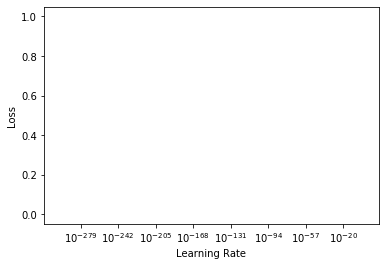

In [25]:
# fp16
learn.lr_find()

In [100]:
gt = torch.tensor([2]).int().cuda()
sc = torch.tensor([65536.]).cuda()
fi = torch.tensor([4.]).cuda()
gf = 2.0
bo = 0.5
gi = 2000

tmp = torch._amp_update_scale(gt,
                              sc,
                              fi,
                              gf,
                              bo,
                              gi
                             )
tmp

tensor([32768.], device='cuda:0')

In [14]:
%debug

> <ipython-input-10-187d695ace95>(177)step()
    175 
    176         for i, (p,pg,state,hyper) in enumerate(self.opt.all_params(with_grad=True)):
--> 177             state['hutchinson_trace'] = hutchinson_trace[i]
    178             for cb in self.opt.cbs: state = self._update(state, cb(p, **{**state, **hyper}))
    179             self.opt.state[p] = state

ipdb> hasattr(self, 'fp16_adahessian')
False
ipdb> self
ipdb> c


In [27]:
#learn.fit_one_cycle(1, 15e-2)

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(7.1331, device='cuda:0', grad_fn=<AddBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.2090, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0044, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2421, device='cuda:0', grad_fn=<MaxBackward1>))

Grads going into hvs calc: tensor([[ 0.0121,  0.0144,  0.0204, -0.0077, -0.0042,  0.0090,  0.0173],
        [ 0.0458,  0.0470,  0.0462,  0.0236,  0.0265,  0.0256,  0.0295],
        [ 0.0591,  0.0572,  0.0482,  0.0429,  0.0530,  0.0275,  0.0223],
        [ 0.0512,  0.0272,  0.0161,  0.0446,  0.0728,  0.0561,  0.0307],
        [ 0.0363,  0.0049,  0.0197,  0.0492,  0.0856,  0.0729,  0.0338],
        [ 0.0175, -0.0037,  0.0363,  0.0379,  0.0520,  0.0524,  0.0278],
        [ 0.0245,  0.0129,  0.0363,  0.0326,  0.0281,  0.0258,  0.0112]],
       device='cuda:0', grad_fn=<SelectBackward>)
Params going into hvs calc: tensor([[-0.0191,  0.0032,  0.0287,

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(7.1087, device='cuda:0', grad_fn=<AddBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.2428, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0077, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2084, device='cuda:0', grad_fn=<MaxBackward1>))

Grads going into hvs calc: tensor([[-0.0680, -0.0577, -0.0532, -0.0390, -0.0009,  0.0440,  0.0597],
        [-0.0717, -0.0251, -0.0013,  0.0022,  0.0382,  0.0770,  0.0755],
        [-0.0661, -0.0351,  0.0012,  0.0083,  0.0215,  0.0581,  0.0568],
        [-0.0360, -0.0351, -0.0008,  0.0138,  0.0179,  0.0497,  0.0640],
        [-0.0070, -0.0391, -0.0234,  0.0102,  0.0166,  0.0377,  0.0385],
        [ 0.0003, -0.0507, -0.0555, -0.0174,  0.0101,  0.0404,  0.0245],
        [ 0.0038, -0.0481, -0.0494, -0.0285, -0.0049,  0.0374,  0.0418]],
       device='cuda:0', grad_fn=<SelectBackward>)
Params going into hvs calc: tensor([[-0.0191,  0.0032,  0.0287

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(7.1822, device='cuda:0', grad_fn=<AddBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.2637, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0067, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2089, device='cuda:0', grad_fn=<MaxBackward1>))

Grads going into hvs calc: tensor([[ 0.0083, -0.0096, -0.0157, -0.0285, -0.0104, -0.0039, -0.0094],
        [-0.0005, -0.0245, -0.0138, -0.0330, -0.0619, -0.0437, -0.0311],
        [-0.0273, -0.0301, -0.0308, -0.0577, -0.0989, -0.0758, -0.0592],
        [-0.0428, -0.0217, -0.0193, -0.0429, -0.0716, -0.0598, -0.0442],
        [-0.0425, -0.0243, -0.0147, -0.0440, -0.0467, -0.0542, -0.0470],
        [-0.0447, -0.0221, -0.0119, -0.0400, -0.0374, -0.0520, -0.0351],
        [-0.0508, -0.0323, -0.0238, -0.0450, -0.0603, -0.0751, -0.0392]],
       device='cuda:0', grad_fn=<SelectBackward>)
Params going into hvs calc: tensor([[-0.0191,  0.0032,  0.0287

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(7.1416, device='cuda:0', grad_fn=<AddBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.2551, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0131, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2187, device='cuda:0', grad_fn=<MaxBackward1>))

Grads going into hvs calc: tensor([[-0.0088, -0.0633, -0.0730, -0.1008, -0.1076, -0.1220, -0.1658],
        [ 0.0430, -0.0097, -0.0250, -0.0660, -0.0795, -0.0824, -0.1302],
        [ 0.0616,  0.0287,  0.0044, -0.0211, -0.0649, -0.0845, -0.1304],
        [ 0.0552,  0.0308,  0.0289,  0.0012, -0.0456, -0.0760, -0.0847],
        [ 0.0542,  0.0138,  0.0165, -0.0040, -0.0253, -0.0587, -0.0553],
        [ 0.0709,  0.0258,  0.0059, -0.0248, -0.0404, -0.0551, -0.0607],
        [ 0.0450,  0.0285,  0.0169, -0.0088, -0.0194, -0.0250, -0.0346]],
       device='cuda:0', grad_fn=<SelectBackward>)
Params going into hvs calc: tensor([[-0.0191,  0.0032,  0.0287

hvs min, mean max: (tensor(-179.7061, device='cuda:0'), tensor(-1.1316, device='cuda:0'), tensor(137.5216, device='cuda:0'))

ENTERING STEP
In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(7.0676, device='cuda:0', grad_fn=<AddBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.2743, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2560, device='cuda:0', grad_fn=<MaxBackward1>))

Grads going into hvs calc: tensor([[-0.0514, -0.0057, -0.0308,  0.0027,  0.0137, -0.0013, -0.0111],
        [-0.0602, -0.0131, -0.0429, -0.0193, -0.0105,  0.0122,  0.0125],
        [-0.0734, -0.0320, -0.0250,  0.0024,  0.0224,  0.0254,  0.0119],
        [-0.0468, -0.0135,  0.0007,  0.0302,  0.0578,  0.0611,  0.0428],
        [-0.0323,  0.0016,  0.0037,  0.0311,  0.0591,  0.0485,  0.0295],
        [-0.0315, -0.0023, -0.0063,  0.0260,  0.0399,  0.0153,  0.0181],
        [-0.0351, -0.0127, -0.0250,  0.0134,  0

hvs min, mean max: (tensor(-171.3587, device='cuda:0'), tensor(-5.0717, device='cuda:0'), tensor(236.8813, device='cuda:0'))

ENTERING STEP
In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(7.1805, device='cuda:0', grad_fn=<AddBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.3428, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0083, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.1887, device='cuda:0', grad_fn=<MaxBackward1>))

Grads going into hvs calc: tensor([[ 0.0075, -0.0245, -0.0537, -0.0829, -0.0891, -0.0594, -0.0315],
        [-0.0211, -0.0574, -0.0648, -0.0612, -0.0587, -0.0416, -0.0206],
        [-0.0275, -0.0595, -0.0776, -0.0716, -0.0590, -0.0377, -0.0088],
        [-0.0237, -0.0336, -0.0555, -0.0711, -0.0509, -0.0029,  0.0415],
        [-0.0475, -0.0399, -0.0370, -0.0415, -0.0306,  0.0193,  0.0579],
        [-0.0718, -0.0567, -0.0394, -0.0457, -0.0490, -0.0138,  0.0170],
        [-0.0611, -0.0741, -0.0657, -0.0680, -

hvs min, mean max: (tensor(-163.4037, device='cuda:0'), tensor(-4.7654, device='cuda:0'), tensor(189.0552, device='cuda:0'))

ENTERING STEP
In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(7.0843, device='cuda:0', grad_fn=<AddBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.2394, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0029, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3665, device='cuda:0', grad_fn=<MaxBackward1>))

Grads going into hvs calc: tensor([[ 0.0603,  0.0627,  0.0657,  0.0523,  0.0479,  0.0220,  0.0229],
        [ 0.0623,  0.0728,  0.0862,  0.0681,  0.0641,  0.0357,  0.0398],
        [ 0.0356,  0.0579,  0.0799,  0.0534,  0.0428,  0.0305,  0.0529],
        [ 0.0295,  0.0164,  0.0383,  0.0518,  0.0433,  0.0343,  0.0423],
        [ 0.0323,  0.0116,  0.0092,  0.0250,  0.0382,  0.0112,  0.0145],
        [ 0.0235,  0.0070,  0.0162,  0.0239,  0.0286, -0.0123, -0.0027],
        [ 0.0526,  0.0289,  0.0259,  0.0340,  0

hvs min, mean max: (tensor(-163.4203, device='cuda:0'), tensor(-2.7067, device='cuda:0'), tensor(103.5556, device='cuda:0'))

ENTERING STEP
In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(7.1242, device='cuda:0', grad_fn=<AddBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.3213, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0106, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2194, device='cuda:0', grad_fn=<MaxBackward1>))

Grads going into hvs calc: tensor([[-0.0683, -0.0783, -0.1032, -0.0766, -0.0560, -0.0225, -0.0140],
        [-0.0547, -0.0785, -0.1038, -0.0814, -0.0512, -0.0364, -0.0087],
        [-0.0729, -0.0806, -0.0970, -0.0824, -0.0789, -0.0701, -0.0528],
        [-0.0341, -0.0329, -0.0653, -0.0909, -0.1093, -0.1022, -0.0983],
        [-0.0423, -0.0201, -0.0441, -0.0782, -0.1269, -0.1407, -0.1210],
        [-0.0522, -0.0114, -0.0261, -0.0838, -0.1472, -0.1602, -0.1106],
        [-0.0357,  0.0014, -0.0051, -0.0598, -

hvs min, mean max: (tensor(-134.8505, device='cuda:0'), tensor(-5.5257, device='cuda:0'), tensor(89.8765, device='cuda:0'))

ENTERING STEP
In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(7.1115, device='cuda:0', grad_fn=<AddBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.3457, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0086, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2707, device='cuda:0', grad_fn=<MaxBackward1>))

Grads going into hvs calc: tensor([[-0.0063, -0.0289, -0.0144, -0.0251, -0.0183, -0.0173, -0.0242],
        [-0.0155, -0.0327, -0.0371, -0.0468, -0.0357, -0.0510, -0.0557],
        [-0.0211, -0.0542, -0.0595, -0.0667, -0.0561, -0.0719, -0.0674],
        [ 0.0093, -0.0339, -0.0453, -0.0663, -0.0614, -0.0698, -0.0518],
        [ 0.0097, -0.0180, -0.0265, -0.0429, -0.0323, -0.0319, -0.0253],
        [ 0.0046,  0.0008, -0.0127, -0.0227, -0.0021, -0.0054,  0.0048],
        [-0.0057, -0.0256, -0.0261, -0.0293, -0.

hvs min, mean max: (tensor(-174.9398, device='cuda:0'), tensor(-8.8078, device='cuda:0'), tensor(90.6644, device='cuda:0'))

ENTERING STEP
In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(6.9539, device='cuda:0', grad_fn=<AddBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.3895, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0016, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2164, device='cuda:0', grad_fn=<MaxBackward1>))

Grads going into hvs calc: tensor([[ 5.6500e-02,  2.3007e-02,  4.3164e-03, -7.6676e-03,  1.4349e-02,
          2.3437e-02,  9.5796e-03],
        [ 3.4873e-02,  1.8302e-02,  1.1508e-02, -1.4972e-02,  6.0669e-03,
          2.6134e-02,  2.5127e-02],
        [ 4.0919e-02,  3.7544e-02,  3.1602e-02,  2.1956e-03,  1.7411e-02,
          3.3775e-02,  2.2531e-02],
        [ 7.0082e-02,  5.0974e-02,  3.1622e-02,  8.9096e-05,  8.1725e-03,
          1.2778e-02, -1.4396e-02],
        [ 6.9575e-02,  3.0348e-02,  1.0450e-0

hvs min, mean max: (tensor(-61.4700, device='cuda:0'), tensor(0.7719, device='cuda:0'), tensor(57.5281, device='cuda:0'))

ENTERING STEP
In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(7.0235, device='cuda:0', grad_fn=<AddBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.3548, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0078, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2525, device='cuda:0', grad_fn=<MaxBackward1>))

Grads going into hvs calc: tensor([[-0.0012,  0.0099,  0.0142, -0.0092, -0.0155, -0.0158, -0.0521],
        [-0.0052,  0.0270,  0.0366,  0.0076, -0.0144, -0.0278, -0.0661],
        [-0.0056,  0.0194,  0.0141, -0.0008, -0.0160, -0.0125, -0.0524],
        [-0.0049, -0.0108, -0.0211, -0.0239, -0.0390, -0.0183, -0.0464],
        [-0.0063, -0.0100, -0.0386, -0.0278,  0.0019,  0.0100, -0.0293],
        [-0.0046,  0.0138, -0.0115, -0.0139,  0.0237,  0.0419, -0.0146],
        [ 0.0202,  0.0329,  0.0067,  0.0149,  0.0

hvs min, mean max: (tensor(-53.0777, device='cuda:0'), tensor(0.3020, device='cuda:0'), tensor(36.6407, device='cuda:0'))

ENTERING STEP
In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(6.7853, device='cuda:0', grad_fn=<AddBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.2495, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0051, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3492, device='cuda:0', grad_fn=<MaxBackward1>))

Grads going into hvs calc: tensor([[-2.7809e-02, -1.9644e-02, -1.6827e-02,  1.5691e-02,  1.0721e-02,
         -1.9872e-02, -2.3808e-02],
        [-2.9259e-02, -2.5794e-02, -3.2799e-02, -4.7747e-03, -3.0031e-03,
         -2.4626e-02, -3.6014e-02],
        [ 3.9011e-03, -1.2413e-02, -7.4531e-03,  8.8093e-03,  1.1499e-02,
         -6.0560e-03, -2.4047e-02],
        [-1.4592e-02, -1.1162e-02,  3.5335e-04, -1.0748e-02, -4.4931e-05,
         -9.0249e-03, -7.6072e-03],
        [-1.9164e-02,  5.7676e-03,  4.2288e-03, 

hvs min, mean max: (tensor(-106.9570, device='cuda:0'), tensor(3.2335, device='cuda:0'), tensor(98.2173, device='cuda:0'))

ENTERING STEP
In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(6.0988, device='cuda:0', grad_fn=<AddBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.2720, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0050, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3790, device='cuda:0', grad_fn=<MaxBackward1>))

Grads going into hvs calc: tensor([[-0.0679, -0.0544, -0.0025,  0.0438,  0.0457,  0.0227,  0.0175],
        [-0.0123,  0.0006,  0.0145,  0.0234,  0.0306,  0.0241,  0.0302],
        [ 0.0095,  0.0218,  0.0341,  0.0332,  0.0410,  0.0539,  0.0807],
        [-0.0111,  0.0079,  0.0342,  0.0364,  0.0382,  0.0388,  0.0723],
        [ 0.0052,  0.0121,  0.0211,  0.0061,  0.0188,  0.0184,  0.0494],
        [-0.0009, -0.0074,  0.0219,  0.0153,  0.0332,  0.0447,  0.0603],
        [-0.0038, -0.0214,  0.0032,  0.0153,  0.0

hvs min, mean max: (tensor(-627.1766, device='cuda:0'), tensor(-9.3682, device='cuda:0'), tensor(525.1461, device='cuda:0'))

ENTERING STEP
In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(4.7116, device='cuda:0', grad_fn=<AddBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.2387, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0002, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3591, device='cuda:0', grad_fn=<MaxBackward1>))

Grads going into hvs calc: tensor([[-0.0873, -0.0820, -0.0820, -0.0952, -0.1277, -0.1112, -0.0695],
        [-0.0691, -0.0833, -0.0760, -0.0776, -0.0923, -0.0615, -0.0243],
        [-0.0632, -0.0713, -0.0641, -0.0687, -0.0764, -0.0464, -0.0212],
        [-0.0564, -0.0453, -0.0382, -0.0404, -0.0477, -0.0518, -0.0408],
        [-0.0369, -0.0348, -0.0541, -0.0523, -0.0578, -0.0642, -0.0491],
        [-0.0163, -0.0219, -0.0555, -0.0667, -0.0789, -0.0817, -0.0670],
        [-0.0090, -0.0127, -0.0309, -0.0571, -

hvs min, mean max: (tensor(-619.1690, device='cuda:0'), tensor(-18.0588, device='cuda:0'), tensor(432.8735, device='cuda:0'))

ENTERING STEP
In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(2.9732, device='cuda:0', grad_fn=<AddBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.3132, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0012, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3087, device='cuda:0', grad_fn=<MaxBackward1>))

Grads going into hvs calc: tensor([[ 0.0090, -0.0348, -0.0563, -0.0305,  0.0092, -0.0001,  0.0223],
        [ 0.0139, -0.0037, -0.0485, -0.0667, -0.0372, -0.0247, -0.0020],
        [ 0.0374,  0.0026, -0.0546, -0.0966, -0.0909, -0.0704, -0.0383],
        [ 0.0377, -0.0064, -0.0443, -0.0841, -0.0778, -0.0491, -0.0225],
        [ 0.0645,  0.0192, -0.0336, -0.0983, -0.0773, -0.0385, -0.0182],
        [ 0.0694,  0.0125,  0.0035, -0.0395, -0.0113,  0.0101,  0.0196],
        [ 0.0272, -0.0015,  0.0189, -0.0155,  

hvs min, mean max: (tensor(-265.3300, device='cuda:0'), tensor(4.5596, device='cuda:0'), tensor(540.7711, device='cuda:0'))

ENTERING STEP
In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(3.1904, device='cuda:0', grad_fn=<AddBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.2388, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5686, device='cuda:0', grad_fn=<MaxBackward1>))

Grads going into hvs calc: tensor([[ 0.0063, -0.0127, -0.0306, -0.0527, -0.0251, -0.0401, -0.0509],
        [ 0.0013, -0.0065,  0.0003,  0.0005, -0.0023, -0.0286, -0.0530],
        [-0.0007,  0.0051,  0.0279,  0.0225, -0.0117, -0.0472, -0.0656],
        [ 0.0235,  0.0229,  0.0397,  0.0445,  0.0118, -0.0167, -0.0201],
        [ 0.0026,  0.0086,  0.0226,  0.0317,  0.0289,  0.0199,  0.0157],
        [ 0.0063,  0.0126,  0.0485,  0.0459,  0.0323,  0.0202,  0.0018],
        [ 0.0347,  0.0416,  0.0877,  0.0785,  0.

hvs min, mean max: (tensor(-535.6542, device='cuda:0'), tensor(8.1297, device='cuda:0'), tensor(417.5046, device='cuda:0'))

ENTERING STEP
In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(3.7722, device='cuda:0', grad_fn=<AddBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.2390, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0065, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2288, device='cuda:0', grad_fn=<MaxBackward1>))

Grads going into hvs calc: tensor([[ 0.0254,  0.0326,  0.0448,  0.0535,  0.0660,  0.0716,  0.0706],
        [ 0.0286,  0.0530,  0.0583,  0.0501,  0.0650,  0.0599,  0.0725],
        [ 0.0030,  0.0333,  0.0579,  0.0466,  0.0472,  0.0490,  0.0800],
        [-0.0004,  0.0234,  0.0538,  0.0799,  0.0724,  0.0716,  0.0845],
        [ 0.0141,  0.0331,  0.0658,  0.0968,  0.0943,  0.0865,  0.0945],
        [ 0.0366,  0.0414,  0.0582,  0.0805,  0.0894,  0.0838,  0.0924],
        [ 0.0288,  0.0234,  0.0246,  0.0398,  0

hvs min, mean max: (tensor(-61.0057, device='cuda:0'), tensor(1.3871, device='cuda:0'), tensor(84.1614, device='cuda:0'))

ENTERING STEP
In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(3.9116, device='cuda:0', grad_fn=<AddBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.2747, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0003, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2246, device='cuda:0', grad_fn=<MaxBackward1>))

Grads going into hvs calc: tensor([[ 0.0090,  0.0166,  0.0250,  0.0406,  0.0473,  0.0485,  0.0500],
        [ 0.0068,  0.0232,  0.0294,  0.0400,  0.0459,  0.0524,  0.0488],
        [ 0.0084,  0.0230,  0.0397,  0.0473,  0.0406,  0.0481,  0.0473],
        [-0.0040,  0.0055,  0.0249,  0.0319,  0.0347,  0.0427,  0.0441],
        [-0.0078,  0.0014,  0.0134,  0.0276,  0.0331,  0.0410,  0.0430],
        [-0.0007, -0.0006,  0.0051,  0.0233,  0.0340,  0.0443,  0.0470],
        [-0.0084, -0.0112, -0.0089,  0.0057,  0.0

hvs min, mean max: (tensor(-22.9455, device='cuda:0'), tensor(-0.0532, device='cuda:0'), tensor(19.1754, device='cuda:0'))

ENTERING STEP
In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(3.2902, device='cuda:0', grad_fn=<AddBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.0673, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0048, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0780, device='cuda:0', grad_fn=<MaxBackward1>))

Grads going into hvs calc: tensor([[0.0556, 0.0590, 0.0653, 0.0754, 0.0780, 0.0757, 0.0706],
        [0.0496, 0.0532, 0.0595, 0.0686, 0.0717, 0.0728, 0.0697],
        [0.0405, 0.0441, 0.0501, 0.0602, 0.0642, 0.0656, 0.0653],
        [0.0347, 0.0362, 0.0449, 0.0558, 0.0608, 0.0603, 0.0589],
        [0.0339, 0.0349, 0.0453, 0.0551, 0.0606, 0.0606, 0.0575],
        [0.0389, 0.0394, 0.0470, 0.0576, 0.0625, 0.0617, 0.0602],
        [0.0469, 0.0431, 0.0452, 0.0586, 0.0663, 0.0674, 0.0666]],
       device='cuda:0',

hvs min, mean max: (tensor(-5.9447, device='cuda:0'), tensor(-0.2599, device='cuda:0'), tensor(9.2599, device='cuda:0'))

ENTERING STEP
In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(3.6167, device='cuda:0', grad_fn=<AddBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.1202, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.1610, device='cuda:0', grad_fn=<MaxBackward1>))

Grads going into hvs calc: tensor([[0.0503, 0.0468, 0.0473, 0.0550, 0.0600, 0.0578, 0.0528],
        [0.0527, 0.0494, 0.0489, 0.0537, 0.0575, 0.0565, 0.0529],
        [0.0482, 0.0470, 0.0487, 0.0528, 0.0548, 0.0546, 0.0532],
        [0.0365, 0.0339, 0.0413, 0.0499, 0.0499, 0.0491, 0.0519],
        [0.0328, 0.0273, 0.0384, 0.0520, 0.0514, 0.0484, 0.0530],
        [0.0346, 0.0307, 0.0409, 0.0549, 0.0566, 0.0527, 0.0547],
        [0.0417, 0.0396, 0.0468, 0.0562, 0.0583, 0.0545, 0.0539]],
       device='cuda:0', gr

hvs min, mean max: (tensor(-8.9402, device='cuda:0'), tensor(-0.0268, device='cuda:0'), tensor(5.2411, device='cuda:0'))

ENTERING STEP


SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.03981071710586548)

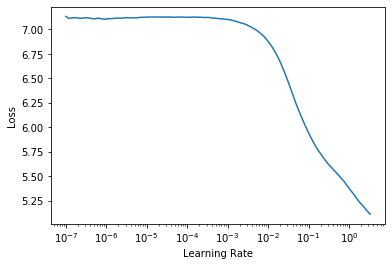

In [26]:
# no_fp16
learn.lr_find()

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(1.1500e+08, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
GRADS OVERFLOW DETECTED, EXITING
In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(56899660., device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
GRADS OVERFLOW DETECTED, EXITING
In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(28699604., device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
GRADS OVERFLOW DETECTED, EXITING
In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(14301509., device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
GRADS OVERFLOW DETECTED, EXITING
In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(7170002.5000, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
GRADS OVERFLOW DETECTED, EXITING
In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(3623360.7500, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)


hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(112126.9531, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-4368., device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>), tensor(3.9922, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>), tensor(2704., device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>))

tensor([[[ 531.0000,  358.5000,  312.0000,  207.8750,  227.1250,  459.5000,
           556.5000],
         [ 472.5000,  221.2500,  148.2500,   97.5000,  200.7500,  373.2500,
           485.0000],
         [ 504.7500,  214.2500,   70.8750,  132.7500,  224.5000,  393.0000,
           520.0000],
         [ 460.7500,  156.5000,    3.2500,  -48.4375,   -8.3750,  151.0000,
          

hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(13953.5381, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-626.5000, device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>), tensor(-14.8672, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>), tensor(670., device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>))

tensor([[[ -98.7500,  -49.0625,  -42.0000,  -55.0312,  -54.8750,  -27.2031,
           -15.8672],
         [ -73.0000,  -49.3750,  -38.7188,  -40.1875,  -39.2812,  -23.4531,
           -22.0312],
         [ -35.3438,  -17.4844,  -13.1094,  -14.2656,  -20.6719,  -15.9688,
           -24.0000],
         [  -8.4375,   17.8438,   11.2734,   -2.7812,   -1.5156,   -5.5469,
       

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(1777.8680, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-152.3750, device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>), tensor(-2.0410, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>), tensor(50.8438, device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>))

tensor([[[-9.7656e-03,  4.8975e-01,  3.4102e+00,  4.8867e+00,  5.7656e+00,
           5.3906e+00,  5.3984e+00],
         [-2.6152e+00,  3.2227e-02, -5.7178e-01,  3.2637e+00,  4.1484e+00,
           4.0234e+00,  5.8945e+00],
         [-6.7930e+00, -1.8301e+00, -1.4590e+00,  4.8828e-02,  7.6172e-01,
           7.9004e-01,  2.8105e+00],
         [-4.0898e+00, -1.1787e+00,  1.2871e+00, -1.2988e-01, -6.5723e-01,
          -8.2422e-01, -9.0430e-01],
         [-1.7578e+00, -8.7891e-02,  5.3828e+00,  5.7070e+00,  2.5762e+00,
           6.6406e-02, -4.1895e-01],
         [-4.7188e+00,

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(219.6754, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-5.8516, device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>), tensor(0.1331, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>), tensor(10.4219, device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>))

tensor([[[-0.0405,  0.4937,  0.8008,  0.5498,  0.6421,  0.8335,  1.1221],
         [ 0.1798,  0.6499,  0.9453,  0.8203,  0.9619,  1.4648,  1.6924],
         [ 0.4028,  0.5713,  0.5439,  0.7432,  0.9365,  1.4482,  1.5488],
         [ 0.6855,  0.6372,  0.5796,  0.7285,  0.8569,  1.1064,  1.2529],
         [ 0.6064,  0.4717,  0.4316,  0.4211,  0.4229,  0.5132,  0.8271],
         [ 0.5791,  0.7031,  0.4858,  0.0704, -0.0856,  0.1309,  0.5576],
         [ 0.4587,  0.9219,  0.7070,  0.2600, -0.1188,  0.1070,  0.4250]],

        [[-0.5850, -0.0990,  0.3169,  0.2896,  0.6895,  1.0723,  1

hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(13.6854, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.5532, device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>), tensor(0.0096, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>), tensor(0.7256, device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>))

tensor([[[-0.0176, -0.0496, -0.0839, -0.0983, -0.0997, -0.1252, -0.1489],
         [-0.0115, -0.0602, -0.0951, -0.1010, -0.1033, -0.1232, -0.1387],
         [-0.0192, -0.0381, -0.0601, -0.0758, -0.0932, -0.1036, -0.1011],
         [-0.0113, -0.0194, -0.0380, -0.0620, -0.0895, -0.1005, -0.0831],
         [-0.0047, -0.0124, -0.0390, -0.0668, -0.0782, -0.0937, -0.0740],
         [-0

hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(0.8562, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.0664, device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>), tensor(0.0007, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>), tensor(0.0335, device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>))

tensor([[[ 1.8120e-03,  2.1610e-03,  2.8248e-03,  2.5558e-03,  2.2945e-03,
           3.2749e-03,  2.5864e-03],
         [ 2.7618e-03,  2.6855e-03,  2.6894e-03,  1.5078e-03,  1.3981e-03,
           2.3384e-03,  2.3727e-03],
         [ 1.6870e-03,  1.7700e-03,  1.4706e-03,  1.0991e-04, -2.0361e-04,
           1.1292e-03,  2.5520e-03],
         [ 2.0828e-03,  2.4128e-03,  2.0905e-03

hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(0.1073, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.0039, device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>), tensor(1.3769e-05, device='cuda:0', dtype=torch.float16,
       grad_fn=<MeanBackward0>), tensor(0.0029, device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>))

tensor([[[-3.0994e-04, -6.0844e-04, -6.1083e-04, -3.4451e-04, -3.0851e-04,
          -4.5133e-04, -5.9080e-04],
         [-2.4223e-04, -5.3978e-04, -5.8746e-04, -4.3273e-04, -3.8385e-04,
          -4.9639e-04, -6.8855e-04],
         [-1.5020e-04, -3.5572e-04, -3.6764e-04, -1.9419e-04, -2.8515e-04,
          -3.1352e-04, -5.2500e-04],
         [-1.7810e-04, -3.0804e-04, 

hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(0.0134, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.0020, device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>), tensor(-2.4319e-05, device='cuda:0', dtype=torch.float16,
       grad_fn=<MeanBackward0>), tensor(0.0014, device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>))

tensor([[[ 7.1764e-05,  8.3268e-05,  1.0449e-04,  1.2708e-04,  1.4329e-04,
           1.5211e-04,  1.7262e-04],
         [ 8.8334e-05,  1.2708e-04,  1.3566e-04,  1.5247e-04,  1.5354e-04,
           1.8775e-04,  2.1458e-04],
         [ 1.1396e-04,  1.4102e-04,  1.3852e-04,  1.5712e-04,  1.6236e-04,
           1.9360e-04,  2.0111e-04],
         [ 1.1581e-04,  1.2147e-04,

hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(0.0008, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>), tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>), tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>))

tensor([[[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
    

hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(1.2913e-05, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>), tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>), tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>))

tensor([[[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],


hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(2.0197e-07, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>), tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>), tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>))

tensor([[[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],


hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(3.2526e-09, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>), tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>), tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>))

tensor([[[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],


hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(4.9702e-11, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>), tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>), tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>))

tensor([[[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],


hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(7.8477e-13, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>), tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>), tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>))

tensor([[[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],


hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(1.2061e-14, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>), tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>), tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>))

tensor([[[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],


hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(1.9170e-16, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>), tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>), tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>))

tensor([[[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],


hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(2.9907e-18, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>), tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>), tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>))

tensor([[[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],


hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(4.6369e-20, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>), tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>), tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>))

tensor([[[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],


hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(7.2804e-22, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>), tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>), tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>))

tensor([[[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=2.2908675418875646e-06)

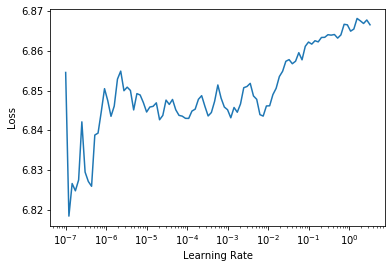

In [26]:
# no fp16, didn't scale down grads before hvs
learn.lr_find()

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(1.1368e+08, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
GRADS OVERFLOW DETECTED, EXITING
In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(57187596., device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
GRADS OVERFLOW DETECTED, EXITING
In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(28207684., device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
GRADS OVERFLOW DETECTED, EXITING
In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(14311705., device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
GRADS OVERFLOW DETECTED, EXITING
In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(7097046.5000, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
GRADS OVERFLOW DETECTED, EXITING
In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(3584241.7500, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)


hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(216.3672, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.2375, device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>), tensor(0.0024, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>), tensor(0.3511, device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>))

hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(110.3819, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(0.0266, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.3518, device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>), tensor(0.0069, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>), tensor(0.5547, device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>))

hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(0.0133, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.4180, device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>), tensor(0.0052, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>), tensor(0.4834, device='cuda:0', dtype=torch.float16

hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(1.6255e-06, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>), tensor(nan, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>))

hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(8.1357e-07, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tenso

hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(9.8827e-11, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>), tensor(nan, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>))

hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(4.9438e-11, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tenso

hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(6.0311e-15, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>), tensor(nan, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>))

hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(3.0533e-15, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tenso

hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(3.7085e-19, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>), tensor(nan, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>))

hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(1.8544e-19, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tenso

SuggestedLRs(lr_min=1.0964781722577755e-07, lr_steep=6.309573450380412e-07)

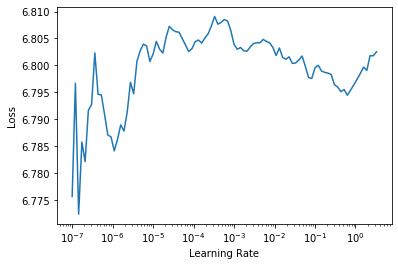

In [159]:
# fp16 with no unscaling before
learn.lr_find()

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(1.1368e+08, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
GRADS OVERFLOW DETECTED, EXITING
In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(57187596., device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
GRADS OVERFLOW DETECTED, EXITING
In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(28207684., device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
GRADS OVERFLOW DETECTED, EXITING
In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(14311705., device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
GRADS OVERFLOW DETECTED, EXITING
In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(7097046.5000, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
GRADS OVERFLOW DETECTED, EXITING
In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(3584241.7500, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)


hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(216.3672, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.2375, device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>), tensor(0.0024, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>), tensor(0.3511, device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>))

hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(110.3819, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(0.0266, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.3518, device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>), tensor(0.0069, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>), tensor(0.5547, device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>))

hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(0.0133, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.4180, device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>), tensor(0.0052, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>), tensor(0.4834, device='cuda:0', dtype=torch.float16

hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(1.6255e-06, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>), tensor(nan, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>))

hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(8.1357e-07, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tenso

hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(9.8827e-11, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>), tensor(nan, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>))

hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(4.9438e-11, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tenso

hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(6.0311e-15, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>), tensor(nan, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>))

hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(3.0533e-15, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tenso

hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(3.7085e-19, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>), tensor(nan, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>))

hvs min, mean max: (tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16), tensor(nan, device='cuda:0', dtype=torch.float16))

HV OVERFLOW DETECTED, EXITING 

In backward, after loss scaled up: self.loss, self.loss.dtype (tensor(1.8544e-19, device='cuda:0', grad_fn=<MulBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tenso

SuggestedLRs(lr_min=1.0964781722577755e-07, lr_steep=6.309573450380412e-07)

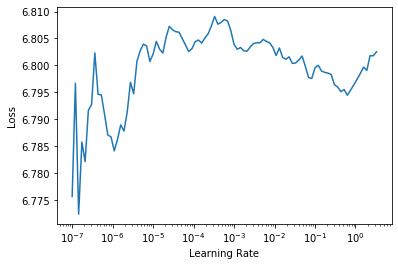

In [159]:
#
learn.lr_find()

In backward: self.loss, self.loss.dtype (tensor(7.0095, device='cuda:0', grad_fn=<AddBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.2623, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0031, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2498, device='cuda:0', grad_fn=<MaxBackward1>))

hvs min, mean max: (tensor(-164.3024, device='cuda:0'), tensor(0.7147, device='cuda:0'), tensor(74.2192, device='cuda:0'))

In backward: self.loss, self.loss.dtype (tensor(6.9573, device='cuda:0', grad_fn=<AddBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.2883, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0048, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2399, device='cuda:0', grad_fn=<MaxBackward1>))

hvs min, mean max: (tensor(-65.1256, device='cuda:0'), tensor(-0.0037, device='cuda:0'), tensor(69.9759, device='cuda:0'))

In backward: self.loss, self.loss.dtype (tensor(6.9232, device='cuda:0', grad_fn=<AddBackward0>), t

in get_hessian, gradsH min, mean max: (tensor(-0.2029, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0033, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3092, device='cuda:0', grad_fn=<MaxBackward1>))

hvs min, mean max: (tensor(-84.5305, device='cuda:0'), tensor(2.5690, device='cuda:0'), tensor(69.9945, device='cuda:0'))

In backward: self.loss, self.loss.dtype (tensor(6.9531, device='cuda:0', grad_fn=<AddBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.2236, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2406, device='cuda:0', grad_fn=<MaxBackward1>))

hvs min, mean max: (tensor(-202.2877, device='cuda:0'), tensor(-7.2573, device='cuda:0'), tensor(30.8857, device='cuda:0'))

In backward: self.loss, self.loss.dtype (tensor(6.9753, device='cuda:0', grad_fn=<AddBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.3199, device='cuda:0', grad_fn=<MinBackward1>), ten

hvs min, mean max: (tensor(-66.8518, device='cuda:0'), tensor(0.4002, device='cuda:0'), tensor(75.8731, device='cuda:0'))

In backward: self.loss, self.loss.dtype (tensor(6.9837, device='cuda:0', grad_fn=<AddBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.2573, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0055, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.1867, device='cuda:0', grad_fn=<MaxBackward1>))

hvs min, mean max: (tensor(-88.7492, device='cuda:0'), tensor(-0.3238, device='cuda:0'), tensor(75.7256, device='cuda:0'))

In backward: self.loss, self.loss.dtype (tensor(6.9449, device='cuda:0', grad_fn=<AddBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.3616, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0010, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2577, device='cuda:0', grad_fn=<MaxBackward1>))

hvs min, mean max: (tensor(-51.8491, device='cuda:0'), tensor(2.4545, device='cuda:0'), tensor(106.

In backward: self.loss, self.loss.dtype (tensor(6.5130, device='cuda:0', grad_fn=<AddBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.2113, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0031, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2488, device='cuda:0', grad_fn=<MaxBackward1>))

hvs min, mean max: (tensor(-199.6534, device='cuda:0'), tensor(-8.2406, device='cuda:0'), tensor(68.0462, device='cuda:0'))

In backward: self.loss, self.loss.dtype (tensor(6.5189, device='cuda:0', grad_fn=<AddBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.2195, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2723, device='cuda:0', grad_fn=<MaxBackward1>))

hvs min, mean max: (tensor(-70.2403, device='cuda:0'), tensor(-0.3567, device='cuda:0'), tensor(61.3445, device='cuda:0'))

In backward: self.loss, self.loss.dtype (tensor(6.3517, device='cuda:0', grad_fn=<AddBackward0>), t

in get_hessian, gradsH min, mean max: (tensor(-0.2433, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2818, device='cuda:0', grad_fn=<MaxBackward1>))

hvs min, mean max: (tensor(-283.8683, device='cuda:0'), tensor(-4.5203, device='cuda:0'), tensor(214.0032, device='cuda:0'))

In backward: self.loss, self.loss.dtype (tensor(3.2465, device='cuda:0', grad_fn=<AddBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.2304, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0036, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.1863, device='cuda:0', grad_fn=<MaxBackward1>))

hvs min, mean max: (tensor(-310.7601, device='cuda:0'), tensor(-4.9345, device='cuda:0'), tensor(358.7761, device='cuda:0'))

In backward: self.loss, self.loss.dtype (tensor(3.0815, device='cuda:0', grad_fn=<AddBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.1760, device='cuda:0', grad_fn=<MinBackward1>)

hvs min, mean max: (tensor(-8.7210, device='cuda:0'), tensor(4.2995, device='cuda:0'), tensor(86.5490, device='cuda:0'))

In backward: self.loss, self.loss.dtype (tensor(3.4797, device='cuda:0', grad_fn=<AddBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.3091, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3495, device='cuda:0', grad_fn=<MaxBackward1>))

hvs min, mean max: (tensor(-30.0147, device='cuda:0'), tensor(0.7808, device='cuda:0'), tensor(25.9470, device='cuda:0'))

In backward: self.loss, self.loss.dtype (tensor(3.6161, device='cuda:0', grad_fn=<AddBackward0>), torch.float32)
in get_hessian, gradsH min, mean max: (tensor(-0.2171, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0080, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0953, device='cuda:0', grad_fn=<MaxBackward1>))

hvs min, mean max: (tensor(-6.9033, device='cuda:0'), tensor(0.0264, device='cuda:0'), tensor(4.9779, 

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.033113110810518265)

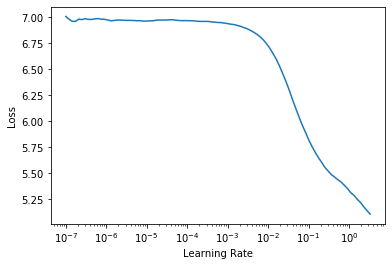

In [125]:
# no fp16
learn.lr_find()

In [25]:
#fp16
learn.lr_find()

tensor(2.6118, device='cuda:0', grad_fn=<AddBackward0>) torch.float32
params min, mean max: (tensor(-0.8244, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0087, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8845, device='cuda:0', grad_fn=<MaxBackward1>))
gradsH min, mean max: (tensor(-0.0528, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0037, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0948, device='cuda:0', grad_fn=<MaxBackward1>))

11 params min, mean max: (tensor(0., device='cuda:0', grad_fn=<MinBackward1>), tensor(0., device='cuda:0', grad_fn=<MeanBackward0>), tensor(0., device='cuda:0', grad_fn=<MaxBackward1>))
11 gradsH min, mean max: (tensor(0., device='cuda:0', grad_fn=<MinBackward1>), tensor(0., device='cuda:0', grad_fn=<MeanBackward0>), tensor(0., device='cuda:0', grad_fn=<MaxBackward1>))

-1 params min, mean max: (tensor(-0.2567, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2457, devic

/home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/ipykernel_launcher.py:89: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.


RuntimeError: Function 'CudnnBatchNormBackwardBackward' returned nan values in its 0th output.

In [19]:
#fp32
learn.lr_find()

tensor(2.4871, device='cuda:0', grad_fn=<AddBackward0>) torch.float32
into scale
scale short circuit
unscaled outputs and type: 2.487056016921997, torch.float32
Scaled outputs: tensor([162991.7031], device='cuda:0', grad_fn=<MulBackward0>)
Scaled outputs type: torch.float32 

params min, mean max: (tensor(-0.9259, device='cuda:0', grad_fn=<MinBackward1>), tensor(0.0230, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8331, device='cuda:0', grad_fn=<MaxBackward1>))
gradsH min, mean max: (tensor(-6136., device='cuda:0', grad_fn=<MinBackward1>), tensor(44.1812, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5044., device='cuda:0', grad_fn=<MaxBackward1>))

11 params min, mean max: (tensor(0., device='cuda:0', grad_fn=<MinBackward1>), tensor(0., device='cuda:0', grad_fn=<MeanBackward0>), tensor(0., device='cuda:0', grad_fn=<MaxBackward1>))
11 gradsH min, mean max: (tensor(0., device='cuda:0', grad_fn=<MinBackward1>), tensor(0., device='cuda:0', grad_fn=<MeanBackward0>), tensor(0., d

/home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/ipykernel_launcher.py:89: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.


RuntimeError: Function 'CudnnBatchNormBackwardBackward' returned nan values in its 0th output.

In [12]:
# fp16, grads, params: min mean, max
learn.lr_find()

tensor(2.2729, device='cuda:0', grad_fn=<AddBackward0>) torch.float32
params min, mean max: (tensor(-0.8587, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0063, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8135, device='cuda:0', grad_fn=<MaxBackward1>))
gradsH min, mean max: (tensor(-0.0742, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0033, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0756, device='cuda:0', grad_fn=<MaxBackward1>))

11 params min, mean max: (tensor(0., device='cuda:0', grad_fn=<MinBackward1>), tensor(0., device='cuda:0', grad_fn=<MeanBackward0>), tensor(0., device='cuda:0', grad_fn=<MaxBackward1>))
11 gradsH min, mean max: (tensor(0., device='cuda:0', grad_fn=<MinBackward1>), tensor(0., device='cuda:0', grad_fn=<MeanBackward0>), tensor(0., device='cuda:0', grad_fn=<MaxBackward1>))


/home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/ipykernel_launcher.py:87: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.


RuntimeError: Function 'CudnnBatchNormBackwardBackward' returned nan values in its 0th output.

fp32

tensor(2.5052, device='cuda:0', grad_fn=<AddBackward0>) torch.float32

 gradsH min, mean max : (tensor(-0.0765, device='cuda:0', grad_fn=<MinBackward1>), tensor(-0.0027, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0402, device='cuda:0', grad_fn=<MaxBackward1>)) 

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>) torch.float32
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>) torch.float32
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>) torch.float32
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>) torch.float32
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>) torch.float32
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>) torch.float32
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>) torch.float32
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>) torch.float32
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>) torch.float32
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>) torch.float32
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>) torch

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=6.309573450380412e-07)

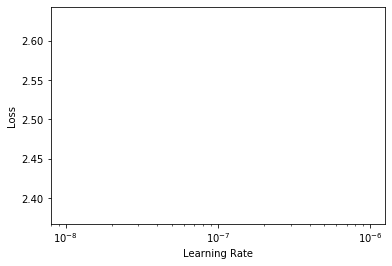

In [124]:
learn = Learner(dls, xresnet34(n_out=10), metrics=accuracy, opt_func=partial(adahessian, fp16=False), 
                            loss_func=LabelSmoothingCrossEntropy()).to_native_fp16()

learn.lr_find()

In [ ]:
gradsH.dtype 151.34573364257812
params.dtype : -0.007621424272656441
fp16 true
gradsH.dtype : 0.0023093526251614094
params.dtype : -0.007621424272656441

In [10]:
def get_learn(opt=adahessian, fp16=False):
    if fp16: learn = Learner(dls, xresnet34(n_out=10), metrics=accuracy, opt_func=opt, 
                            loss_func=LabelSmoothingCrossEntropy()).to_native_fp16()
    else: learn = Learner(dls, xresnet34(n_out=10), metrics=accuracy, opt_func=opt, 
                          loss_func=LabelSmoothingCrossEntropy())
    return learn

In [11]:
def run_learn(runs=1, epochs=5, lr=1e-3, opt=adahessian, fp16=False):
    acc_ls=[]
    for i in range(runs):
        print(f'Run {i}')
        learn = get_learn(opt=opt, fp16=fp16)
        learn.fit_one_cycle(epochs, lr)
        acc_ls.append(learn.final_record[2])
    print(f'Mean accuracy for {runs} runs: {np.mean(acc_ls)} ±{np.std(acc_ls)}')

## Ranger

### 5e

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.0063095735386013985)

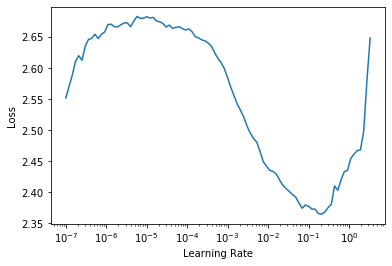

In [13]:
learn = Learner(dls, xresnet34(n_out=10), metrics=accuracy, opt_func=ranger, loss_func=LabelSmoothingCrossEntropy())
learn.lr_find()

In [16]:
run_learn(runs=5, epochs=5, lr=1e-2, opt=ranger)

Run 0


Run 1


Run 2


Run 3


Run 4


Mean accuracy for 5 runs: 0.8017834305763245 ±0.0037892631947342493


In [17]:
run_learn(runs=3, epochs=20, lr=1e-2, opt=ranger)

Run 0


Run 1


Run 2


Mean accuracy for 3 runs: 0.8881528576215109 ±0.002161852349618791


## AdaHessian

In [12]:
opt=adahessian

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.04786301031708717)

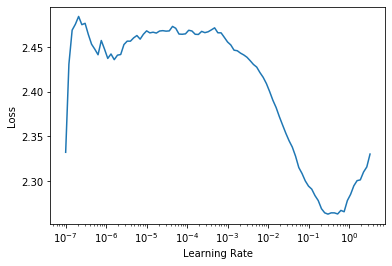

In [13]:
learn = Learner(dls, xresnet34(n_out=10), metrics=accuracy, opt_func=opt, loss_func=LabelSmoothingCrossEntropy())
learn.lr_find()

### 5e

In [14]:
run_learn(runs=5, epochs=5, lr=15e-2, opt=adahessian)

Run 0


Run 1


Run 2


Run 3


Run 4


Mean accuracy for 5 runs: 0.8052484154701233 ±0.0038015651737167253


### 20e

In [15]:
run_learn(runs=5, epochs=20, lr=15e-2, opt=adahessian)

Run 0


Run 1


Run 2


Run 3


KeyboardInterrupt: 

Only 3 20epoch runs completed:

In [15]:
(88.78 + 88.3 + 88.74)/3

88.60666666666667

## Testing speed impact of Gradient Accumulation

Standard 5 epoch run (no fp16) : **260s**, **80.5%**

Update every 2nd step, 5 epoch run (no fp16) : **250s**

n_acc = 2

In [7]:
run_learn(runs=5, epochs=5, lr=15e-2, opt=partial(adahessian, n_acc=2))

Run 0


Run 1


Run 2


Run 3


RuntimeError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 10.76 GiB total capacity; 9.36 GiB already allocated; 20.62 MiB free; 9.45 GiB reserved in total by PyTorch)
Exception raised from malloc at /pytorch/c10/cuda/CUDACachingAllocator.cpp:272 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x42 (0x7f1ff073b1e2 in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libc10.so)
frame #1: <unknown function> + 0x1e64b (0x7f1ff099164b in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libc10_cuda.so)
frame #2: <unknown function> + 0x1f464 (0x7f1ff0992464 in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libc10_cuda.so)
frame #3: <unknown function> + 0x1faa1 (0x7f1ff0992aa1 in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libc10_cuda.so)
frame #4: at::native::empty_cuda(c10::ArrayRef<long>, c10::TensorOptions const&, c10::optional<c10::MemoryFormat>) + 0x11e (0x7f1f8fd3890e in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #5: <unknown function> + 0xf33949 (0x7f1f8e172949 in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #6: <unknown function> + 0xf4d777 (0x7f1f8e18c777 in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #7: <unknown function> + 0x10e9c7d (0x7f1fc8f28c7d in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #8: <unknown function> + 0x10e9f97 (0x7f1fc8f28f97 in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #9: at::empty(c10::ArrayRef<long>, c10::TensorOptions const&, c10::optional<c10::MemoryFormat>) + 0xfa (0x7f1fc9033a1a in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #10: at::TensorIterator::fast_set_up(at::TensorIteratorConfig const&) + 0x56a (0x7f1fc8cc0f8a in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #11: at::TensorIterator::build(at::TensorIteratorConfig&) + 0x76 (0x7f1fc8cc4ff6 in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #12: at::TensorIterator::TensorIterator(at::TensorIteratorConfig&) + 0xdd (0x7f1fc8cc565d in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #13: at::TensorIterator::binary_op(at::Tensor&, at::Tensor const&, at::Tensor const&, bool) + 0x14a (0x7f1fc8cc580a in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #14: <unknown function> + 0x17f5960 (0x7f1f8ea34960 in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #15: at::native::threshold_backward_cuda(at::Tensor const&, at::Tensor const&, c10::Scalar) + 0x4f (0x7f1f8ea363ef in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #16: <unknown function> + 0xf242c0 (0x7f1f8e1632c0 in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #17: <unknown function> + 0xa9b254 (0x7f1fc88da254 in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #18: at::threshold_backward(at::Tensor const&, at::Tensor const&, c10::Scalar) + 0x183 (0x7f1fc900b2a3 in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #19: <unknown function> + 0x2f1492f (0x7f1fcad5392f in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #20: <unknown function> + 0xa9b254 (0x7f1fc88da254 in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #21: at::threshold_backward(at::Tensor const&, at::Tensor const&, c10::Scalar) + 0x183 (0x7f1fc900b2a3 in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #22: torch::autograd::generated::ReluBackward0::apply(std::vector<at::Tensor, std::allocator<at::Tensor> >&&) + 0x181 (0x7f1fcab7f3a1 in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #23: <unknown function> + 0x3375bb7 (0x7f1fcb1b4bb7 in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #24: torch::autograd::Engine::evaluate_function(std::shared_ptr<torch::autograd::GraphTask>&, torch::autograd::Node*, torch::autograd::InputBuffer&, std::shared_ptr<torch::autograd::ReadyQueue> const&) + 0x1400 (0x7f1fcb1b0400 in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #25: torch::autograd::Engine::thread_main(std::shared_ptr<torch::autograd::GraphTask> const&) + 0x451 (0x7f1fcb1b0fa1 in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #26: torch::autograd::Engine::thread_init(int, std::shared_ptr<torch::autograd::ReadyQueue> const&, bool) + 0x89 (0x7f1fcb1a9119 in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #27: torch::autograd::python::PythonEngine::thread_init(int, std::shared_ptr<torch::autograd::ReadyQueue> const&, bool) + 0x4a (0x7f1fdf37bdea in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_python.so)
frame #28: <unknown function> + 0xc819d (0x7f1ff9f7d19d in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6)
frame #29: <unknown function> + 0x76db (0x7f1ffd2ea6db in /lib/x86_64-linux-gnu/libpthread.so.0)
frame #30: clone + 0x3f (0x7f1ffd013a3f in /lib/x86_64-linux-gnu/libc.so.6)


3-run Average

In [8]:
(77.7+78.3+78.)/3

78.0

n_acc = 3

In [9]:
run_learn(runs=5, epochs=5, lr=15e-2, opt=partial(adahessian, n_acc=3))